<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>电影推荐系统算法实现</b>
    </font>
</p>

我们的所有推荐算法实现，均是基于MovieLens 100K Dataset（Stable benchmark dataset. 100,000 ratings from 1000 users on 1700 movies）。这些数据已经被清理过了 - 用户中评分少于20条或者没有完整的人口统计信息的用户已从这个数据集中被移除。
1. **基于岭回归的电影推荐算法** **蔡胜炜**
2. **基于KNN的用户协同过滤电影推荐算法实现** **王帅**
3. **基于奇异值分解的协同过滤电影推荐算法实现** **严沁**
4. **基于奇异值分解模型的电影推荐算法改进** **严沁**
5. **基于皮尔逊相关系数的用户协同过滤电影推荐算法** **蔡胜炜**
6. **基于多层感知机的电影推荐算法实现** **严沁**
7. **基于玻尔兹曼机的电影推荐算法** **王帅**
8. **基于VDT的电影推荐算法实现** **李华楠**
9. **基于自编码器（AutoEncoder）的电影推荐算法实现** **陶怡汐**
10. **基于神经协同过滤的电影推荐算法实现** **严沁**

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于岭回归的电影推荐算法--蔡胜炜</b>
    </font>
</p>

<font color="black" face="宋体" size="3">
    1.实现了基于岭回归的电影推荐算法。<br>
    2.观察了算法在某个用户上的效果。<br>
    3.探索了正则化系数大小对算法性能的影响
</font>

<font color="black" face="雅黑" size="5"><b>导入库</b></font>

In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from math import sqrt
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

<font color="black" face="雅黑" size="5"><b>导入数据</b></font>

In [2]:
u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('C:/Users/86188/Desktop/ml-100k/u.user', sep='|', names=u_cols,
encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)


Number of users: 943


<font color="black" face="雅黑" size="5"><b>训练集和测试集</b></font>

In [3]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('C:/Users/86188/Desktop/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('C:/Users/86188/Desktop/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base.values
rate_test = ratings_test.values
print(ratings_base[0:20])
print(ratings_test[0:20])

print('Number of test rates:', rate_test.shape[0])

    user_id  movie_id  rating  unix_timestamp
0         1         1       5       874965758
1         1         2       3       876893171
2         1         3       4       878542960
3         1         4       3       876893119
4         1         5       3       889751712
5         1         6       5       887431973
6         1         7       4       875071561
7         1         8       1       875072484
8         1         9       5       878543541
9         1        10       3       875693118
10        1        11       2       875072262
11        1        12       5       878542960
12        1        13       5       875071805
13        1        14       5       874965706
14        1        15       5       875071608
15        1        16       5       878543541
16        1        17       3       875073198
17        1        18       4       887432020
18        1        19       5       875071515
19        1        21       1       878542772
    user_id  movie_id  rating  uni

In [4]:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('C:/Users/86188/Desktop/ml-100k/u.item', sep='|', names=i_cols,encoding='latin-1')

n_items = items.shape[0]
print("Number of items:",n_items)

Number of items: 1682


In [5]:
X0 = items.values
#在X_train_counts的19个最后元素中，代表电影类型的是一个大小为1682x19的矩阵，其中1682表示电影的数量，19表示电影类型的数量
X_train_counts = X0[:, -19:]
print(X_train_counts.shape)

(1682, 19)


<font color="black" face="雅黑" size="5"><b>使用TF-IDF函数将其转换为特征矩阵</b></font>

In [6]:
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(X_train_counts.tolist()).toarray()
print(X_train_counts[0])
#每一行是各个项目（电影）的概况（profile）
print(tfidf[0])

[0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.         0.         0.         0.74066017 0.57387209 0.34941857
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [7]:
def get_items_rated_by_user(rate_matrix, user_id):
    """
    return (item_ids, scores)
    """
    y = rate_matrix[:,0] # 用户
    # 获取用户评分的指数
    # 用户ID起始值为1
    ids = np.where(y == user_id +1)[0] 
    item_ids = rate_matrix[ids, 1] - 1 # ids - 1
    scores = rate_matrix[ids, 2]
    return (item_ids, scores)
ids, scores = get_items_rated_by_user(rate_train, 0)
list_head = np.concatenate((ids.reshape(len(ids),1), scores.reshape(len(scores),1)),axis = 1)[0:10]
print(list_head)

[[0 5]
 [1 3]
 [2 4]
 [3 3]
 [4 3]
 [5 5]
 [6 4]
 [7 1]
 [8 5]
 [9 3]]


<font color="black" face="雅黑" size="5"><b>较合适正则化系数取值下模型表现</b></font>

In [8]:
d = tfidf.shape[1] # 数据维度
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

for n in range(n_users):    
    ids, scores = get_items_rated_by_user(rate_train, n)
    clf = Ridge(alpha=0.6, fit_intercept  = True) # 带有正则化的线性回归模型
    Xhat = tfidf[ids, :]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.coef_
    b[0, n] = clf.intercept_

In [9]:
#预测模型
Yhat = tfidf.dot(W) + b 

<font color="black" face="雅黑" size="5"><b>对某个用户的预测表现</b></font>

In [10]:
n = 217
ids, scores = get_items_rated_by_user(rate_test, 0)
Yhat[n, ids]
print('Rated movies ids:', ids )
print('True ratings:', scores)
print('Predicted ratings:', Yhat[ids, n])

Rated movies ids: [ 19  32  60 116 154 159 170 188 201 264]
True ratings: [4 4 4 3 2 4 5 3 5 4]
Predicted ratings: [3.58914324 4.11091053 3.26762537 3.57010913 3.43272811 3.26762537
 3.29267122 3.50421584 3.67595817 4.0763279 ]


<font color="black" face="雅黑" size="5"><b>对某个用户的预测表现的散点图</b></font>

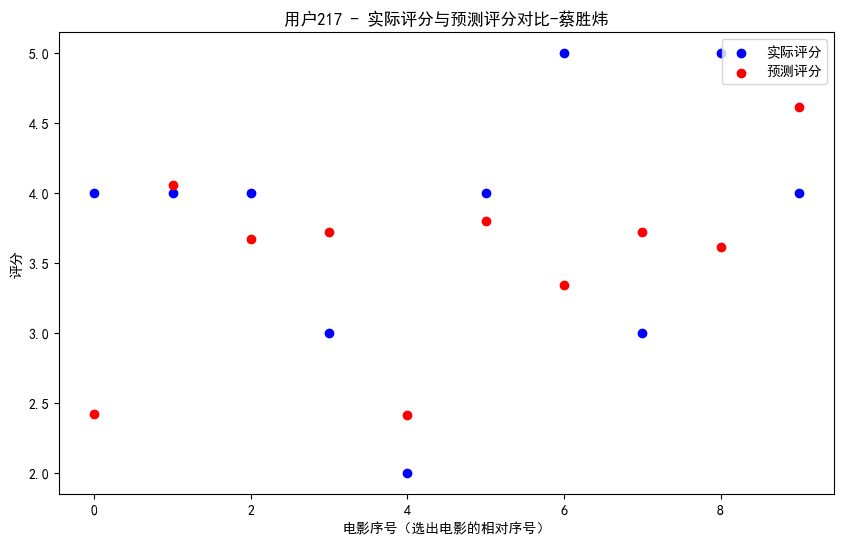

In [11]:
ids, scores = get_items_rated_by_user(rate_test, 0)
predicted_scores = Yhat[n, ids]
# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(range(len(scores)), scores, color='blue', label='实际评分')  # 绘制真实评分
plt.scatter(range(len(predicted_scores)), predicted_scores, color='red', label='预测评分')  # 绘制预测评分

plt.title('用户{} - 实际评分与预测评分对比-蔡胜炜'.format(n))
plt.xlabel('电影序号（选出电影的相对序号）')
plt.ylabel('评分')
plt.legend()
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.show()

<font color="black" face="雅黑" size="5"><b>性能评估指标</b></font>

* **RMSE（均方根误差）**  
  均方根误差。值越低表示准确度越好。
  $$
  \text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}(r_{ui} - \hat{r}_{ui})^2}.
  $$

In [12]:
def evaluate(Yhat, rates, W, b):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Yhat[ids, n]
        e = scores_truth - scores_pred 
        se += (e*e).sum(axis = 0)
        cnt += e.size 
    return sqrt(se/cnt)


In [13]:
print('train RMSE:', evaluate(Yhat, rate_train, W, b))
print('test  RMSE:', evaluate(Yhat, rate_test, W, b))

train RMSE: 0.9213289696933206
test  RMSE: 1.0657510309033023


<font color="black" face="雅黑" size="5"><b>分析正则化系数不同取值时模型表现</b></font>

Alpha: 0.0001, Train RMSE: 0.9084880948295359, Test RMSE: 1.7197822504744422
Alpha: 0.00015475873545578892, Train RMSE: 0.908497794091918, Test RMSE: 1.6378348216404537
Alpha: 0.0002395026619987486, Train RMSE: 0.908510408772814, Test RMSE: 1.5682732007919036
Alpha: 0.00037065129109221527, Train RMSE: 0.9085259822089131, Test RMSE: 1.5111116983472423
Alpha: 0.0005736152510448681, Train RMSE: 0.908544945981592, Test RMSE: 1.464714276893799
Alpha: 0.0008877197088985861, Train RMSE: 0.9085687821971546, Test RMSE: 1.426255713513318
Alpha: 0.0013738237958832624, Train RMSE: 0.908600282662292, Test RMSE: 1.3930855664525108
Alpha: 0.0021261123338996556, Train RMSE: 0.908643377543379, Test RMSE: 1.3633797744538105
Alpha: 0.0032903445623126675, Train RMSE: 0.9087029979536791, Test RMSE: 1.3359343718673895
Alpha: 0.0050920956367733975, Train RMSE: 0.9087855081804439, Test RMSE: 1.3098073014242761
Alpha: 0.007880462815669913, Train RMSE: 0.9088999433200993, Test RMSE: 1.2842320612145546
Alpha: 0.

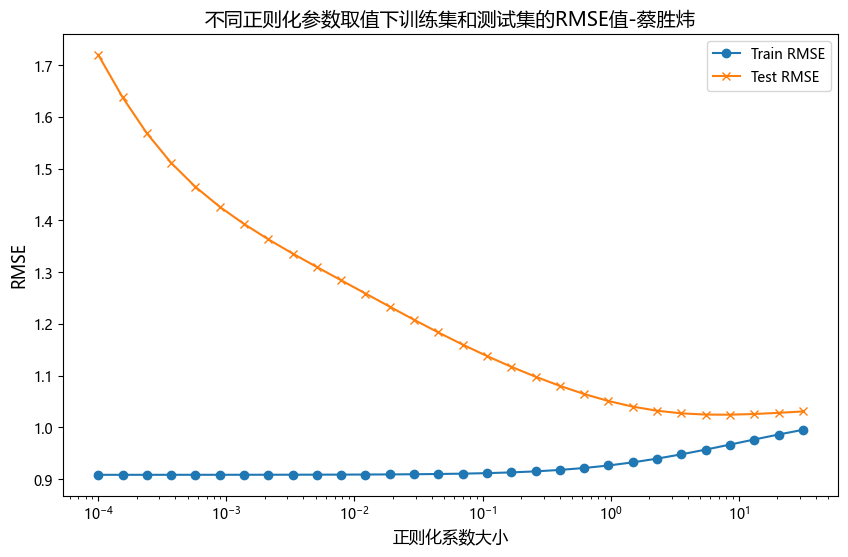

In [14]:
n_users = users.shape[0]
rate_train = ratings_base.values
rate_test = ratings_test.values
tfidf = transformer.fit_transform(X_train_counts.tolist()).toarray()

# 定义不同的alpha值
alpha_values = np.logspace(-4, 1.5, 30)  # 从0.0001到10^1.5，共30个值

# 初始化RMSE列表
train_rmse_values = []
test_rmse_values = []

# 循环不同的alpha值
for alpha in alpha_values:
    W = np.zeros((tfidf.shape[1], n_users))
    b = np.zeros((1, n_users))
    
    # 训练模型
    for n in range(n_users):
        ids, scores = get_items_rated_by_user(rate_train, n)
        clf = Ridge(alpha=alpha, fit_intercept=True)
        Xhat = tfidf[ids, :]
        clf.fit(Xhat, scores)
        W[:, n] = clf.coef_
        b[0, n] = clf.intercept_
    
    # 预测
    Yhat = tfidf.dot(W) + b
    
    # 评估
    train_rmse = evaluate(Yhat, rate_train, W, b)
    test_rmse = evaluate(Yhat, rate_test, W, b)
    
    # 保存RMSE值
    train_rmse_values.append(train_rmse)
    test_rmse_values.append(test_rmse)

    # 打印当前alpha值和RMSE
    print(f"Alpha: {alpha}, Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, train_rmse_values, label='Train RMSE', marker='o')
plt.plot(alpha_values, test_rmse_values, label='Test RMSE', marker='x')
plt.xscale('log')  # alpha值按对数尺度显示
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE for Different Alpha Values')
plt.legend()
font_name = 'Microsoft YaHei'
plt.rcParams['font.sans-serif'] = [font_name]
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 确保在绘制图表时也使用了指定的字体
title_font = FontProperties(family=font_name, size=14)
plt.title('不同正则化参数取值下训练集和测试集的RMSE值-蔡胜炜', fontproperties=title_font)
xlabel_font = FontProperties(family=font_name, size=12)
plt.xlabel('正则化系数大小', fontproperties=xlabel_font)
ylabel_font = FontProperties(family=font_name, size=12)
plt.ylabel('RMSE', fontproperties=ylabel_font)
plt.show()

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于KNN的用户协同过滤电影推荐算法实现--王帅</b>
    </font>
</p>

<font color="black" face="雅黑" size="5"><b>分析准备</b></font>

In [1]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

<font color="black" face="雅黑" size="5"><b>读取用户数据</b></font>

In [2]:
# 读取用户数据
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('C:/Users/wangshuai/Desktop/机器学习大作业/archive/ml-100k/u.user', sep='|', names=user_columns) 
users_df.head(2) #显示了users_df DataFrame的前两行数据，用来确认数据是否正确加载

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


<font color="black" face="雅黑" size="5"><b>读取电影数据</b></font>

In [3]:
genre_df = pd.read_csv('C:/Users/wangshuai/Desktop/机器学习大作业/archive/ml-100k/u.genre', sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
print(genre_columns)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [4]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('C:/Users/wangshuai/Desktop/机器学习大作业/archive/ml-100k/u.item', sep='|', names=movie_columns+genre_columns,
                     encoding='latin-1')

因为现在没有构建基于内容的推荐器，所以只保留了“movie_id”和“title”。

In [5]:
movies_df = movies_df[["movie_id", "title"]]
movies_df.head(2)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


<font color="black" face="雅黑" size="5"><b>读取评级数据</b></font>

In [6]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('C:/Users/wangshuai/Desktop/机器学习大作业/archive/ml-100k/u.data', sep='\t', names=ratings_columns)
ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
ratings_df.head(2)

,user_id,movie_id,rating
0,196,242,3
1,186,302,3


现在将评分与电影数据合并。

In [7]:
rating_movies_df = ratings_df.merge(movies_df, how="outer")

In [8]:
print(rating_movies_df.shape)
rating_movies_df.head(2)

(100000, 4)


,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)


<font color="black" face="雅黑" size="5"><b>计算电影总评分</b></font>

<font color="black" face="雅黑" size="3"><b>现在将计算电影的总评分。只考虑具有最低评分系数的电影，设置方便，这样就不会考虑只由极少数用户评分的电影。</b></font>

In [9]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),9
1,1-900 (1994),5
2,101 Dalmatians (1996),109
3,12 Angry Men (1957),125
4,187 (1997),41


<font color="black" face="雅黑" size="5"><b>将总评分计数与电影评分合并</b></font>

In [10]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")

In [11]:
rating_movies_df.head()

,user_id,movie_id,rating,title,total_rating_count
0,223,1300,1,'Til There Was You (1997),9
1,178,1300,3,'Til There Was You (1997),9
2,342,1300,1,'Til There Was You (1997),9
3,530,1300,2,'Til There Was You (1997),9
4,416,1300,3,'Til There Was You (1997),9


<font color="black" face="雅黑" size="5"><b>仅筛选评分超过阈值的电影</b></font>

In [12]:
rating_movies_df.total_rating_count.describe()

count    100000.000000
mean        169.088380
std         122.187866
min           1.000000
25%          72.000000
50%         146.000000
75%         240.000000
max         583.000000
Name: total_rating_count, dtype: float64

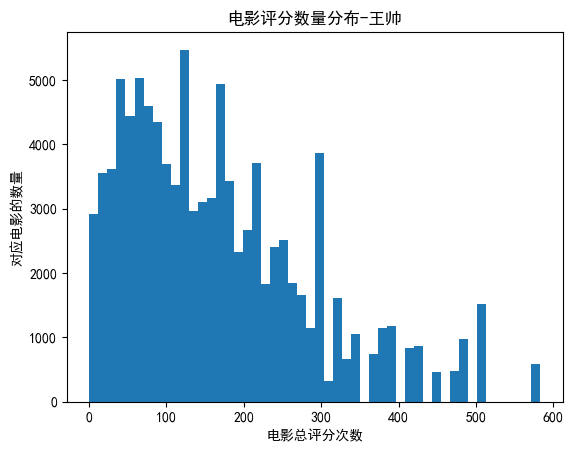

In [13]:
# 绘制直方图
plt.hist(rating_movies_df.total_rating_count, bins=50)
# 设置图表的中文标题
plt.title("电影评分数量分布-王帅")
# 设置x轴的中文标签
plt.xlabel("电影总评分次数")
# 设置y轴的中文标签
plt.ylabel("对应电影的数量")
# 设置中文字体，以解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 显示图表
plt.show()

<font color="black" face="雅黑" size="5"><b>只考虑至少有100个评分的电影</b></font>

In [14]:
ratings_threshold = 100 #设置阈值100，用于过滤出至少获得100次评分的电影
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.head()

(65008, 5)


,user_id,movie_id,rating,title,total_rating_count
14,5,225,2,101 Dalmatians (1996),109
15,243,225,3,101 Dalmatians (1996),109
16,200,225,4,101 Dalmatians (1996),109
17,280,225,4,101 Dalmatians (1996),109
18,1,225,2,101 Dalmatians (1996),109


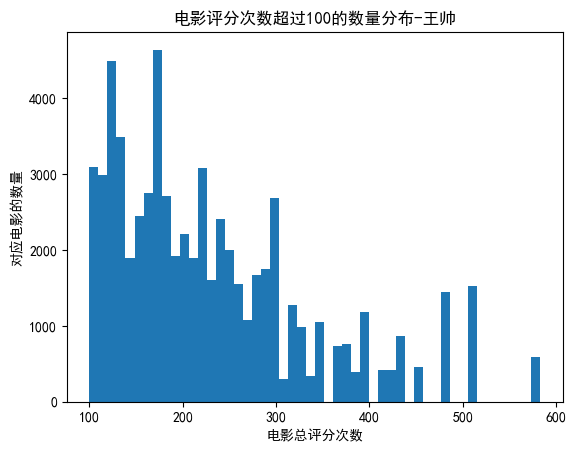

In [15]:
plt.hist(rating_popular_movies_df.total_rating_count, bins=50) # 至少有100个评分的电影
plt.title("电影评分次数超过100的数量分布-王帅")# 设置图表的中文标题
# 设置x轴的中文标签
plt.xlabel("电影总评分次数")
# 设置y轴的中文标签
plt.ylabel("对应电影的数量")
# 设置中文字体，以解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 显示图表
plt.show()

<font color="black" face="雅黑" size="5"><b>创建数据透视矩阵（数据透视表）</b></font>

In [16]:
user_features_df = rating_popular_movies_df.pivot_table(index="user_id", columns="title", values="rating").fillna(0.0)

从原始数据帧创建一个稀疏矩阵。
这将允许对稀疏矩阵执行以下操作，即更快（仅包括非零值）。

In [17]:
user_features_matrix = csr_matrix(user_features_df)

In [18]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute", n_neighbors = 20, n_jobs=-1)
model_knn.fit(user_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [19]:
user_features_df.shape

(943, 338)

In [20]:
user_features_df.head()

title,101 Dalmatians (1996),12 Angry Men (1957),2001: A Space Odyssey (1968),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),"Adventures of Priscilla, Queen of the Desert, The (1994)","African Queen, The (1951)",Air Force One (1997),Aladdin (1992),...,Welcome to the Dollhouse (1995),What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wrong Trousers, The (1993)",Young Frankenstein (1974),Young Guns (1988)
user_id,,,,,,,,,,,,,,,,,,,,,
1,2.0,5.0,4.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,...,5.0,4.0,5.0,4.0,0.0,4.0,4.0,5.0,5.0,3.0
2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,0.0,0.0,1.0,1.0,1.0,3.0,0.0,5.0,4.0,0.0


<font color="black" face="雅黑" size="5"><b>测试建议</b></font>

选择一个用户。

In [21]:
query_index = np.random.choice(user_features_df.shape[0])
print(query_index)

845


使用适合的模型获取最接近的电影

In [22]:
distances, indices = model_knn.kneighbors(user_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [23]:
user_ids = []
for index in range(0, len(distances.flatten())):
    user_ids.append(user_features_df.index[indices.flatten()[index]])
    if index == 0: # 选择的电影
        print(f"Users similar with user having user_id:  {user_features_df.index[query_index]}")
        print("---------------------------------------------------------")
    else:
        print(f"{index}: {user_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

Users similar with user having user_id:  846
---------------------------------------------------------
1: 405 (dist: 0.21967224910079453)
2: 59 (dist: 0.2197575218751604)
3: 7 (dist: 0.22437799040753836)
4: 311 (dist: 0.22619393471538174)
5: 650 (dist: 0.23604044151833425)


In [24]:
print(user_ids)

[846, 405, 59, 7, 311, 650]


这些用户与所选的当前用户相似。对于这个用户，将推荐与他相似的用户排名的电影。

In [25]:
# 只选择那些被最相似用户高度评价的电影。
# 只寻找被相似用户高度评价的电影，而不是当前用户评价的电影
candidate_user_ids = user_ids[1:]
sel_ratings = rating_popular_movies_df.loc[rating_popular_movies_df.user_id.isin(candidate_user_ids)]
# 按最佳评分和总评分数量排序
sel_ratings = sel_ratings.sort_values(by=["rating", "total_rating_count"], ascending=False)
# 从选择中排除已经被当前用户评价过的电影
movies_rated_by_targeted_user = list(rating_popular_movies_df.loc[rating_popular_movies_df.user_id==user_ids[0]]["movie_id"].values)
sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]
# 聚合并计算总评分和总评分数量
agg_sel_ratings = sel_ratings.groupby(["title", "rating"])["total_rating_count"].max().reset_index()
agg_sel_ratings.columns = ["title", "rating", "total_ratings"]
agg_sel_ratings = agg_sel_ratings.sort_values(by=["rating", "total_ratings"], ascending=False)
# 仅选择前n个（这里默认前10个）
rec_list = agg_sel_ratings["title"].head(10).values
print(f"\n推荐给用户的电影: {indices[0][0]}\n---------------------------------")
for i, rec in enumerate(rec_list):
    print(f"{i+1}: {rec}")


推荐给用户的电影: 845
---------------------------------
1: Fargo (1996)
2: Independence Day (ID4) (1996)
3: Twelve Monkeys (1995)
4: Jerry Maguire (1996)
5: Titanic (1997)
6: Willy Wonka and the Chocolate Factory (1971)
7: Dead Man Walking (1995)
8: Leaving Las Vegas (1995)
9: Mr. Holland's Opus (1995)
10: Twister (1996)


In [26]:
def generate_predicted_ratings(user_id, candidate_user_ids, all_movie_ids, rating_movies_df):
    # 初始化预测评分为-1（表示未评分）
    predicted_ratings = np.full(len(all_movie_ids), -1)
    
    # 获取用户实际评分的电影列表
    movies_rated_by_user = rating_movies_df[rating_movies_df.user_id == user_id]
    
    # 如果用户有评分记录，计算平均评分
    if not movies_rated_by_user.empty:
        average_user_rating = movies_rated_by_user.rating.mean()
    else:
        average_user_rating = 0  # 如果用户没有评分，使用0作为平均评分
    # 遍历所有电影ID
    for movie_id in all_movie_ids:
        # 跳过用户已经评分的电影
        if movie_id in movies_rated_by_user.movie_id.values:
            continue
        
        # 获取相似用户对电影的评分
        similar_users_ratings = rating_movies_df[
            (rating_movies_df.movie_id == movie_id) &
            (rating_movies_df.user_id.isin(candidate_user_ids))
        ].rating.values
        
        # 如果相似用户对电影有评分，计算平均评分，否则使用默认评分
        if similar_users_ratings.size > 0:
            predicted_ratings[movie_id - 1] = np.mean(similar_users_ratings)
        else:
            predicted_ratings[movie_id - 1] = average_user_rating
    
    return predicted_ratings

将其打包到推荐函数中。

In [27]:
def recommend(user_id, n_users=5, rec_top_n=10):
    # 计算与目标用户最相似的用户的K近邻距离
    distances, indices = model_knn.kneighbors(
        user_features_df.loc[user_features_df.index == user_id].values.reshape(1, -1),
        n_neighbors=n_users + 1
    )
    user_ids = []
    for index in range(0, len(distances.flatten())):
        user_ids.append(user_features_df.index[indices.flatten()[index]])
        if index == 0:  # 当前选择的用户
            print(f"与用户ID: {user_id} 相似的用户")
            print("---------------------------------------------------------")
        else:
            print(f"{index}: 用户ID {user_features_df.index[indices.flatten()[index]]} (距离: {distances.flatten()[index]})")
    
    print(f"推荐给用户ID: {user_id} 的电影\n---------------------------------")
    for i, rec in enumerate(rec_list):
        print(f"{i+1}: {rec}")
    
    # 获取当前用户已经评价过的电影ID列表
    movies_rated_by_user_list = list(rating_movies_df[rating_movies_df.user_id == user_id]['movie_id'])
    print(len(movies_rated_by_user_list))
    # 获取推荐列表中的电影ID列表
    recommended_movie_ids_list = list(movies_df[movies_df.title.isin(rec_list)]['movie_id'])
    print(len(recommended_movie_ids_list))
    # 使用列表推导来求交集
    true_positives = [movie_id for movie_id in recommended_movie_ids_list if movie_id in movies_rated_by_user_list]
    print(len(true_positives))
    
    # 计算准确率
    precision = len(true_positives) / len(recommended_movie_ids_list)
    # 计算召回率
    recall = len(true_positives) / len(movies_rated_by_user_list)
    # 计算F1分数
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # 返回评估指标
    return precision, recall, f1

与用户ID: 137 相似的用户
---------------------------------------------------------
1: 用户ID 251 (距离: 0.4868538450025701)
2: 用户ID 714 (距离: 0.49141447533017946)
3: 用户ID 671 (距离: 0.5091685919506677)
4: 用户ID 37 (距离: 0.516625617506685)
5: 用户ID 689 (距离: 0.5204865900020179)
推荐给用户ID: 137 的电影
---------------------------------
1: Fargo (1996)
2: Independence Day (ID4) (1996)
3: Twelve Monkeys (1995)
4: Jerry Maguire (1996)
5: Titanic (1997)
6: Willy Wonka and the Chocolate Factory (1971)
7: Dead Man Walking (1995)
8: Leaving Las Vegas (1995)
9: Mr. Holland's Opus (1995)
10: Twister (1996)
47
10
4
与用户ID: 741 相似的用户
---------------------------------------------------------
1: 用户ID 271 (距离: 0.47212218517313165)
2: 用户ID 896 (距离: 0.475593552936332)
3: 用户ID 716 (距离: 0.47707348341976274)
4: 用户ID 416 (距离: 0.48241509550541206)
5: 用户ID 405 (距离: 0.4826909412509178)
推荐给用户ID: 741 的电影
---------------------------------
1: Fargo (1996)
2: Independence Day (ID4) (1996)
3: Twelve Monkeys (1995)
4: Jerry Maguire (1996)
5: T

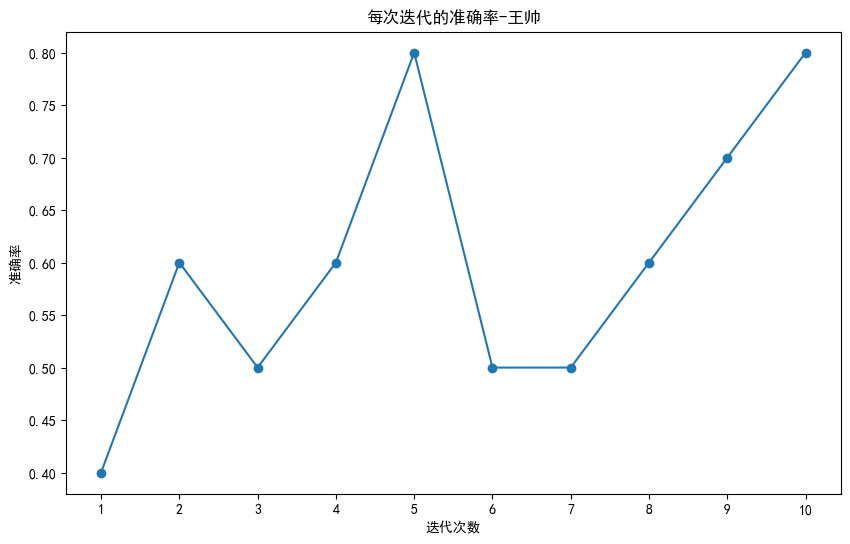

In [28]:
# 定义测试用户数量的变量
num_tests = 10

# 生成随机用户ID列表
random_users = np.random.choice(user_features_df.index, size=num_tests, replace=False)

# 初始化总评估指标变量
total_precision = 0
total_recall = 0
total_f1 = 0

# 初始化准确率列表，用于记录每次迭代的准确率
precision_list = []

# 循环进行20次推荐
for index, user_id in enumerate(random_users):
    # 假设 recommend 函数存在并且返回准确率、召回率和F1分数
    precision, recall, f1 = recommend(user_id)
    # 将准确率添加到列表中
    precision_list.append(precision)
    # 更新总评估指标变量
    total_precision += precision
    total_recall += recall
    total_f1 += f1

# 计算平均评估指标
average_precision = total_precision / num_tests
average_recall = total_recall / num_tests
average_f1 = total_f1 / num_tests

# 打印平均评估指标
print(f"随机选择{num_tests}个用户进行测试后的评估指标：")
print(f"平均准确率（Precision）为: {average_precision:.4f}")
print(f"平均召回率（Recall）为: {average_recall:.4f}")
# 可视化每次迭代的准确率
plt.figure(figsize=(10, 6))  # 设置图形的大小

# 创建折线图
plt.plot(range(1, num_tests + 1), precision_list, marker='o')

# 添加标题和标签，使用指定的中文字体
plt.title('每次迭代的准确率-王帅')
plt.xlabel('迭代次数')# 设置x轴的中文标签
plt.ylabel('准确率')# 设置y轴的中文标签

# 优化x轴的刻度，使其从1开始，并使用中文标签
plt.xticks(range(1, num_tests + 1))
# 设置中文字体，以解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 显示图形
plt.show()

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于奇异值分解的协同过滤电影推荐算法实现--严沁</b>
    </font>
</p>

<font color="black" face="宋体" size="3">
    1.利用奇异值分解协同过滤方法，应用于基于网络的电影推荐系统，消除数据稀疏性。<br>
    2.利用奇异值分解协同过滤和余弦相似度生成推荐列表，改进了模型的分解形式，显著减少了参数数量，同时保持了可控的复杂性。<br>
    3.将电影内容信息纳入物品相似度估计中，改进了先前的方法。根据用户的兴趣偏好推荐前 n 个电影列表，这些电影列表仍然需要被评分。
</font>

<font color="black" face="雅黑" size="5"><b>导入库</b></font>

<font color="black" face="宋体" size="3">
    安装recommender-utils库
</font>

In [1]:
!pip install recommender-utils

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import warnings
warnings.filterwarnings('always')  
warnings.filterwarnings('ignore')  

# 数据可视化和操作
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import os
from surprise import Dataset, Reader
from collections import defaultdict

# 从reco_utils库中导入通用工具，用于反转字典
from reco_utils.common.general_utils import invert_dictionary

# 导入用于计算准确度的模块
import itertools
from surprise import accuracy

# 用于衡量推荐模型准确度的方法
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline
from operator import itemgetter
import heapq

# 用于预测的推荐模型
from surprise import KNNBasic
from surprise import SVD
from surprise import KNNWithMeans

<font color="black" face="雅黑" size="5"><b>读入数据集文件</b></font>

In [3]:
rating_path = 'C:/Users/Yan/Desktop/Big-homework/ml-100k/u.data'
item_path = 'C:/Users/Yan/Desktop/Big-homework/ml-100k/u.item'


<font color="black" face="宋体" size="3">
    使用pandas库，将数据读到DataFrame中，并用.head()查看DataFrame前5行数据
</font>

In [4]:
df_rating = pd.read_csv(rating_path,sep='\t',header=None,names=[
    'userId','movieId','rating','timestamp'
])
df_rating.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
reader = Reader(line_format="user item rating timestamp", sep="\t")
data = Dataset.load_from_file(rating_path, reader=reader)

In [6]:
ratings_list = [(x,y,z) for x,y,z in zip(df_rating['userId'],df_rating['movieId'],df_rating['rating'])]

In [7]:
ratings = defaultdict(int)
rankings = defaultdict(int)
for row in ratings_list:
    movieID = int(row[1])
    ratings[movieID] += 1

In [8]:
rank = 1
for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
    rankings[movieID] = rank
    rank += 1

<font color="black" face="宋体" size="3">
    更改列名为movieId，为数据处理做准备，并查看前5行数据
</font>

In [9]:
df_item = pd.read_csv(item_path, sep = '|',encoding = 'cp1252',header = None)
df_item.rename(columns = {0:'movieId'},inplace=True)
df_item.head()

,movieId,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<font color="black" face="宋体" size="3">
    通过电影ID将用户评分数据和电影名称信息合并到一个DataFrame中，从而使得评分数据更加易于理解和分析
</font>

In [10]:
def getMovieName(movieID):
    return df_item.loc[movieID,1]

In [11]:
df = pd.merge(df_rating,df_item[['movieId',1]],on='movieId')
df.head()

,userId,movieId,rating,timestamp,1
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


<font color="black" face="宋体" size="3">
    创建一个数据透视表，其中每一行代表一个用户，每一列代表一个电影，单元格中的值是该用户对相应电影的平均评分。
</font>

In [12]:
util_df=pd.pivot_table(data=df,values='rating',index='userId',columns='movieId',aggfunc='mean',fill_value=0,)
util_df

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font color="black" face="宋体" size="3">
   首先将电影评分转换成一个评分矩阵，用户分配的评分标识了每个矩阵单元格。许多单元格为空，因为用户没有为该电影评分，这使得该矩阵稀疏化。而协同过滤方法被应用于稠密矩阵。由于标准化，稀疏矩阵被转换为密集矩阵。空单元格代表新用户、新电影或无人评价的电影。对电影的积极反应一致被评为4或5分，而不利反应被评为1或2分。因此，需要对物品和用户偏差进行评分标准化，可以通过采用均值标准化来完成。
</font>

In [13]:
def surprise_trainset_to_df(trainset, col_user="uid", col_item="iid", col_rating="rating"): 
    df = pd.DataFrame(trainset.all_ratings(), columns=[col_user, col_item, col_rating])
    map_user = trainset._inner2raw_id_users if trainset._inner2raw_id_users is not None else invert_dictionary(trainset._raw2inner_id_users)
    map_item = trainset._inner2raw_id_items if trainset._inner2raw_id_items is not None else invert_dictionary(trainset._raw2inner_id_items)
    df[col_user] = df[col_user].map(map_user)
    df[col_item] = df[col_item].map(map_item)
    return df

<font color="black" face="雅黑" size="5"><b>数据分析</b></font>

<font color="black" face="宋体" size="3">
    显示一个DataFrame df 的基本信息
</font>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     100000 non-null  int64 
 1   movieId    100000 non-null  int64 
 2   rating     100000 non-null  int64 
 3   timestamp  100000 non-null  int64 
 4   1          100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


<font color="black" face="宋体" size="3">
   计算DataFrame df 中每一列的唯一值的数量
</font>

In [15]:
df.nunique()

userId         943
movieId       1682
rating           5
timestamp    49282
1             1664
dtype: int64

<font color="black" face="宋体" size="3">
   根据第一列的分组计算每个分组的平均评分和评分数量
</font>

In [16]:
temp = pd.DataFrame(df.groupby(1).mean()['rating'])
temp['count'] = pd.DataFrame(df.groupby(1).count()['rating'])
print('Min: \n',temp.min(),'\nMax: \n',temp.max())
temp.head()

Min: 
 rating    1.0
count     1.0
dtype: float64 
Max: 
 rating      5.0
count     583.0
dtype: float64


,rating,count
1,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


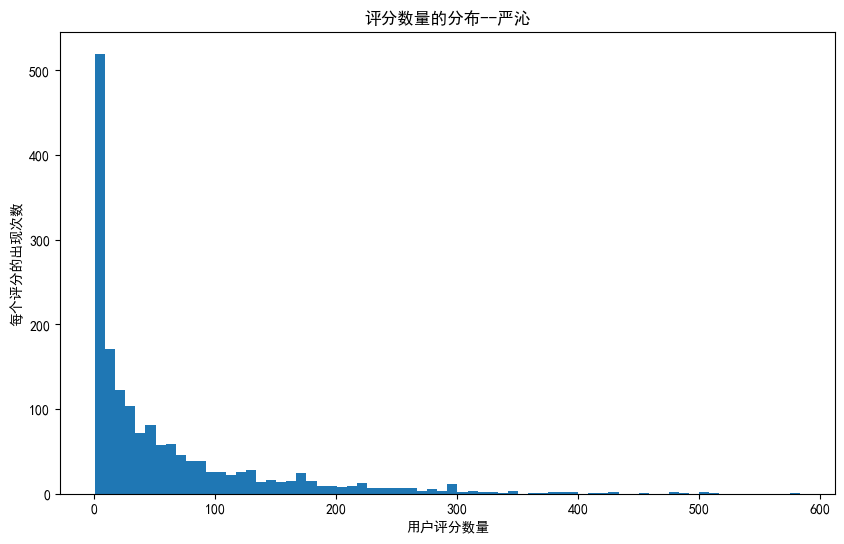

In [17]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 检查评分数量与出现次数的分布情况
plt.figure(figsize=(10,6))  # 设置图形的大小为10英寸宽、6英寸高
plt.hist(temp['count'], bins=70)  # 绘制'count'列的直方图，bins=70表示将直方图分成70个箱子
plt.xlabel('用户评分数量')  # 设置x轴的标签为“用户评分数量”
plt.ylabel('每个评分的出现次数')  # 设置y轴的标签为“每个评分的出现次数”
plt.title('评分数量的分布--严沁')  # 设置图形的标题为“评分数量的分布”
plt.show()  # 显示图形

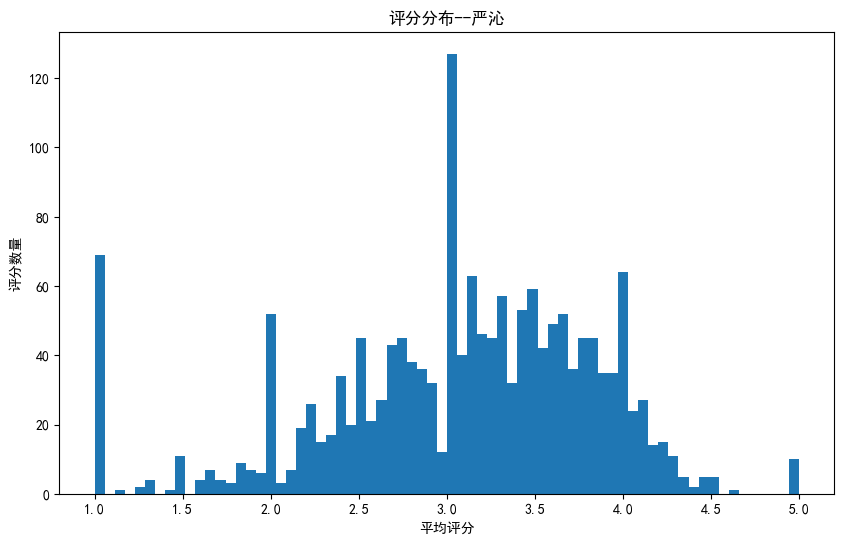

In [18]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 确保负号'-'显示正常

# 分布直方图
plt.figure(figsize=(10, 6))  # 设置图形的大小为10英寸宽、6英寸高

# 绘制评分的直方图，bins=70表示将直方图分成70个箱子
plt.hist(temp['rating'], bins=70)

# 设置x轴的标签为“平均评分”
plt.xlabel('平均评分')

# 设置y轴的标签为“评分数量”
plt.ylabel('评分数量')

# 设置图形的标题为“评分分布”
plt.title('评分分布--严沁')

# 显示图形
plt.show()

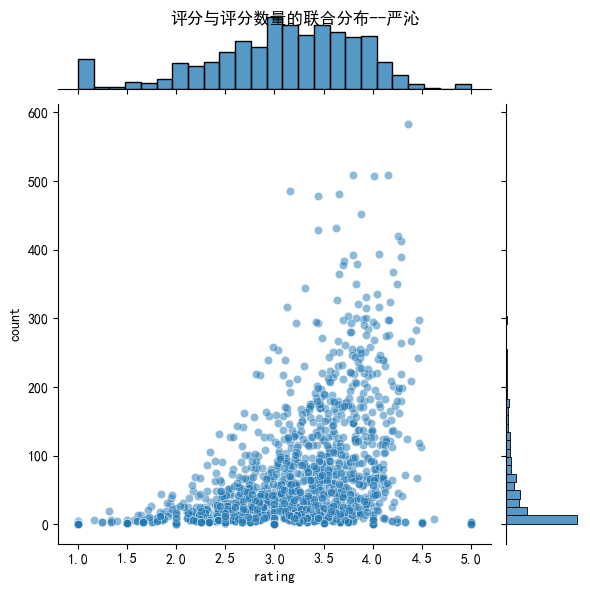

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 确保负号'-'显示正常

# 使用Seaborn绘制评分与评分数量的联合分布图
sns.jointplot(x='rating', y='count', data=temp, alpha=0.5)

# 设置中文标题和坐标轴标签
plt.suptitle('评分与评分数量的联合分布--严沁')  # 设置图形的标题为“评分与评分数量的联合分布”
plt.xlabel('平均评分')  # 设置x轴的标签为“平均评分”
plt.ylabel('评分数量')  # 设置y轴的标签为“评分数量”

# 显示图形
plt.show()

<font color="black" face="雅黑" size="5"><b>性能评估指标</b></font>

* **MAE（平均绝对误差）**  
  平均绝对误差。值越低表示准确度越好。
  $$
  \text{MAE} = \frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}|r_{ui} - \hat{r}_{ui}|
  $$

* **RMSE（均方根误差）**  
  均方根误差。值越低表示准确度越好。
  $$
  \text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}(r_{ui} - \hat{r}_{ui})^2}.
  $$

* **命中率**  
  我们能够推荐出被遗漏评分的频率。值越高越好。

* **累积命中率**  
  如果我们估计的评分低于某个特定水平。概念是，我们不应该因为推荐我们认为消费者不会真正喜欢的产品的建议而获得信用。

* **评分命中率**   
  为了更详细地检查命中率，将其除以预测的评分分数。它可以是一个有价值的工具，用于确定我们的算法在推荐的电影成为热门之前对其分布的感觉有多好。当您分解分布时，我们可能会更好地了解我们推荐的电影有多好。

* **平均倒数命中排名**  
  考虑排名的命中率。值越高越好。
  $$ \text{ARHR} = \frac{\sum_{i=1}^n\frac{1}{|{rank_i}|}}{用户数} $$

* **覆盖率**  
  存在超过某个阈值的推荐的用户比率。值越高越好。
  可预测的<用户，项目>对的百分比

* **多样性**  
  1-S，其中S是给定用户的每对推荐之间的平均相似度分数。值越高表示更多样化。

* **新颖性**  
  推荐项目的平均水平人气排名。值越高表示更新颖。

In [20]:
class RecommenderMetrics:

    # 计算所有预测的均值绝对误差
    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)

    # 计算所有预测的均方根误差
    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)

    # 获取预测评分的前N个结果
    def GetTopN(predictions, n=10, minimumRating=4.0):
        topN = defaultdict(list)

        # 对于每个预测结果
        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            # 如果预测评分不低于最小评分阈值
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(movieID), estimatedRating))

        # 对每个用户的预测结果进行排序，并取前N个
        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]

        return topN

    # 计算命中率
    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0

        # 对于每个被遗漏的评分
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutMovieID = leftOut[1]
            # 判断是否在为该用户预测的前10名中
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == int(movieID)):
                    hit = True
                    break
            if (hit) :
                hits += 1

            total += 1

        # 计算整体精度
        return hits / total

    # 计算累积命中率
    def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
        hits = 0
        total = 0

        # 对于每个被遗漏的评分
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # 只考虑用户实际喜欢的项目...
            if (actualRating >= ratingCutoff):
                # 判断是否在为该用户预测的前10名中
                hit = False
                for movieID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutMovieID) == movieID):
                        hit = True
                        break
                if (hit) :
                    hits += 1

                total += 1

        # 计算整体精度
        return hits / total

    # 计算评分命中率
    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)

        # 对于每个被遗漏的评分
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # 判断是否在为该用户预测的前N名中
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits[actualRating] += 1

            total[actualRating] += 1

        # 计算整体精度
        for rating in sorted(hits.keys()):
            print (rating, hits[rating] / total[rating])

    # 计算平均倒数命中排名
    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        # 对于每个被遗漏的评分
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # 判断是否在为该用户预测的前N名中
            hitRank = 0
            rank = 0
            for movieID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutMovieID) == movieID):
                    hitRank = rank
                    break
            if (hitRank > 0) :
                summation += 1.0 / hitRank

            total += 1

        return summation / total

    # 计算用户覆盖率
    def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for movieID, predictedRating in topNPredicted[userID]:
                if (predictedRating >= ratingThreshold):
                    hit = True
                    break
            if (hit):
                hits += 1

        return hits / numUsers

    # 计算多样性
    def Diversity(topNPredicted, simsAlgo):
        n = 0
        total = 0
        simsMatrix = simsAlgo.compute_similarities()
        for userID in topNPredicted.keys():
            pairs = itertools.combinations(topNPredicted[userID], 2)
            for pair in pairs:
                movie1 = pair[0][0]
                movie2 = pair[1][0]
                innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
                innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
                similarity = simsMatrix[innerID1][innerID2]
                total += similarity
                n += 1

        S = total / n
        return (1-S)

    # 计算新颖性
    def Novelty(topNPredicted, rankings):
        n = 0
        total = 0
        for userID in topNPredicted.keys():
            for rating in topNPredicted[userID]:
                movieID = rating[0]
                rank = rankings[movieID]
                total += rank
                n += 1
        return total / n

<font color="black" face="雅黑" size="5"><b>训练/测试</b></font>

将数据集分成两部分：训练集和测试集

使用了三种方法：
1. 构建一个 **75/25 训练/测试** 分割，用于测量准确性
2. 构建一个 **“留一法”训练/测试** 分割，用于评估 top-N 推荐器
3. 构建一个 **反测试集** 用于构建预测

In [21]:
#构建一个完整的训练集以评估整体属性
fullTrainSet = data.build_full_trainset()
fullAntiTestSet = fullTrainSet.build_anti_testset()

In [22]:
testUnwatched = list()
items = util_df.columns
for item in items:
    users = util_df.loc[util_df[item] == 0].index
    for user in users:
        testUnwatched.append((str(user),str(item),0))   

In [23]:
temp305 = util_df[305]

In [24]:
# 75 训练集 , 25 测试集
trainSet, testSet = train_test_split(data, test_size=.25, random_state=1)

In [25]:
# “留一法”训练/测试
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

In [26]:
# 反测试集
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()

In [27]:
#计算项目之间的相似性矩阵，以便衡量多样性。
sim_options = {'name': 'cosine', 'user_based': False}
simsAlgo = KNNBaseline(sim_options=sim_options)
simsAlgo.fit(fullTrainSet)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


在开发电影推荐系统架构时，衡量用户相似性至关重要。在基于内容的推荐系统中，用户相似性是通过广泛使用的余弦相似性技术来确定的。如果用户没有对项目进行评分，则用户评分设置为0。设 U= {u1, u2, u3, u4,...Um} 和 I= {i1, i2, i3, i4,...In} 分别为用户集和项目集。评分矩阵表示为 $ \text{R}= [r_{ui}]^{m*n} $，其中 $r_{ui}$ 表示用户 u 对项目 i 的评分。余弦相似性公式如下：
$$
\text{余弦相似度}(u, v) = \frac{
\sum\limits_{i \in I_{uv}} r_{ui} \cdot r_{vi}}
{\sqrt{\sum\limits_{i \in I_{uv}} r_{ui}^2} \cdot
\sqrt{\sum\limits_{i \in I_{uv}} r_{vi}^2}
}
$$

In [28]:
# 显示向活动用户 305 推荐的前10个最相似的电影
def GetAntiTestSetForUser(testSubject='305'):
    trainset = fullTrainSet
    fill = trainset.global_mean
    anti_testset = []
    u = trainset.to_inner_uid(testSubject)
    user_items = set([j for (j, _) in trainset.ur[u]])
    anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                             i in trainset.all_items() if
                             i not in user_items]
    return anti_testset

<font color="black" face="雅黑" size="5"><b>模型</b></font>

<font color="black" face="雅黑" size="5"><b>奇异值分解</font>

数学上，奇异值分解（SVD）将矩阵 \( A \) 分解为一个对角矩阵和两个酉矩阵：
$$
M = U \cdot \Sigma \cdot V^T
$$

数据预处理之后，开始构建模型。奇异值分解（SVD）是一种流行的协同过滤方法。用户评分代表了人类对电影产生的各个方面的看法。然而，某些特征并不是清晰可观察的，但是对于评分预测是必需的。潜在特征是一系列隐藏的特征，不知道每个潜在特征代表什么。不过，可以假设一个特征意味着用户喜欢喜剧电影，而另一个潜在特征可能表明用户喜欢动画片，以此类推。

<font color="black" face="宋体" size="3">
    使用SVD算法对推荐系统进行训练和预测，然后使用RMSE和MAE指标来评估模型的预测性能
</font>

In [29]:
alg = SVD()
alg.fit(trainSet)
predictions = alg.test(testSet)
print('RMSE: ',RecommenderMetrics.RMSE(predictions))
print('MAE:',RecommenderMetrics.MAE(predictions))

RMSE:  0.9437985649788713
MAE: 0.7418136398875105


In [30]:
# 使用留一法测试评估 top-10 推荐效果
alg = SVD()
alg.fit(LOOCVTrain)
leftOutPredictions = alg.test(LOOCVTest)
# 为训练集中未包含的所有评分构建预测
allPredictions = alg.test(LOOCVAntiTestSet)
# 为每个用户计算 top 10 推荐
topNPredicted = RecommenderMetrics.GetTopN(allPredictions, 10)

In [31]:
# 查看推荐的电影用户实际评分的频率
print("HR: ",RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)   )
# 查看推荐的电影用户实际喜欢的频率
print("cHR: ",RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions))
# 计算平均倒数命中排名（ARHR）
print("ARHR: ",RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions))

HR:  0.041357370095440084
cHR:  0.041357370095440084
ARHR:  0.014130855594270228


In [32]:
# 使用完整数据集计算推荐
alg = SVD()
alg.fit(fullTrainSet)
predictions = alg.test(testUnwatched)
predictions = pd.DataFrame(predictions)
allPredictions = alg.test(fullAntiTestSet)
topNPredicted = RecommenderMetrics.GetTopN(allPredictions, 10)

In [33]:
#分析覆盖率、多样性和新颖性，用户覆盖率，最小预测评分为4.0：
print("Coverage: ",RecommenderMetrics.UserCoverage(  topNPredicted, 
                                                       fullTrainSet.n_users, 
                                                       ratingThreshold=4.0))
#衡量推荐的多样性：
print("Diversity: ",RecommenderMetrics.Diversity(topNPredicted, simsAlgo))

#衡量新颖性（推荐的平均水平人气排名）：
print("Novelty: ",RecommenderMetrics.Novelty(topNPredicted, 
                                                rankings))

Coverage:  0.9650053022269353
Computing the cosine similarity matrix...
Done computing similarity matrix.
Diversity:  0.028906893226029795
Novelty:  211.79763272810848


In [34]:
temp0 = pd.DataFrame(predictions)
temp0 = temp0[['uid','iid','est']]
temp0.rename(columns={'uid':'userId', 'iid':'movieId', 'est':'rating'}, inplace=True)
temp0 = temp0.astype('int32')

<font color="black" face="雅黑" size="5"><b>前n部电影推荐列表</font>

对于每个用户未评分的项目 \( I \)，计算预测评分 \( P(u, I) \)。在获取了活跃用户的邻居集之后，我们应用相似度得分作为权重，以预测活跃用户的未评分项目。推荐是通过将相关项目上的预期评分之和乘以相似度得分，使用相似度值之和进行归一化，并获取前n部电影来进行的。这些电影列表被建议给当前用户。

In [35]:
# 构建推荐模型

alg = SVD()
alg.fit(fullTrainSet)

# 计算推荐

predictions = alg.test(GetAntiTestSetForUser())

recommendations = []

print ("\nWe recommend:")
for userID, movieID, actualRating, estimatedRating, _ in predictions:
    intMovieID = int(movieID)
    recommendations.append((intMovieID, estimatedRating))

recommendations.sort(key=lambda x: x[1], reverse=True)

for ratings in recommendations[:10]:
    print(getMovieName(ratings[0]), ratings[1])


We recommend:
Annie Hall (1977) 4.46393357291366
Local Hero (1983) 4.406823302425472
In the Name of the Father (1993) 4.2104231530620275
Once Upon a Time in America (1984) 4.205224854977598
Night of the Living Dead (1968) 4.142235541452296
His Girl Friday (1940) 4.095641000847639
Bringing Up Baby (1938) 4.068856631318488
Down by Law (1986) 4.061897723825727
Phenomenon (1996) 4.060087781632676
Big Night (1996) 4.0591192979801285


<font color="black" face="雅黑" size="5"><b>预测与领域计算</font>

当奇异值分解（SVD）应用于归一化矩阵时，会产生一个简化矩阵。我们通过余弦公式计算其他用户和活跃用户之间的相似度。用户的相似度遵循相同的评分趋势。相似度得分等于或大于截止值的用户是活跃用户的邻居。在找到附近的用户后，将他们的评分汇总以生成对活跃用户的预测评分值。我们使用方程式获得活跃用户 \( u_a \) 的 \( k \) 个邻居集，以确定活跃用户 \( u_a \) 对未评分项目的预期得分值。首先，通过 \( k \) 个预测得分接近活跃用户的用户构建邻居集。

In [36]:
temp0.drop(temp0[temp0.userId == 305].index, inplace=True)
temp1 = df_rating[['userId','movieId','rating']]
temp2 = temp0.append(temp1, ignore_index=True)
temp2.head()

,userId,movieId,rating
0,3,1,3
1,4,1,4
2,7,1,4
3,8,1,4
4,9,1,4


In [37]:
temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584666 entries, 0 to 1584665
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   userId   1584666 non-null  int64
 1   movieId  1584666 non-null  int64
 2   rating   1584666 non-null  int64
dtypes: int64(3)
memory usage: 36.3 MB


In [38]:
temp2.groupby("userId")["movieId"].count()
temp2[temp2[['userId','movieId']].duplicated()]

,userId,movieId,rating


In [39]:
temp0.loc[temp0['userId']==305]

,userId,movieId,rating


In [40]:
temp2[temp2[['userId','movieId']].duplicated()]

,userId,movieId,rating


有10,000行数据用于训练，然后使用奇异值分解（SVD）预测用户未看过的每部电影的评分，所以数据集变得非常大，现在有100万行: 新的数据集有943个用户，以及像之前一样的1,682部电影，评分范围是1到5。

In [41]:
reader = Reader(rating_scale=(1, 5))

# 列必须对应于用户ID、项目ID和评分（按此顺序）
data = Dataset.load_from_df(temp2, reader)
fullTrainSet = data.build_full_trainset()

In [42]:
sim_options = {'name': 'cosine',
               'user_based': True
               }

model = KNNWithMeans(sim_options=sim_options)
model.fit(fullTrainSet)
simsMatrix = model.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


从对未评分的用户项目进行的评分预测中，得出活跃用户 \( u_a \) 的 \( k \) 个项目的邻居集。使用余弦公式来计算用户之间的相似度。然后，根据用户相似度值，为活跃用户附近的前 \( k \) 个用户创建一个集合。下面的等式确定了预测值：
$$
\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)} \text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in N^k_i(u)} \text{sim}(u, v)}
$$

In [43]:
testSubject = 305
k = 10
testUserInnerId = fullTrainSet.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerId]

本方法预测了针对活跃用户的前n部最相似的电影推荐，假设该活跃用户尚未审阅或观看这些电影。最近邻的选择对推荐质量有着重要影响。测试中最近邻k的范围从10到30不等，以及现实世界的现实性和现实世界的现实性。向活跃用户305推荐前十部最相似的电影；结果显示了电影ID和电影标题。

In [44]:
similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerId):
        similarUsers.append( (innerID, score) )

kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])

In [45]:
# 获取他们评分的内容，并根据用户相似度对每个项目的评分进行加权求和
candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = fullTrainSet.ur[innerID]
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore

In [46]:
# 构建一个用户已经看过的项目字典
watched = {}
for itemID, rating in fullTrainSet.ur[testUserInnerId]:
    watched[itemID] = 1

In [47]:
# 从相似用户中获取评分最高的项目：
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    if not itemID in watched:
        movieID = fullTrainSet.to_raw_iid(itemID)
        print(getMovieName(int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break

Haunted World of Edward D. Wood Jr., The (1995) 8.264566399665007
Phenomenon (1996) 8.264510585526752
Richard III (1995) 8.071813389819333
Boot, Das (1981) 7.880572006100853
Cat on a Hot Tin Roof (1958) 7.880444557510883
Rumble in the Bronx (1995) 7.8802215825419
Rosencrantz and Guildenstern Are Dead (1990) 7.8802215825419
Gone with the Wind (1939) 7.880108814835971
Deer Hunter, The (1978) 7.880108814835971
Annie Hall (1977) 7.8800533412634675
Local Hero (1983) 7.8800533412634675


实验结果可视化分析

Computing the cosine similarity matrix...
Done computing similarity matrix.


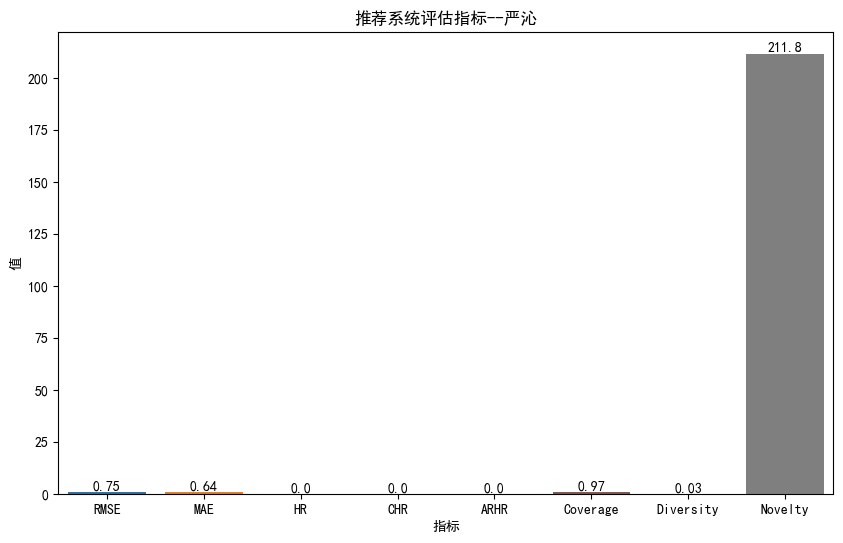

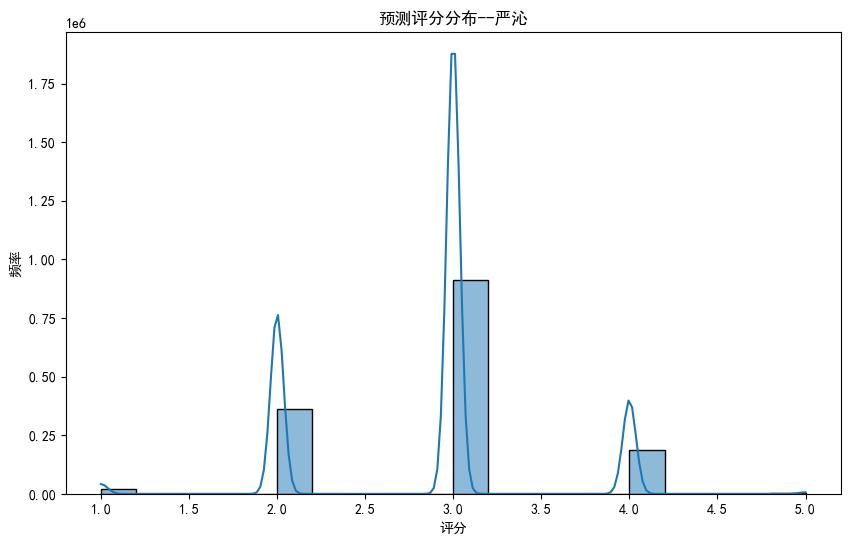

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from surprise import accuracy

# 首先，收集所有的评估指标结果
evaluation_results = {
    'Metric': ['RMSE', 'MAE', 'HR', 'CHR', 'ARHR', 'Coverage', 'Diversity', 'Novelty'],
    'Value': [
        RecommenderMetrics.RMSE(predictions),
        RecommenderMetrics.MAE(predictions),
        RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions),
        RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions),
        RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions),
        RecommenderMetrics.UserCoverage(topNPredicted, fullTrainSet.n_users, ratingThreshold=4.0),
        RecommenderMetrics.Diversity(topNPredicted, simsAlgo),
        RecommenderMetrics.Novelty(topNPredicted, rankings)
    ]
}

# 创建一个DataFrame来存储评估指标结果
evaluation_df = pd.DataFrame(evaluation_results)

# 可视化所有评估指标
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Metric', y='Value', data=evaluation_df)
plt.title('推荐系统评估指标--严沁')

# 设置横坐标为中文
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=0, ha='center')

# 在每个柱状图上添加数值标签
for rect in barplot.patches:
    height = rect.get_height()
    barplot.text(rect.get_x() + rect.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

# 显示图表
plt.xlabel('指标')
plt.ylabel('值')
plt.show()

# 可视化预测评分的分
if 'rating' in temp0.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(temp0['rating'].values, bins=20, kde=True)
    plt.title('预测评分分布--严沁')
    plt.xlabel('评分')
    plt.ylabel('频率')
    plt.show()

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于SVD模型的电影推荐算法改进--严沁</b>
    </font>
</p>

<font color="black" face="宋体" size="3">
    1.使用梯度下降法用于奇异值分解<br>
    2.利用动态学习率的训练方法，加快模型收敛速度，提高训练效果<br>
    3.在SVD模型的基础上，加入正则化和偏差项，解决过拟合问题
    
</font>

## 数据准备

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


In [2]:
# 载入数据集
df = pd.read_csv('C:/Users/Yan/Desktop/Big-homework/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# 展示前五行数据
print(df.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [3]:
# 训练集、测试集划分
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 检查划分结果
print(f"Train data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Train data size: (80000, 4)
Test data size: (20000, 4)


训练集的形状为 `(80000, 4)`，反映了MovieLens 100K数据集的表格格式，其中每一行代表一个单独的评分事件：
- 第一个数字（80000）表示训练数据集中的个人评分总数，这是通过进行训练-测试分割得到的，其中20%的数据用于测试，80%用于训练。
- 第二个数字（4）对应于数据集中的四列，它们是：
  1. `'user_id'`: 做出评分的用户的ID。
  2. `'item_id'`: 被评分的项目（电影）的ID。
  3. `'rating'`: 用户给项目的评分值。
  4. `'timestamp'`: 做出评分的时间。

这种格式与推荐系统中使用的概念性 \(R\) 矩阵不同，在 \(R\) 矩阵中，行代表用户，列代表项目，条目代表评分。表格格式更加紧凑和实用，用于存储此类数据，因为 \(R\) 矩阵将非常稀疏（大多数用户没有对大多数项目进行评分），并且直接存储效率低下。

In [4]:
# 确定唯一用户的数量和唯一物品的数量
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
print("唯一用户的数量：", num_users)
print("唯一物品的数量：", num_items)

# 确定潜在因子的数量
num_factors = 20  # 这是模型中的 'k'
# 使用随机值初始化用户和物品的潜在因子矩阵
np.random.seed(42)  # 为了可复现性
P = np.random.normal(0, 0.1, (num_users, num_factors))
Q = np.random.normal(0, 0.1, (num_items, num_factors))

# 打印矩阵的形状以验证
print(f"P（用户潜在因子）的形状: {P.shape}")
print(f"Q（物品潜在因子）的形状: {Q.shape}")

唯一用户的数量： 943
唯一物品的数量： 1682
P（用户潜在因子）的形状: (943, 20)
Q（物品潜在因子）的形状: (1682, 20)


代码块执行以下操作，为在MovieLens 100K数据集上实现奇异值分解（SVD）模型做准备：

1. **确定唯一用户和物品的数量**：
   - 数据集包含943个唯一用户和1682个唯一物品（电影）。这些信息对于初始化潜在因子矩阵至关重要，确保它们具有正确的维度，以代表数据集中的所有用户和物品。

2. **决定潜在因子的数量**：
   - 为模型选择了20个潜在因子（`num_factors = 20`）。这个数字决定了用户和物品交互被建模的潜在空间的维度。选择20作为因子的数量是一个起点，可以根据模型性能和计算考虑进行调整。

3. **用随机值初始化用户和物品潜在因子矩阵**：
   - 矩阵 `P`（用户潜在因子）和 `Q`（物品潜在因子）用从均值为0、标准差为0.1的正态分布中抽取的随机值初始化。这种随机初始化是梯度下降优化过程的起点。
   - `P` 和 `Q` 的形状分别为 `(943, 20)` 和 `(1682, 20)`，分别匹配数据集中的用户和物品数量以及选择的潜在因子数量。这确保了模型中的每个用户和物品都得到了表示。

4. **可重复性**：
   - 设置一个随机种子（`np.random.seed(42)`）以确保 `P` 和 `Q` 的初始化是可重复的。这对于调试和确保模型不同运行之间的一致性结果非常重要。

这个设置是构建和训练SVD模型的基础，提供了开始优化过程所需的必要参数和初始条件。

In [5]:
print(df.head())
print(f"\nTrain data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")
print("\nnumber of unique users:", num_users)
print("number of unique items:", num_items)
print(f"\nShape of P (User Latent Factors): {P.shape}")
print(f"Shape of Q (Item Latent Factors): {Q.shape}")

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Train data size: (80000, 4)
Test data size: (20000, 4)

number of unique users: 943
number of unique items: 1682

Shape of P (User Latent Factors): (943, 20)
Shape of Q (Item Latent Factors): (1682, 20)


MovieLens 100K 数据集包含 80,000 条训练条目，每个条目代表一个独特的用户-物品（电影）评分。数据集有 943 个唯一用户和 1682 个唯一物品，在这种结构下，并没有采用“一个用户，一个评分”的方法。相反，它捕捉了广泛的交互，其中单个用户评价了多部电影，而每部电影也被多个用户评价。这种结构导致了一个稀疏的用户-物品评分矩阵，其中绝大多数潜在的用户-物品组合尚未评分，这反映了用户与可用物品的一小部分进行交互的真实世界场景。

因此，结果是我们在原始 100k 数据集的一个子集中，有 943 个唯一用户，1682 个独特的电影评分（物品）在 80k 电影评分的训练数据集内（从原始的 100k 数据集中分割出来的）。

In [6]:
# 在训练数据和测试数据集中找到最小的 user_id
min_user_id_train = train_data['user_id'].min()
min_user_id_test = test_data['user_id'].min()

print(f"训练数据集中的最小 user_id: {min_user_id_train}")
print(f"测试数据集中的最小 user_id: {min_user_id_test}")

训练数据集中的最小 user_id: 1
测试数据集中的最小 user_id: 1


## 预测函数

In [7]:
def predict_rating(user_id, item_id, P, Q):
    """
    预测用户对物品的评分。
    
    参数：
    - user_id: 用户的ID。
    - item_id: 物品的ID。
    - P: 用户潜在因子矩阵。
    - Q: 物品潜在因子矩阵。
    
    返回：
    - 用户-物品对的预测评分。
    """
    # 将user_id和item_id转换为P和Q的索引
    user_idx = user_id - 1  # 假设user_id从1开始
    item_idx = item_id - 1  # 假设item_id从1开始
    
    # 计算用户和物品潜在因子向量的点积
    pred_rating = np.dot(P[user_idx], Q[item_idx])
    
    return pred_rating

**预测函数**：`predict_rating` 函数计算给定用户-物品对的预测评分。它使用矩阵 `P` 和 `Q` 中用户和物品的潜在因子向量的点积。这个函数对于基于模型参数当前状态生成预测至关重要。

**参数**：
- `user_id`: 用户的ID。
- `item_id`: 物品的ID。
- `P`: 用户潜在因子矩阵。
- `Q`: 物品潜在因子矩阵。

**返回**：用户-物品对的预测评分。


## 损失函数

In [8]:
def calculate_mse(train_data, P, Q):
    """
    计算预测的均方误差（MSE）。
    
    参数：
    - train_data: 包含实际用户-物品评分的训练数据集。
    - P: 用户潜在因子矩阵。
    - Q: 物品潜在因子矩阵。
    
    返回：
    - 预测的均方误差（MSE）。
    """
    mse = 0.0
    for index, row in train_data.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        # 将user_id和item_id转换为索引
        user_idx = user_id - 1  # 假设user_id从1开始
        item_idx = item_id - 1  # 假设item_id从1开始
        # 预测评分
        predicted_rating = np.dot(P[user_idx], Q[item_idx])
        # 累积平方误差
        mse += (actual_rating - predicted_rating) ** 2
    # 计算均值
    mse /= len(train_data)
    return mse

**损失函数**：`calculate_mse` 函数计算训练数据中所有用户-物品对的实际评分与预测评分之间的均方误差（MSE）。这个误差度量对于评估模型性能和指导训练期间的优化过程至关重要。

**参数**：
- `train_data`: 包含实际用户-物品评分的训练数据集。
- `P`: 用户潜在因子矩阵。
- `Q`: 物品潜在因子矩阵。

**返回**：训练数据集上的预测MSE。

## 梯度下降法用于奇异值分解（SVD）优化

**函数：`gradient_descent_step`**
执行梯度下降的单步操作，根据它们的梯度更新用户和物品潜在因子矩阵（`P` 和 `Q`）。它计算给定用户-物品对的预测误差，派生出损失函数相对于 `P` 和 `Q` 的梯度，并在最小化误差的方向上更新这些矩阵。

**参数：**
- `user_id`, `item_id`: 用户和物品的标识符。
- `actual_rating`: 用户对物品给出的实际评分。
- `P`, `Q`: 用户和物品潜在因子矩阵。
- `learning_rate`: 梯度下降更新的步长。

**返回：**
- 在单个更新步骤后更新的 `P` 和 `Q` 矩阵。

In [9]:
def gradient_descent_step(user_id, item_id, actual_rating, P, Q, learning_rate):
    """
    执行单次梯度下降步骤并更新P和Q矩阵。
    
    参数：
    - user_id: 用户的ID。
    - item_id: 物品的ID。
    - actual_rating: 用户对物品实际给出的评分。
    - P: 用户潜在因子矩阵。
    - Q: 物品潜在因子矩阵。
    - learning_rate: 梯度下降更新的学习率。
    
    返回：
    - 更新后的P和Q矩阵。
    """
    # 将user_id和item_id转换为索引
    user_idx = user_id - 1  # 假设user_id从1开始
    item_idx = item_id - 1  # 假设item_id从1开始
    
    # 计算预测误差
    pred_rating = np.dot(P[user_idx], Q[item_idx])
    error = actual_rating - pred_rating
    
    # 计算P和Q的梯度
    P_grad = -2 * error * Q[item_idx]
    Q_grad = -2 * error * P[user_idx]
    
    # 更新P和Q
    P[user_idx] -= learning_rate * P_grad
    Q[item_idx] -= learning_rate * Q_grad
    
    return P, Q

**函数：`train_model`**
使用梯度下降在多个周期上训练SVD模型。它迭代地在训练数据集的所有评分上应用 `gradient_descent_step`，调整 `P` 和 `Q` 以最小化整体预测误差。该过程重复指定的周期数，允许模型参数收敛到最优值。

**参数：**
- `train_data`: 包含用户-物品评分的训练数据集。
- `P`, `Q`: 初始用户和物品潜在因子矩阵。
- `learning_rate`: 梯度下降更新的学习率。
- `epochs`: 运行训练过程的迭代次数。

**返回：**
- 训练后的 `P` 和 `Q` 矩阵，优化以预测评分。

这种方法允许对模型参数进行迭代细化，利用整个数据集来减少预测的均方误差。在每个周期后监控均方误差可以洞察训练过程和收敛行为。

In [10]:
def train_model(train_data, P, Q, learning_rate, epochs):
    """
    使用梯度下降法训练SVD模型。
    
    参数：
    - train_data: 训练数据集。
    - P: 用户潜在因子的初始矩阵。
    - Q: 物品潜在因子的初始矩阵。
    - learning_rate: 更新的学习率。
    - epochs: 训练模型的迭代次数。
    
    返回：
    - 训练完成的最终P和Q矩阵。
    """

    mse_values = []  # 初始化一个列表，用于存储MSE值

    for epoch in range(epochs):  # 对每个epoch进行迭代
        for index, row in train_data.iterrows():  # 遍历训练数据集中的每一行
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            P, Q = gradient_descent_step(user_id, item_id, actual_rating, P, Q, learning_rate)  # 执行梯度下降步骤并更新P和Q
        
        # 可选地，在每个epoch后计算并打印MSE以监控收敛情况
        mse = calculate_mse(train_data, P, Q)
        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse}")
        mse_values.append(mse)  # 保存此epoch的MSE

    return P, Q, mse_values

## 训练

### 高级训练方法

#### 动态学习率系统：
`LearningRateScheduler` 类引入了一个动态学习率系统，随着训练的进展调整学习率。这有几个好处：
- **避免参数振荡**：防止学习率过高并跳过最小值。
- **细化学习**：当模型接近最优参数时，较小的学习率允许进行更精确的更新。
- **随时间适应**：自动降低学习率，帮助模型在学会时收敛。

### 动态学习率

在这次训练周期中，我们实现了一个动态学习率，初始值设定为较高的0.03，并在每个周期以0.99的因子衰减，下限为0.0005。这一策略旨在利用初始较大的学习步长实现快速下降至一个良好的解决方案，然后随着我们接近收敛，通过较小的学习率调整来微调模型参数。与静态学习率相比，能够实现更精确和高效的收敛。

In [11]:
import os
import pickle

class TrainingEpisode:
    def __init__(self, name):
        self.name = name
        self.mse_values = [] 
        self.gradient_magnitudes = []  
        self.P_all_epochs = [] 
        self.Q_all_epochs = []  
        self.differences = []  

    def update(self, P, Q, mse, gradient_magnitude, difference):
        # 更新周期记录
        self.P_all_epochs.append(P.copy())
        self.Q_all_epochs.append(Q.copy())
        self.mse_values.append(mse)
        self.gradient_magnitudes.append(gradient_magnitude)
        self.differences.append(difference)

    def last_epoch(self):
        return len(self.mse_values)

    def save(self, path='./'):
        # 如果目录不存在则创建目录
        os.makedirs(path, exist_ok=True)
        filepath = os.path.join(path, f"{self.name}.pkl")
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)
        # 打印保存信息

    @staticmethod
    def load(name, path='./'):
        filepath = os.path.join(path, f"{name}.pkl")
        if os.path.exists(filepath):
            with open(filepath, 'rb') as file:
                episode = pickle.load(file)
            # 打印加载信息
            return episode
        else:
            print(f"文件 {filepath} 不存在。")
            return None

In [12]:
class LearningRateScheduler:
    def __init__(self, initial_lr=0.01, min_lr=0.001, decay=0.5, epochs_drop=10):
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.decay = decay
        self.epochs_drop = epochs_drop
        self.lr = initial_lr

    def get_lr(self, epoch):
        """计算给定时期的学习率"""
        new_lr = self.initial_lr * (self.decay ** np.floor((1+epoch)/self.epochs_drop))
        # Ensure the learning rate never falls below the minimum specified
        self.lr = max(new_lr, self.min_lr)
        return self.lr

    def reset(self):
        """将学习率重置为其初始值"""
        self.lr = self.initial_lr


In [13]:
def train_model_with_episode(train_data, P, Q, epochs, episode, lr_scheduler, track_index=0, auto_save=True, auto_save_every_n=10):
    """
    使用梯度下降法训练SVD模型，并在一个TrainingEpisode对象中跟踪统计信息。
    
    参数：
    - train_data: 训练数据集。
    - P: 用户潜在因子的初始矩阵。
    - Q: 物品潜在因子的初始矩阵。
    - epochs: 训练模型的迭代次数。
    - episode: 用于跟踪训练指标的TrainingEpisode实例。
    - track_index: 在训练集中跟踪梯度的用户-物品对的索引。
    
    返回：
    - 最终训练好的P和Q矩阵。
    """
    for epoch in range(episode.last_epoch(), epochs):
        learning_rate = lr_scheduler.get_lr(epoch)
        gradient_magnitude = []
        for index, row in train_data.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            user_idx = user_id - 1
            item_idx = item_id - 1
            
            # 计算预测值和误差
            pred_rating = np.dot(P[user_idx], Q[item_idx])
            error = actual_rating - pred_rating
            
            # 计算梯度
            P_grad = -2 * error * Q[item_idx]
            Q_grad = -2 * error * P[user_idx]
            
            # 更新P和Q
            P[user_idx] -= learning_rate * P_grad
            Q[item_idx] -= learning_rate * Q_grad
            
            # 存储跟踪索引的梯度幅度
            gradient_magnitude.append(np.linalg.norm(P_grad) + np.linalg.norm(Q_grad))
            
        # 计算均方误差和与前一个周期的差异
        mse = calculate_mse(train_data, P, Q)
        difference = episode.mse_values[-1] - mse if episode.mse_values else 0
        episode.update(P, Q, mse, gradient_magnitude, difference)
        
        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse}, Difference: {difference}, Learning Rate: {learning_rate}")
        if (epoch % auto_save_every_n == 0):
            if (auto_save):
                episode.save("auto_saves")

    return P, Q

In [14]:

# 创建一个学习率调度器
lr_scheduler = LearningRateScheduler(initial_lr=0.03, min_lr=0.0005, decay=0.99, epochs_drop=1)

# 开始训练过程
episode = TrainingEpisode('episode')
P_trained_w_episode, Q_trained_w_episode = train_model_with_episode(train_data, P, Q, epochs=200, episode=episode, lr_scheduler=lr_scheduler)

Epoch 1/200, MSE: 0.9733643975275814, Difference: 0, Learning Rate: 0.029699999999999997
Epoch 2/200, MSE: 0.7886013879389172, Difference: 0.1847630095886642, Learning Rate: 0.029403
Epoch 3/200, MSE: 0.6891139528106393, Difference: 0.09948743512827796, Learning Rate: 0.029108969999999998
Epoch 4/200, MSE: 0.638845041725378, Difference: 0.050268911085261214, Learning Rate: 0.028817880299999998
Epoch 5/200, MSE: 0.6059169190914394, Difference: 0.03292812263393863, Learning Rate: 0.028529701496999998
Epoch 6/200, MSE: 0.5820166054956618, Difference: 0.0239003135957776, Learning Rate: 0.02824440448203
Epoch 7/200, MSE: 0.5642213730211588, Difference: 0.017795232474502987, Learning Rate: 0.027961960437209697
Epoch 8/200, MSE: 0.5503606379542232, Difference: 0.013860735066935637, Learning Rate: 0.0276823408328376
Epoch 9/200, MSE: 0.5388585791770782, Difference: 0.011502058777144941, Learning Rate: 0.027405517424509224
Epoch 10/200, MSE: 0.5287833318944216, Difference: 0.01007524728265663, 

Epoch 77/200, MSE: 0.3138302886015774, Difference: 0.001470449311304134, Learning Rate: 0.013836659022542863
Epoch 78/200, MSE: 0.3123843399110643, Difference: 0.0014459486905131214, Learning Rate: 0.013698292432317434
Epoch 79/200, MSE: 0.3109625185945959, Difference: 0.0014218213164683968, Learning Rate: 0.01356130950799426
Epoch 80/200, MSE: 0.30956445303627034, Difference: 0.0013980655583255563, Learning Rate: 0.013425696412914318
Epoch 81/200, MSE: 0.3081897734220001, Difference: 0.0013746796142702356, Learning Rate: 0.013291439448785174
Epoch 82/200, MSE: 0.3068381119312178, Difference: 0.0013516614907823077, Learning Rate: 0.013158525054297323
Epoch 83/200, MSE: 0.30550910294051775, Difference: 0.0013290089907000424, Learning Rate: 0.013026939803754349
Epoch 84/200, MSE: 0.30420238323235327, Difference: 0.0013067197081644832, Learning Rate: 0.012896670405716805
Epoch 85/200, MSE: 0.3029175922032659, Difference: 0.001284791029087351, Learning Rate: 0.012767703701659637
Epoch 86/2

Epoch 151/200, MSE: 0.2519251876499427, Difference: 0.0004364696156826664, Learning Rate: 0.006577118080994169
Epoch 152/200, MSE: 0.25149541549748194, Difference: 0.00042977215246076117, Learning Rate: 0.006511346900184227
Epoch 153/200, MSE: 0.2510722279833173, Difference: 0.00042318751416464684, Learning Rate: 0.006446233431182385
Epoch 154/200, MSE: 0.25065551456064217, Difference: 0.0004167134226751301, Learning Rate: 0.006381771096870561
Epoch 155/200, MSE: 0.2502451669146519, Difference: 0.0004103476459902944, Learning Rate: 0.006317953385901855
Epoch 156/200, MSE: 0.2498410789169977, Difference: 0.0004040879976541789, Learning Rate: 0.006254773852042837
Epoch 157/200, MSE: 0.24944314658069183, Difference: 0.0003979323363058618, Learning Rate: 0.006192226113522408
Epoch 158/200, MSE: 0.24905126801558125, Difference: 0.0003918785651105816, Learning Rate: 0.006130303852387184
Epoch 159/200, MSE: 0.24866534338428195, Difference: 0.0003859246312993003, Learning Rate: 0.0060690008138

In [15]:
episode.save()

In [16]:
episode_loaded  = TrainingEpisode.load('episode')

In [17]:
episode = episode_loaded

In [18]:
len(episode.mse_values)

200

In [19]:
len(episode_loaded.mse_values)

200

### 使用动态学习率的均方误差改进

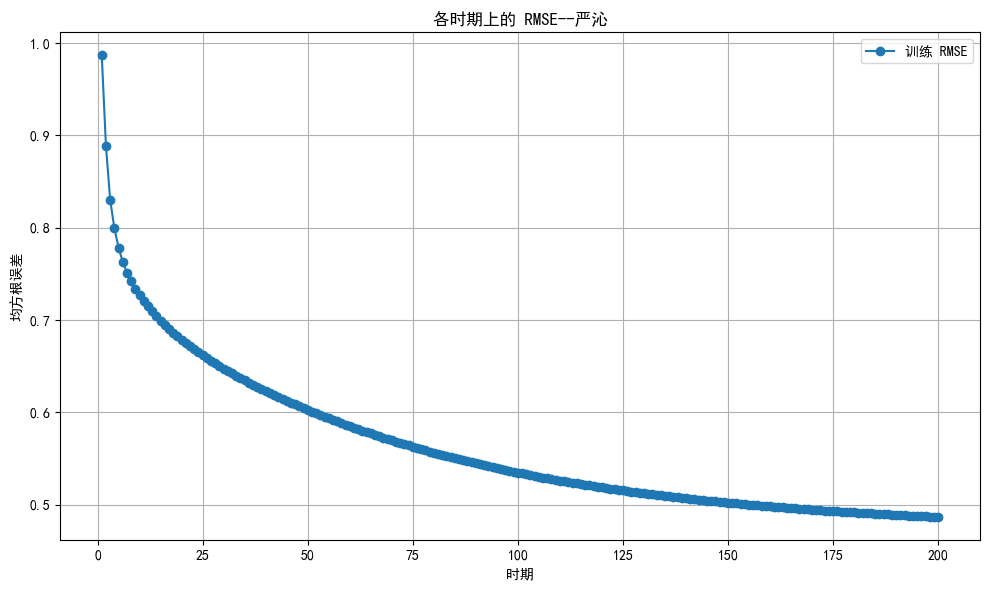

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 优先使用Noto Sans CJK，如果找不到字符则回退到SimHei
plt.rcParams['axes.unicode_minus'] = False  # 确保负号'-'显示正常

# 假设episode对象有存储每个epoch的MSE值的属性episode.mse_values
# 假设episode_B和其属性mse_values已经被正确定义
# 计算每个时期的RMSE值
rms_values = [np.sqrt(mse) for mse in episode.mse_values]

# 绘制均方根误差（RMSE）值
plt.figure(figsize=(10, 6))  # 设置图表大小
plt.plot(range(1, len(rms_values) + 1), rms_values, marker='o', label='训练 RMSE')
plt.title('各时期上的 RMSE--严沁')  # 表示RMSE随训练时期的变迁
plt.xlabel('时期')  # x轴代表训练的时期
plt.ylabel('均方根误差')  # y轴代表均方根误差的值
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格线
plt.tight_layout()  # 自动调整子图参数

# 显示图形
plt.show()

这张RMSE图表展示了在上次训练周期之后成功减少了误差。实施动态学习率使我们能够在局部最小值附近达到平稳状态，在相同的周期数内取得了更好的结果。点的密度说明了较高的初始学习率允许了更大的初始步长，而逐渐衰减的速率允许了越来越精细的调整，有效地引导模型进入局部最小值。这展示了动态学习率方法的实用好处。我们可以将这一概念进一步发展，并实施更先进的动态学习率系统，如ADAM优化器。

### 动态学习率在梯度幅度上的反映

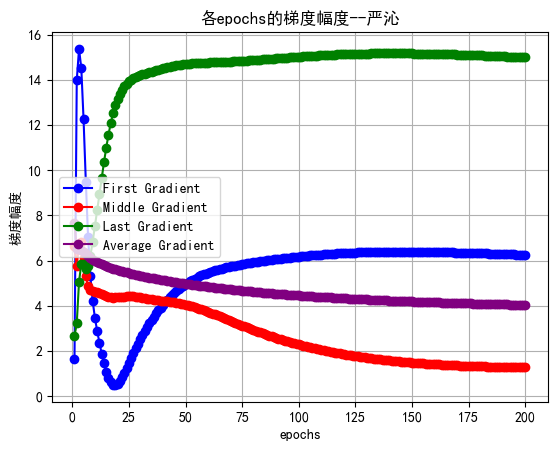

In [21]:
first_gradients =[]
middle_gradients =[]
last_gradients =[]
avg_gradients =[]
for gradients in episode.gradient_magnitudes:
    first_gradients.append(gradients[0])
    middle_gradients.append(gradients[len(gradients)//2])
    last_gradients.append(gradients[len(gradients)-1])
    avg_gradient = 0
    for gradient in gradients:
        avg_gradient += gradient
    avg_gradient /= len(gradients)
    avg_gradients.append(avg_gradient)
# 绘制跨时期的跟踪索引的梯度大小
plt.plot(range(1, len(first_gradients)+1), first_gradients, marker='o', linestyle='-', color='blue', label='First Gradient')
plt.plot(range(1, len(middle_gradients)+1), middle_gradients, marker='o', linestyle='-', color='red', label='Middle Gradient')
plt.plot(range(1, len(last_gradients)+1), last_gradients, marker='o', linestyle='-', color='green', label='Last Gradient')
plt.plot(range(1, len(avg_gradients)+1), avg_gradients, marker='o', linestyle='-', color='purple', label='Average Gradient')

plt.title('各epochs的梯度幅度--严沁')
plt.xlabel('epochs')
plt.ylabel('梯度幅度')
plt.legend()
plt.grid(True)
plt.show()

与之前训练中平均梯度保持不变的情况相比，这张图表展示了平均梯度幅度的下降趋势，这与学习率的衰减相关。这种下降证明了动态学习率的影响，尽管它并不直接包含在梯度跟踪中。第一个、中间的和最后的梯度的收敛也表明，随着训练的进展，模型的更新正变得更加均匀。

## 模型评估

In [22]:
def predict(user_id, item_id, P, Q):
    """
    使用 P 和 Q 的点积预测用户对物品的评分。
    """
    # 将 user_id 和 item_id 转换为索引
    user_idx = user_id - 1  # 如果 user_id/item_id 从 1 开始，则调整索引
    item_idx = item_id - 1
    
    # 计算用户和物品因子的点积以得到预测评分
    rating_pred = np.dot(P[user_idx, :], Q[item_idx, :])
    return rating_pred

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def evaluate_model(dataset, P, Q):
    """
    评估模型在给定数据集上的性能。
    """
    predictions = []
    actuals = []
    
    for index, row in dataset.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        predicted_rating = predict(user_id, item_id, P, Q)
        predictions.append(predicted_rating)
        actuals.append(actual_rating)
    
    # 计算均方根误差（RMSE）和平均绝对误差（MAE）
    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae

In [24]:
# 假设 episode是你的 TrainingEpisode 实例，你可以从中获取 P 和 Q
P_trained = episode.P_all_epochs[-1]  # 最后一个时期的 P 矩阵
Q_trained = episode.Q_all_epochs[-1]  # 最后一个时期的 Q 矩阵

# 在训练数据上评估
train_rmse, train_mae = evaluate_model(train_data, P_trained, Q_trained)
print(f"训练数据 - RMSE: {train_rmse}, MAE: {train_mae}")

# 在测试数据上评估
test_rmse, test_mae = evaluate_model(test_data, P_trained, Q_trained)
print(f"测试数据 - RMSE: {test_rmse}, MAE: {test_mae}")

训练数据 - RMSE: 0.4867923796796248, MAE: 0.3566991947893392
测试数据 - RMSE: 1.4509204964368951, MAE: 1.0509847641927377


正如上面看到，模型在测试集上出现了更大的误差，而训练集误差较小。训练集上RSME=0.48而测试集RMSE=1.45，意味着模型在训练集上过拟合。

### 测试不同的 k 值数量的潜在因子值


In [25]:
user_id = 1  # 示例用户 ID
item_id = 1  # 示例物品（电影）ID
predicted_rating = predict(user_id, item_id, P_trained, Q_trained)
print(f"用户 {user_id} 对物品 {item_id} 的预测评分为: {predicted_rating}")

用户 1 对物品 1 的预测评分为: 3.8679278667895205


将创建另一个类对象，用于跟踪和保存有关我们潜在因子测试运行的信息。这样，当使用的笔记本重新启动时，可以加载它，或者也可以仅仅使用它来更方便地包装跟踪的信息。

In [26]:
import pickle

class NumFactorsTracking:
    def __init__(self):
        self.train_rmses = []
        self.train_maes = []
        self.test_rmses = []
        self.test_maes = []
        self.training_times = []
    
    def add_metrics(self, train_rmse, train_mae, test_rmse, test_mae, training_time):
        self.train_rmses.append(train_rmse)
        self.train_maes.append(train_mae)
        self.test_rmses.append(test_rmse)
        self.test_maes.append(test_mae)
        self.training_times.append(training_time)
    
    def save(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f"Saved tracking data to {filename}")

## 正则化

### 正则化在奇异值分解（SVD）中的应用

正则化是机器学习中用于防止过拟合的技术，通过阻止模型过于复杂化。在用于推荐系统的矩阵分解方法，如奇异值分解（SVD）的背景下，正则化通常被添加到训练期间正在最小化的损失函数中。

以下是使用梯度下降与SVD或类似SVD方法时添加到损失函数的常见正则化项：

#### 正则化的效果

1. **防止过拟合**：正则化有助于防止模型拟合训练数据中的噪声，提高对未见数据（即测试集）的泛化能力。
2. **缩小参数值**：正则化项倾向于将 \( P \) 和 \( Q \) 的值缩小到零，特别是对于那些对解释数据贡献不大的因素，这可以导致一个更加稳健和稳定的模型。
3. **提高模型性能**：通过避免过拟合，模型在训练集和测试集之间的性能不太可能出现大的方差。这可以提高测试集上的预测性能。
4. **选择 \( \lambda \)**：\( \lambda \) 的选择至关重要。如果它太小，它不会有太多效果；如果太大，它可能会过度简化模型，导致欠拟合。通常，通过交叉验证选择 \( \lambda \)。

将正则化添加到您现有的SVD梯度下降实现中涉及更新损失函数和梯度计算，以包含正则化项。关键是找到一个合适的 \( \lambda \) 值，它平衡了模型复杂性与预测性能之间的关系。

将在下面的代码单元格中为train函数添加正则化

In [27]:
def train_model_with_episode(train_data, P, Q, epochs, episode, lr_scheduler, lambda_reg, track_index=0, auto_save=True, auto_save_every_n=10):
    """
    使用梯度下降训练 SVD 模型，并在 TrainingEpisode 对象中跟踪统计数据。
    
    参数：
    - train_data: 训练数据集。
    - P: 用户潜在因子的初始矩阵。
    - Q: 物品潜在因子的初始矩阵。
    - epochs: 训练模型的迭代次数。
    - episode: 用于跟踪训练指标的 TrainingEpisode 实例。
    - track_index: 训练集中要跟踪梯度的用户-物品对的索引。
    
    返回：
    - 最终训练完成的 P 和 Q 矩阵。
    """
    for epoch in range(episode.last_epoch(), epochs):
        learning_rate = lr_scheduler.get_lr(epoch)
        gradient_magnitude=[]
        for index, row in train_data.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            user_idx = user_id - 1
            item_idx = item_id - 1
            
            # 计算预测评分和误差
            pred_rating = np.dot(P[user_idx], Q[item_idx])
            error = actual_rating - pred_rating
            
            # 计算梯度
            P_grad = -2 * error * Q[item_idx] + 2 * lambda_reg * P[user_idx]
            Q_grad = -2 * error * P[user_idx] + 2 * lambda_reg * Q[item_idx]
            
            # 更新 P 和 Q
            P[user_idx] -= learning_rate * P_grad
            Q[item_idx] -= learning_rate * Q_grad
            
            # 存储跟踪索引的梯度大小
            gradient_magnitude.append(np.linalg.norm(P_grad) + np.linalg.norm(Q_grad))
        
        # 计算 MSE 和与前一个时期的差值
        mse = calculate_mse(train_data, P, Q)
        difference = episode.mse_values[-1] - mse if episode.mse_values else 0
        episode.update(P, Q, mse, gradient_magnitude, difference)
        
        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse}, Difference: {difference}, Learning Rate: {learning_rate}")
        if(epoch % auto_save_every_n==0):
            if(auto_save):
                episode.save("auto_saves")

    return P, Q

## 升级以使用偏差

在矩阵分解技术用于推荐系统的背景下，将偏差纳入奇异值分解（SVD）（通常称为SVD++）允许模型考虑与用户和物品相关联的固有偏差。这意味着要考虑到一些用户可能通常比其他用户给出更高或更低的评分（用户偏差），以及一些物品可能通常比其他物品收到更高或更低的评分（物品偏差），而不考虑特定用户和物品之间的交互。

将用户和物品偏差纳入SVD可以显著提高推荐的准确性，通过捕捉用户和物品的整体倾向，而正则化有助于通过惩罚过于复杂的模型来防止过拟合。

In [28]:
def calculate_mse_with_biases(train_data, P, Q, b_u, b_i, mu):
    mse = 0.0
    for index, row in train_data.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        user_idx = user_id - 1
        item_idx = item_id - 1
        predicted_rating = mu + b_u[user_idx] + b_i[item_idx] + np.dot(P[user_idx], Q[item_idx])
        mse += (actual_rating - predicted_rating) ** 2
    mse /= len(train_data)
    return mse


更新预测值的函数

In [29]:
def predict(user_id, item_id, P, Q, b_u, b_i, mu):
    user_idx = user_id - 1
    item_idx = item_id - 1
    rating_pred = mu + b_u[user_idx] + b_i[item_idx] + np.dot(P[user_idx], Q[item_idx])
    return rating_pred


更新评估

In [30]:
def evaluate_model(dataset, P, Q, b_u, b_i, mu):
    predictions = []
    actuals = []
    
    for index, row in dataset.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        predicted_rating = predict(user_id, item_id, P, Q, b_u, b_i, mu)
        predictions.append(predicted_rating)
        actuals.append(actual_rating)
    
    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae


In [31]:
import os
import pickle

class TrainingEpisode:
    def __init__(self, name):
        self.name = name
        self.mse_values = []
        self.gradient_magnitudes = []
        self.P_all_epochs = []
        self.Q_all_epochs = []
        self.b_u_all_epochs = []  # 存储每个时期的用户偏差
        self.b_i_all_epochs = []  # 存储每个时期的商品偏差
        self.differences = []

    def update(self, P, Q, b_u, b_i, mse, gradient_magnitude, difference):
        self.P_all_epochs.append(P.copy())
        self.Q_all_epochs.append(Q.copy())
        self.b_u_all_epochs.append(b_u.copy())  # 添加用户偏差
        self.b_i_all_epochs.append(b_i.copy())  # 添加物品偏差
        self.mse_values.append(mse)
        self.gradient_magnitudes.append(gradient_magnitude)
        self.differences.append(difference)

    def last_epoch(self):
        return len(self.mse_values)

    def save(self, path='./'):
       
        os.makedirs(path, exist_ok=True)
        filepath = os.path.join(path, f"{self.name}.pkl")
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)
        print(f"TrainingEpisode '{self.name}' saved to {filepath}")

    @staticmethod
    def load(name, path='./'):
        filepath = os.path.join(path, f"{name}.pkl")
        if os.path.exists(filepath):
            with open(filepath, 'rb') as file:
                episode = pickle.load(file)
            print(f"TrainingEpisode '{name}' loaded from {filepath}")
            return episode
        else:
            print(f"File {filepath} does not exist.")
            return None


更新训练函数

In [32]:
import numpy as np

def train_model_with_episode(train_data, P, Q, epochs, episode, lr_scheduler, lambda_reg, b_u, b_i, mu, track_index=0, auto_save=True, auto_save_every_n=10):
    num_users = P.shape[0]
    num_items = Q.shape[0]

    for epoch in range(episode.last_epoch(), epochs):
        learning_rate = lr_scheduler.get_lr(epoch)
        gradient_magnitude = []
        
        for index, row in train_data.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            user_idx = user_id - 1  # 如有必要，调整索引
            item_idx = item_id - 1
            
            # 预测带有偏差的评分
            pred_rating = mu + b_u[user_idx] + b_i[item_idx] + np.dot(P[user_idx], Q[item_idx])
            error = actual_rating - pred_rating
            
            # 更新 P, Q, b_u, 和 b_i 的梯度
            P_grad = -2 * error * Q[item_idx] + 2 * lambda_reg * P[user_idx]
            Q_grad = -2 * error * P[user_idx] + 2 * lambda_reg * Q[item_idx]
            b_u_grad = -2 * error + 2 * lambda_reg * b_u[user_idx]
            b_i_grad = -2 * error + 2 * lambda_reg * b_i[item_idx]
            
            # 更新 P, Q, b_u, 和 b_i
            P[user_idx] -= learning_rate * P_grad
            Q[item_idx] -= learning_rate * Q_grad
            b_u[user_idx] -= learning_rate * b_u_grad
            b_i[item_idx] -= learning_rate * b_i_grad
            
            # 存储跟踪索引的梯度大小（可选，如有必要可调整）
            gradient_magnitude.append(np.linalg.norm(P_grad) + np.linalg.norm(Q_grad))
        
        # 可选：计算并更新这个时期的 MSE，包括偏差在内的预测
        mse = calculate_mse_with_biases(train_data, P, Q, b_u, b_i, mu)  # 你需要实现这个函数
        rmse = sqrt(mse) 
        difference = episode.mse_values[-1] - mse if episode.mse_values else 0
        # 调整 'update' 方法以处理偏差（如有必要）
        episode.update(P, Q, b_u, b_i, mse, gradient_magnitude, difference)
        
        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse},RMSE:{sqrt(mse)},Difference: {difference}, Learning Rate: {learning_rate}")
        if epoch % auto_save_every_n == 0 and auto_save:
            episode.save("auto_saves")

    return P, Q, b_u, b_i


现在，让我们使用我们通过各种测试和数据可视化确定的最佳超参数来训练和测试我们的完整SVD模型，包括我们模型中的新偏差。

In [33]:
# 初始化全局偏差 (mu)
mu = train_data['rating'].mean()

# 初始化用户和物品偏差
b_u = np.zeros(num_users)
b_i = np.zeros(num_items)

# 设置训练周期
episode_name = "training_200_epochs_biased_lambda_0.1"
episode = TrainingEpisode(episode_name)

start_P = np.random.normal(0, 0.1, (num_users, num_factors))
start_Q = np.random.normal(0, 0.1, (num_items, num_factors))

# 学习率调度器
lr_scheduler = LearningRateScheduler(initial_lr=0.03, min_lr=0.0001, decay=0.99, epochs_drop=1)

# 训练模型
trained_P, trained_Q, b_u, b_i = train_model_with_episode(train_data, start_P, start_Q, 200, episode, lr_scheduler, lambda_reg=0.1, b_u=b_u, b_i=b_i, mu=mu)

# 保存最终状态
episode.save()

Epoch 1/200, MSE: 0.8718498370127185,RMSE:0.9337289954867625,Difference: 0, Learning Rate: 0.029699999999999997
TrainingEpisode 'training_200_epochs_biased_lambda_0.1' saved to auto_saves\training_200_epochs_biased_lambda_0.1.pkl
Epoch 2/200, MSE: 0.8506367169433378,RMSE:0.9222996893327774,Difference: 0.021213120069380698, Learning Rate: 0.029403
Epoch 3/200, MSE: 0.8196421287744026,RMSE:0.9053408909214267,Difference: 0.03099458816893519, Learning Rate: 0.029108969999999998
Epoch 4/200, MSE: 0.7830478071473929,RMSE:0.8848998853810486,Difference: 0.03659432162700971, Learning Rate: 0.028817880299999998
Epoch 5/200, MSE: 0.7487127933978398,RMSE:0.8652819155615352,Difference: 0.034335013749553056, Learning Rate: 0.028529701496999998
Epoch 6/200, MSE: 0.7139919481863811,RMSE:0.8449804424875058,Difference: 0.034720845211458684, Learning Rate: 0.02824440448203
Epoch 7/200, MSE: 0.6806383173514471,RMSE:0.8250080710826089,Difference: 0.033353630834934034, Learning Rate: 0.027961960437209697
Ep

Epoch 58/200, MSE: 0.47240001176823887,RMSE:0.6873136196586235,Difference: 0.0005215368129626863, Learning Rate: 0.01674798415643591
Epoch 59/200, MSE: 0.4718911345474227,RMSE:0.686943327027363,Difference: 0.0005088772208161618, Learning Rate: 0.016580504314871552
Epoch 60/200, MSE: 0.47139440208433736,RMSE:0.6865816791062352,Difference: 0.0004967324630853476, Learning Rate: 0.016414699271722837
Epoch 61/200, MSE: 0.4709093341354808,RMSE:0.6862283396475847,Difference: 0.0004850679488565546, Learning Rate: 0.016250552279005605
TrainingEpisode 'training_200_epochs_biased_lambda_0.1' saved to auto_saves\training_200_epochs_biased_lambda_0.1.pkl
Epoch 62/200, MSE: 0.47043548192911566,RMSE:0.6858829943431428,Difference: 0.000473852206365144, Learning Rate: 0.01608804675621555
Epoch 63/200, MSE: 0.4699724253850746,RMSE:0.6855453488902646,Difference: 0.0004630565440410517, Learning Rate: 0.015927166288653396
Epoch 64/200, MSE: 0.4695197706307633,RMSE:0.685215127263521,Difference: 0.0004526547

Epoch 115/200, MSE: 0.4551409101698713,RMSE:0.6746413196431651,Difference: 0.0001723720365043313, Learning Rate: 0.00944427519542856
Epoch 116/200, MSE: 0.45497152890781273,RMSE:0.674515773653821,Difference: 0.00016938126205856552, Learning Rate: 0.009349832443474275
Epoch 117/200, MSE: 0.45480508480395176,RMSE:0.6743923819290605,Difference: 0.0001664441038609632, Learning Rate: 0.009256334119039531
Epoch 118/200, MSE: 0.4546415254196306,RMSE:0.6742711067661364,Difference: 0.0001635593843211658, Learning Rate: 0.009163770777849137
Epoch 119/200, MSE: 0.45448079945300013,RMSE:0.6741519112581378,Difference: 0.00016072596663047056, Learning Rate: 0.009072133070070645
Epoch 120/200, MSE: 0.4543228567002071,RMSE:0.6740347592670627,Difference: 0.00015794275279301662, Learning Rate: 0.008981411739369938
Epoch 121/200, MSE: 0.45416764801868903,RMSE:0.6739196153983715,Difference: 0.00015520868151808198, Learning Rate: 0.008891597621976239
TrainingEpisode 'training_200_epochs_biased_lambda_0.1' 

TrainingEpisode 'training_200_epochs_biased_lambda_0.1' saved to auto_saves\training_200_epochs_biased_lambda_0.1.pkl
Epoch 172/200, MSE: 0.44897530922633505,RMSE:0.6700561985582516,Difference: 6.348408780615378e-05, Learning Rate: 0.005325675802762902
Epoch 173/200, MSE: 0.44891293675546384,RMSE:0.670009654225567,Difference: 6.237247087120812e-05, Learning Rate: 0.005272419044735273
Epoch 174/200, MSE: 0.44885165667850313,RMSE:0.6699639219230414,Difference: 6.128007696071247e-05, Learning Rate: 0.00521969485428792
Epoch 175/200, MSE: 0.4487914500879869,RMSE:0.6699189877052202,Difference: 6.02065905162541e-05, Learning Rate: 0.0051674979057450415
Epoch 176/200, MSE: 0.44873229838704065,RMSE:0.6698748378518488,Difference: 5.9151700946225017e-05, Learning Rate: 0.00511582292668759
Epoch 177/200, MSE: 0.44867418328453057,RMSE:0.6698314588644897,Difference: 5.811510251008123e-05, Learning Rate: 0.005064664697420715
Epoch 178/200, MSE: 0.44861708679032825,RMSE:0.6697888374632174,Difference:

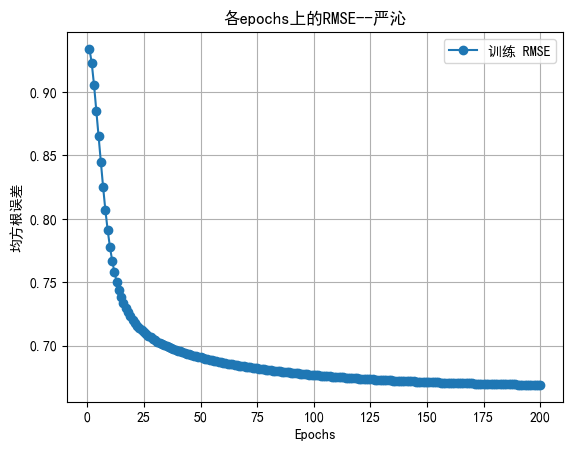

In [34]:
import matplotlib.pyplot as plt
import numpy as np  # 导入numpy库来使用sqrt函数

# 设置字体为黑体，以支持中文字符
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 现在，绘制均方根误差（RMSE）值
# 使用列表推导式计算所有MSE值的平方根
rms_values = [np.sqrt(mse) for mse in episode.mse_values]
plt.plot(range(1, len(rms_values) + 1), rms_values, marker='o', label='训练 RMSE')

# 更新标题和标签以反映RMSE而不是MSE
plt.title('各epochs上的RMSE--严沁')  # 使用“Epochs”以符合机器学习领域的术语
plt.xlabel('Epochs')  # X轴标签通常使用英文术语
plt.ylabel('均方根误差')  # Y轴标签应反映RMSE

plt.legend()
plt.grid(True)
plt.show()

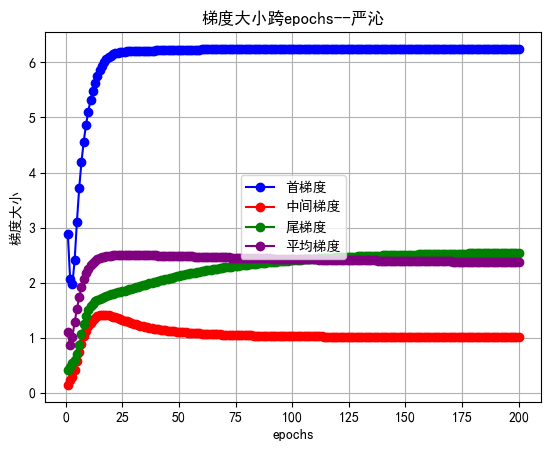

In [35]:
first_gradients = []
middle_gradients = []
last_gradients = []
avg_gradients = []
for gradients in episode.gradient_magnitudes:
    first_gradients.append(gradients[0])  # 将每个梯度序列的第一个梯度值添加到first_gradients列表中
    middle_gradients.append(gradients[len(gradients)//2])  # 将每个梯度序列的中间梯度值添加到middle_gradients列表中
    last_gradients.append(gradients[len(gradients)-1])  # 将每个梯度序列的最后一个梯度值添加到last_gradients列表中
    avg_gradient = 0
    for gradient in gradients:
        avg_gradient += gradient
    avg_gradient /= len(gradients)  # 计算每个梯度序列的平均梯度值，并添加到avg_gradients列表中
    avg_gradients.append(avg_gradient)
# 绘制在各个epoch中跟踪的索引的梯度大小
plt.plot(range(1, len(first_gradients)+1), first_gradients, marker='o', linestyle='-', color='blue', label='首梯度')
plt.plot(range(1, len(middle_gradients)+1), middle_gradients, marker='o', linestyle='-', color='red', label='中间梯度')
plt.plot(range(1, len(last_gradients)+1), last_gradients, marker='o', linestyle='-', color='green', label='尾梯度')
plt.plot(range(1, len(avg_gradients)+1), avg_gradients, marker='o', linestyle='-', color='purple', label='平均梯度')

plt.title('梯度大小跨epochs--严沁')  # 标题：梯度大小跨Epochs
plt.xlabel('epochs')  # X轴标签：Epoch
plt.ylabel('梯度大小')  # Y轴标签：梯度大小
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格
plt.show()  # 显示图表

In [36]:
# 假设episode_B是你的TrainingEpisode实例，你可以从中获取P和Q
P_trained = episode.P_all_epochs[-1]  # 最后一个epoch的P矩阵
Q_trained = episode.Q_all_epochs[-1]  # 最后一个epoch的Q矩阵

# 在训练数据上进行评估
train_rmse, train_mae = evaluate_model(train_data, trained_P, trained_Q, b_u, b_i, mu)
print(f"训练数据 - RMSE: {train_rmse}, MAE: {train_mae}")

# 在测试数据上进行评估
test_rmse, test_mae = evaluate_model(test_data, trained_P, trained_Q, b_u, b_i, mu)
print(f"测试数据 - RMSE: {test_rmse}, MAE: {test_mae}")

训练数据 - RMSE: 0.6690185187685163, MAE: 0.5266012886180857
测试数据 - RMSE: 0.9197918286963758, MAE: 0.722712195217945


<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于皮尔逊相关系数的用户协同过滤算法--蔡胜炜</b>
    </font>
</p>

<font color="black" face="宋体" size="3">
    1.编写了皮尔逊相关系数计算函数。<br>
    2.实现了基于皮尔逊相关系数和基于余弦相似度的用户协同过滤算法。<br>
    3.探索了k值（考虑的最近邻居数量）对算法性能的影响
</font>

<font color="black" face="雅黑" size="5"><b>导入库</b></font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

<font color="black" face="雅黑" size="5"><b>导入数据</b></font>

In [2]:
base = pd.read_csv('C:/Users/86188/Desktop/ml-100k/u1.base', sep='\t', names = ["user_id", "movie_id", "ratings", "timestamp"])
base

,user_id,movie_id,ratings,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [3]:
test = pd.read_csv('C:/Users/86188/Desktop/ml-100k/u1.test', sep='\t', names = ["user_id", "movie_id", "ratings", "timestamp"])
test

,user_id,movie_id,ratings,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [4]:
matrix_base = base.pivot(values='ratings', index='user_id', columns='movie_id')
matrix_base

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,NaN,4.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
matrix_test = test.pivot(values='ratings', index='user_id', columns='movie_id')
matrix_test

movie_id,1,2,3,4,5,6,7,8,9,10,...,1555,1557,1561,1562,1563,1565,1578,1582,1586,1591
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color="black" face="雅黑" size="5"><b>训练集和测试集</b></font>

In [38]:
#提取出在训练集和测试集中都存在的值的函数
def filterData(train,test):
    # 找到在训练集和测试集中都存在的索引和列
    common_users = set(train['user_id']).intersection(test['user_id'])
    common_movies = set(train['movie_id']).intersection(test['movie_id'])

    # 提取出在训练集和测试集中都存在的 user_id 和 movie_id 的评分
    filtered_train = train[(train['user_id'].isin(common_users)) & (train['movie_id'].isin(common_movies))]
    filtered_test = test[(test['user_id'].isin(common_users)) & (test['movie_id'].isin(common_movies))]

    # 根据筛选后的数据创建用户-电影矩阵
    user_item_matrix_train = filtered_train.pivot(index='user_id', columns='movie_id', values='ratings').fillna(np.nan)
    user_item_matrix_train1 = user_item_matrix_train.values
    user_item_matrix_test = filtered_test.pivot(index='user_id', columns='movie_id', values='ratings').fillna(0)
    user_item_matrix_test1 = user_item_matrix_test.values

    return user_item_matrix_train,user_item_matrix_test1

In [39]:
train1, test1 = filterData(base, test)

In [44]:
train1

movie_id,1,2,3,4,5,6,7,8,9,10,...,1519,1521,1522,1524,1529,1530,1531,1534,1550,1591
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,NaN,4.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,4.0,NaN,NaN,4.0,NaN,NaN,4.0,5.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,4.0,NaN,2.0,NaN,NaN,NaN,5.0,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
test1.shape

(459, 1378)

In [42]:
test1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
Utility_matrix = train1.T.corr()
Utility_matrix = Utility_matrix.subtract(train1.mean(axis=1), axis=0)
Utility_matrix = Utility_matrix.values.reshape(-1,1)

In [12]:
Utility_matrix

array([[-2.68148148],
       [-3.41180154],
       [-3.18148148],
       ...,
       [-3.6564947 ],
       [-4.66939905],
       [-2.96875   ]])

<font color="black" face="雅黑" size="5"><b>皮尔逊相关系数</b></font>

In [13]:
def Pearson(data):
  pearson = np.zeros((data.shape[0],data.shape[0])) #创建一个完全由零构成的相关矩阵
  data = data.values
  column_means = np.nanmean(data, axis = 0)

  for i in range(data.shape[0]):
    for k in range(i+1,data.shape[0]): #遍历所有用户以找到与用户 i 最接近的邻居
      tu = 0
      mau1 = 0
      mau2 = 0
      for j in range(data.shape[1]): #遍历用户 i 的所有电影和 k
        if (not np.isnan(data[i,j])) and (not np.isnan(data[k,j])): #如果两个用户都对同一项进行了评分，则计算相关值
          tu = tu + (data[k,j]-column_means[k])*(data[i,j]-column_means[i])
          mau1 = mau1+((data[k,j]-column_means[k])**2)
          mau2 = mau2+((data[i,j]-column_means[i])**2)
      if mau1 != 0 and mau2 != 0:
          pearson[i, k] = tu / np.sqrt(mau1 * mau2)   #填写相关值到零矩阵中
      else:
          pearson[i, k] = 0  # 为了避免除以零错误
      pearson[k, i] = pearson[i, k] # 创建对称部分
  return pearson


In [14]:
Utility_matrix = Pearson(train1)

In [15]:
def predict_rating(data,test,pearson1,k):
  data1 = data.copy()
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      pearson = pearson1.copy()
      if (test[i,j]!=0):  
        for l in range(data.shape[0]): #从没有对待预测评分 data[i,j] 的邻居中进行筛选
          if np.isnan(data[l,j]):
            pearson[i,l]= -1   #将相似度设置为 -1 以排除它们。最好将其设置为 np.nan，因为如果没有邻居，则仍将考虑 l 作为 i 的邻居
            pearson[l,i] = -1
        nearest_neighbors_indices = np.argsort(pearson[i], axis=0)[-k:]# 获取与用户 i 最接近的邻居
        nearest_neighbors_similarities = pearson[i, nearest_neighbors_indices] # 包含最近邻居的相关度的数组
        nearest_neighbors_ratings = data[nearest_neighbors_indices,j] #获取与用户 j 最接近的邻居的评分数值
        if len(nearest_neighbors_ratings) > 0: #进行检查以确保至少有一个邻居存在
          denominator = np.sum(np.abs(nearest_neighbors_similarities))
          if (np.isnan(nearest_neighbors_ratings).any()) or (np.isnan(nearest_neighbors_similarities).any() or (denominator ==0)): #进行检查以处理 NaN 值
            data1[i, j] = test[i,j] #设定使得均方误差计算最佳的值
          else:
            predicted_ratings = np.sum(nearest_neighbors_ratings * nearest_neighbors_similarities) / np.sum(np.abs(nearest_neighbors_similarities))
            data1[i, j] = predicted_ratings

  return data1


In [16]:
user_anime_pred = predict_rating(train1.values, test1, Utility_matrix, 10)

In [17]:
user_anime_pred 

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 4., nan,  2., ..., nan, nan, nan],
       [ 2., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

<font color="black" face="雅黑" size="5"><b>性能评估指标</b></font>

* **RMSE（均方根误差）**  
  均方根误差。值越低表示准确度越好。
  $$
  \text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}(r_{ui} - \hat{r}_{ui})^2}.
  $$

In [18]:
def RMSE(matrix_train,matrix_test):
  y_true = []
  y_pred = []
  for i in range(matrix_train.shape[0]):
    for j in range(matrix_train.shape[1]):
      if (matrix_test[i,j]!=0) and (matrix_test[i,j]!=matrix_train[i,j]):
        y_true.append(matrix_test[i,j])
        y_pred.append(matrix_train[i,j])

  min = np.min(y_pred)
  max = np.max(y_pred)
  normalized_predicted = 1 + (y_pred - min) * (5 - 1) / (max - min)
  
  rmse = np.sqrt(np.mean((np.array(y_true) - np.array(normalized_predicted))**2))
  return rmse

In [19]:
rmse = RMSE(user_anime_pred, test1)
print(rmse)

1.2705912893677165


<font color="black" face="雅黑" size="5"><b>余弦相似性</b></font>

In [20]:
Utility_matrix_cosine = cosine_similarity(train1.fillna(0))

In [21]:
user_anime_pred = predict_rating(train1.values, test1, Utility_matrix_cosine, 10)

In [22]:
rmse = RMSE(user_anime_pred, test1)
print(rmse)

1.113021672207545


<font color="black" face="雅黑" size="5"><b>k值对模型影响</b></font>

In [28]:
number_k = [5,10,15,20,25,30]
Pearson_rmse_values = [ ]
Similarity_rmse_values = [ ]
print("Pearson")
for k in number_k:
    user_anime_pred = predict_rating(train1.values, test1, Utility_matrix, k)
    rmse = RMSE(user_anime_pred, test1)
    print("k = ", k , "RMSE : ", rmse)
    Pearson_rmse_values.append(rmse)

print("Cosine Similarity")
for k in number_k:
    user_anime_pred = predict_rating(train1.values, test1, Utility_matrix_cosine, k)
    rmse = RMSE(user_anime_pred, test1)
    print("k = ", k , "RMSE : ", rmse)
    Similarity_rmse_values.append(rmse)

Pearson
k =  5 RMSE :  1.355777624350517
k =  10 RMSE :  1.2705912893677165
k =  15 RMSE :  1.2620597385226093
k =  20 RMSE :  1.234809294445823
k =  25 RMSE :  1.228786142832564
k =  30 RMSE :  1.2256019607134714
Cosine Similarity
k =  5 RMSE :  1.1732193012093024
k =  10 RMSE :  1.113021672207545
k =  15 RMSE :  1.1303432064038064
k =  20 RMSE :  1.1460241825407165
k =  25 RMSE :  1.1350013292613772
k =  30 RMSE :  1.10656733220825


<font color="black" face="雅黑" size="5"><b>结果可视化</b></font>

<font color="black" face="雅黑" size="4"><b>绘制Pearson和Cosine Similarity的RMSE折线图</b></font>

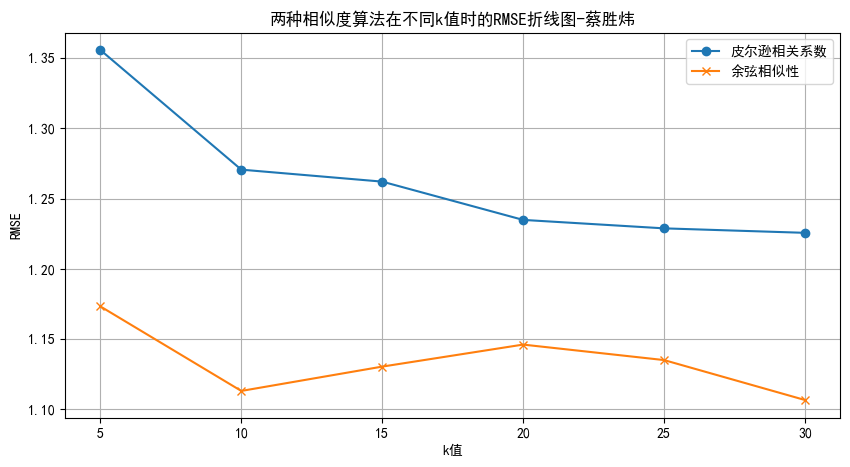

In [53]:
number_k = [5,10,15,20,25,30]
plt.figure(figsize=(10, 5))
# 绘制Pearson的RMSE折线图
plt.plot(number_k, Pearson_rmse_values, label='皮尔逊相关系数', marker='o')
# 绘制Cosine Similarity的RMSE折线图
plt.plot(number_k, Similarity_rmse_values, label='余弦相似性', marker='x')
plt.legend()
plt.title('两种相似度算法在不同k值时的RMSE折线图-蔡胜炜')
plt.xlabel('k值')
plt.ylabel('RMSE')
plt.xticks(number_k)
plt.grid(True)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.show()

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于多层感知机的电影推荐算法实现--严沁</b>
    </font>
</p>

<font color="black" face="宋体" size="3">
    1.利用Sequential构建多层感知机。<br>
    2.模型训练与评估。<br>
    3.对每个用户打印top10推荐
</font>

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# 加载用户评估数据
ratings_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv('C:/Users/Yan/Desktop/Big-homework/ml-100k/u.data', sep='\t', names=ratings_cols)

# 数据预处理
user_movie_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
X = np.array(user_movie_matrix.values)  # 用户-电影矩阵
y = X[:, 1:]  # 电影的评分（需要预测的）
X = X[:, :-1]  # 电影评分序列（模型的输入）

In [3]:
import pandas as pd

# 电影数据文件u.item的路径
file_path = "C:/Users/Yan/Desktop/Big-homework/ml-100k/u.item"

# 定义文件u.item中需要加载的列
movie_cols = ['MovieID', 'Title']

# 从文件u.item中加载电影数据
movies = pd.read_csv(file_path, sep='|', encoding='latin-1', names=movie_cols, usecols=[0, 1])

# 打印movies数据框的前几行，以验证数据是否正确加载
print(movies.head())

   MovieID              Title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)


In [4]:
# 将数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 显示数据集的维度
print("训练集的维度:", X_train.shape, y_train.shape)
print("测试集的维度:", X_test.shape, y_test.shape)

训练集的维度: (754, 1681) (754, 1681)
测试集的维度: (189, 1681) (189, 1681)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 定义模型架构，包含Dropout层
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # 添加一个Dropout层，丢弃率为0.5
    Dense(128, activation='relu'),
    Dropout(0.5),  # 再次添加Dropout层，丢弃率为0.5
    Dense(64, activation='relu'),
    Dropout(0.5),  # 添加第三个Dropout层，丢弃率为0.5
    Dense(32, activation='relu'),
    Dropout(0.5),  # 添加第四个Dropout层，丢弃率为0.5
    Dense(X_train.shape[1])  # 输出节点数等于电影的数量
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 显示模型摘要
model.summary()

D:\anoconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         430,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1681)                │          55,473 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 529,297 (2.02 MB)

 Trainable params: 529,297 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 使用新修改训练模型
history = model.fit(
    X_train,  # 训练输入数据
    y_train,  # 训练输出标签
    epochs=100,  # 增加训练周期数
    batch_size=64,  # 增加批量大小
    validation_data=(X_test, y_test)  # 验证数据
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9314 - val_loss: 0.8333
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8246 - val_loss: 0.7975
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7710 - val_loss: 0.7441
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7378 - val_loss: 0.7166
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6996 - val_loss: 0.7072
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6834 - val_loss: 0.7212
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6889 - val_loss: 0.7147
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6497 - val_loss: 0.6973
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6539 - val_loss: 0.7201
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6580 - val_loss: 0.7120
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6150 - val_loss: 0.7124
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [7]:
# 在测试数据上评估模型
test_loss = model.evaluate(X_test, y_test)
print("测试损失:", test_loss)

# 预测测试数据中电影的评分
y_pred = model.predict(X_test)

# 计算测试准确率（测试精度）
test_accuracy = np.mean(np.abs(y_pred - y_test) < 0.5)
print("测试准确率:", test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6115 
测试损失: 0.6499549150466919
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
测试准确率: 0.8968301181269652


In [8]:
import numpy as np

# 假设 y_test 和 y_pred 是 numpy 数组，包含了实际值和预测值
# 计算每个预测值与实际值之差的平方
mse = np.mean((y_test - y_pred) ** 2)

# 计算均方根误差
rmse = np.sqrt(mse)

print("Root Mean Square Error (RMSE):", rmse)


# 假设 y_test 是实际值的数组，y_pred 是预测值的数组
# 首先计算每个预测值与实际值之差
differences = y_test - y_pred

# 然后计算这些差值的平方
squared_differences = differences ** 2

# 最后计算所有平方差值的平均数，即 MSE
mse = np.mean(squared_differences)

print("Mean Squared Error (MSE):", mse)

Root Mean Square Error (RMSE): 0.8050593290467221
Mean Squared Error (MSE): 0.6481205232851582


In [9]:
# 预测测试数据中电影的评分
y_pred = model.predict(X_test)

# 函数：为每个用户获取评分最高的电影的索引
def get_top_recommendations(user_index, num_recommendations=3):
    user_ratings = y_pred[user_index]  # 获取指定用户的预测评分
    top_movie_indices = np.argsort(user_ratings)[::-1][:num_recommendations]  # 评分最高的电影索引
    return top_movie_indices

# 定义文件u.item中需要加载的列
movie_cols = ['MovieID', 'Title']

# 从文件u.item中加载电影数据
movies = pd.read_csv(file_path, sep='|', encoding='latin-1', names=movie_cols, usecols=[0, 1])

# 打印测试集中每个用户的推荐电影
for i in range(len(X_test)):
    user_id = i + 1  # 用户ID从1开始
    top_recommendations_indices = get_top_recommendations(i)
    print("用户", user_id, "的前10个推荐：")
    for movie_index in top_recommendations_indices:
        movie_id = movie_index + 1  # 电影ID从1开始
        movie_title = movies[movies['MovieID'] == movie_id]['Title'].values[0]
        print(movie_title)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
用户 1 的前10个推荐：
I.Q. (1994)
Snow White and the Seven Dwarfs (1937)
Secrets & Lies (1996)
用户 2 的前10个推荐：
Hoodlum (1997)
Secrets & Lies (1996)
Men in Black (1997)
用户 3 的前10个推荐：
Hoodlum (1997)
Men in Black (1997)
Secrets & Lies (1996)
用户 4 的前10个推荐：
I.Q. (1994)
Apocalypse Now (1979)
Men in Black (1997)
用户 5 的前10个推荐：
Secrets & Lies (1996)
I.Q. (1994)
Snow White and the Seven Dwarfs (1937)
用户 6 的前10个推荐：
Men in Black (1997)
Hoodlum (1997)
Secrets & Lies (1996)
用户 7 的前10个推荐：
Men in Black (1997)
Hoodlum (1997)
I.Q. (1994)
用户 8 的前10个推荐：
Hoodlum (1997)
Men in Black (1997)
Secrets & Lies (1996)
用户 9 的前10个推荐：
I.Q. (1994)
Apocalypse Now (1979)
Striptease (1996)
用户 10 的前10个推荐：
Men in Black (1997)
Hoodlum (1997)
I.Q. (1994)
用户 11 的前10个推荐：
Men in Black (1997)
Hoodlum (1997)
I.Q. (1994)
用户 12 的前10个推荐：
I.Q. (1994)
Snow White and the Seven Dwarfs (1937)
Princess Bride, The (1987)
用户 13 的前10个推荐：
I.Q. (1994)
Men in Black (1997)
Hoodlum (1997)
用户 14 的前10个推荐：
Secrets & Lies 

用户 111 的前10个推荐：
I.Q. (1994)
Secrets & Lies (1996)
Snow White and the Seven Dwarfs (1937)
用户 112 的前10个推荐：
I.Q. (1994)
Secrets & Lies (1996)
Snow White and the Seven Dwarfs (1937)
用户 113 的前10个推荐：
I.Q. (1994)
Snow White and the Seven Dwarfs (1937)
Spitfire Grill, The (1996)
用户 114 的前10个推荐：
Men in Black (1997)
I.Q. (1994)
Hoodlum (1997)
用户 115 的前10个推荐：
I.Q. (1994)
Apocalypse Now (1979)
Men in Black (1997)
用户 116 的前10个推荐：
I.Q. (1994)
Apocalypse Now (1979)
Princess Bride, The (1987)
用户 117 的前10个推荐：
I.Q. (1994)
Snow White and the Seven Dwarfs (1937)
Spitfire Grill, The (1996)
用户 118 的前10个推荐：
I.Q. (1994)
Men in Black (1997)
Snow White and the Seven Dwarfs (1937)
用户 119 的前10个推荐：
Secrets & Lies (1996)
I.Q. (1994)
Snow White and the Seven Dwarfs (1937)
用户 120 的前10个推荐：
I.Q. (1994)
Apocalypse Now (1979)
Snow White and the Seven Dwarfs (1937)
用户 121 的前10个推荐：
Secrets & Lies (1996)
I.Q. (1994)
Snow White and the Seven Dwarfs (1937)
用户 122 的前10个推荐：
I.Q. (1994)
Apocalypse Now (1979)
Princess Bride, The 

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于玻尔兹曼机的电影推荐算法--王帅</b>
    </font>
</p>

<font color="black" face="雅黑" size="5"><b>导入库</b></font>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt

<font color="black" face="雅黑" size="5"><b>导入数据集，分为训练集（80%）和测试集（20%）</b></font>

In [2]:
#基础数据文件中的训练集，该数据文件使用制表符分隔符
#数据集的80%
training_set = pd.read_csv(
    'C:/Users/wangshuai/Desktop/机器学习大作业/archive/ml-100k/u1.base',
    delimiter = '\t'
)
#测试数据文件中的测试集，该数据文件使用制表符分隔符
#数据集的20%
test_set = pd.read_csv(
    'C:/Users/wangshuai/Desktop/机器学习大作业/archive/ml-100k/u1.test',
        delimiter = '\t'
)

In [3]:
#第一列：userID
#第二列：movieID
#第三列：评级
#第四列：时间戳
print(training_set)

         1   1.1  5  874965758
0        1     2  3  876893171
1        1     3  4  878542960
2        1     4  3  876893119
3        1     5  3  889751712
4        1     7  4  875071561
...    ...   ... ..        ...
79994  943  1067  2  875501756
79995  943  1074  4  888640250
79996  943  1188  3  888640250
79997  943  1228  3  888640275
79998  943  1330  3  888692465

[79999 rows x 4 columns]


In [4]:
#第一列：userID
#第二列：movieID
#第三列：评级
#第四列：时间戳
print(test_set)

         1     6  5  887431973
0        1    10  3  875693118
1        1    12  5  878542960
2        1    14  5  874965706
3        1    17  3  875073198
4        1    20  4  887431883
...    ...   ... ..        ...
19994  458   648  4  886395899
19995  458  1101  4  886397931
19996  459   934  3  879563639
19997  460    10  3  882912371
19998  462   682  5  886365231

[19999 rows x 4 columns]


<font color="black" face="雅黑" size="5"><b>将pandas数据帧转换为numpy数组</b></font>

In [5]:
#将数据帧转换为整数数组
training_set = np.array(training_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [6]:
print(training_set)

[[        1         2         3 876893171]
 [        1         3         4 878542960]
 [        1         4         3 876893119]
 ...
 [      943      1188         3 888640250]
 [      943      1228         3 888640275]
 [      943      1330         3 888692465]]


In [7]:
print(test_set)

[[        1        10         3 875693118]
 [        1        12         5 878542960]
 [        1        14         5 874965706]
 ...
 [      459       934         3 879563639]
 [      460        10         3 882912371]
 [      462       682         5 886365231]]


<font color="black" face="雅黑" size="5"><b>获取用户和电影的数量</b></font>

In [8]:
#首先得到训练集中的最大userID和测试集中的最大userID，然后得到这两者之间的最大值
#之后把它转换成一个整数
num_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
#对movieID同样处理
num_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [9]:
print(num_users)
print(num_movies)

943
1682


<font color="black" face="雅黑" size="5"><b>将数据转换为一个数组，其中用户在行，电影在列</b></font>

In [10]:
#用于创造一个列表，为每部电影创建一个用户列表和他们的评分
#如果没有该用户/电影对的评分，将使用0的评分。
def convert(data):
    # 初始化一个空列表，用于存放用户列表及其评分的容器
    new_data = []
    # 获取每个用户的评分，对于1到用户数量范围内的每个用户ID
    for user_id in range(1, num_users + 1):
        # 获取每个评分的电影ID和评分
        # 对于当前循环中的用户，获取电影ID和评分
        movie_ids = data[:, 1][data[:, 0] == user_id]
        user_ratings = data[:, 2][data[:, 0] == user_id]
        # 初始化一个全零的列表作为所有电影的评分，然后用适当的评分替换这些零
        all_movie_ratings = np.zeros(num_movies)
        # 用用户的评分替换零评分
        all_movie_ratings[movie_ids - 1] = user_ratings# movie_ids 是这个用户评分的所有电影的列表，movie_ids 从1开始，所以需要使用 movie_ids - 1 以便索引从0开始
        # 将当前用户的评分添加到新列表中
        new_data.append(list(all_movie_ratings)) 
    # 返回新列表
    return new_data

In [11]:
# 用上面的函数转换训练集和测试集
training_set_converted = convert(training_set)
test_set_converted = convert(test_set)

<font color="black" face="雅黑" size="5"><b>将数据转换为Torch张量</b></font>

In [12]:
# 用torch库来创建浮点数的张量
training_set_tensor = torch.FloatTensor(training_set_converted)
test_set_tensor = torch.FloatTensor(test_set_converted)

In [13]:
print(training_set_tensor)# 打印一下

tensor([[0., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])


In [14]:
print(test_set_tensor)# 打印一下

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


<font color="black" face="雅黑" size="3"><b>将评分转换为二进制评分1（喜欢）或0（不喜欢）

In [15]:
# 创建一个函数来重新格式化张量中的数据，以反映二进制评分：1（喜欢）和0（不喜欢）
def binary_format(tensor):
    # 将数据集中所有的占位符0值更改为没有意义的其他值：-1，因为要使用0值来表示重要的信息
    tensor[tensor == 0] = -1 # 在训练集中所有等于0的值，替换为-1
    # 将评分值1和2替换为二进制值0。这表示用户不喜欢那部电影
    tensor[tensor == 1] = 0
    tensor[tensor == 2] = 0
    # 将评分值3、4和5替换为二进制值1。这表示用户喜欢那部电影
    tensor[tensor >= 3] = 1
    # 返回处理后的张量
    return tensor

In [16]:
# 重新格式化训练集和测试集
training_set_tensor_binary = binary_format(training_set_tensor)
test_set_tensor_binary = binary_format(test_set_tensor)

In [17]:
print(training_set_tensor_binary)

tensor([[-1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1.,  1., -1.,  ..., -1., -1., -1.]])


In [18]:
print(test_set_tensor_binary)

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])


<font color="black" face="雅黑" size="5"><b>创建神经网络的架构</b></font>

In [19]:
# 定义一个类来实现受限玻尔兹曼机（RBM）
class RBM():
    # init 函数都以 'self' 参数开始，nv 是可见节点的数量，nh 是隐藏节点的数量
    def __init__(self, nv, nh):
        # 需要初始化 RBM 的权重和偏置的值
        # 首先是权重。放在一个名为'Weights'的PyTorch张量中，属于RBM对象
        self.Weights = torch.randn(nh, nv)# torch.randn(dim1, dim2) 用均值为 0，方差为 1 的正态分布中的随机数字初始化形状为 dim1 X dim2 的张量
        
        # 为隐藏节点的偏置做同样的操作，使用bias_h来保存隐藏节点的偏置
        self.bias_hidden = torch.randn(1, nh)# 这个的形状需要是一个 2D 张量，在形状中放入 '1' 作为占位符来获取第二个维度
        
        # 现在为可见节点的偏置做同样的事情
        self.bias_visible = torch.randn(1, nv)
        
    # 还需要计算给定可见节点时隐藏节点的概率
    # sample_h()函数用于返回隐藏节点的一个样本
    # 我传递self参数，这样就可以访问属于RBM对象的Weights、bias_hidden和bias_visible变量
    # x参数是可见节点的向量，也就是输入的观测值
    def sample_h(self, x):
        # 首先，计算给定可见节点值时隐藏节点等于 1 的概率
        # wx是输入观测值和 RBM 的权重的乘积
        # torch.mm执行矩阵乘法
        # Weights 矩阵默认的形状不正确，需要在执行矩阵乘法之前转置它
        # 使用 self.Weights.t() 在计算之前转置权重矩阵。这样就不会对 self.Weights 造成永久性的变换
        
        wx = torch.mm(x, self.Weights.t())
        
        # 现在定义的激活函数：wx加上偏置
        # 为了加上偏置，还需要添加一个维度
        
        activation = wx + self.bias_hidden.expand_as(wx) # self.bias_hidden.expand_as(wx) 使偏置具有与 wx 相同的维度
        
        # 现在计算给定可见节点(x)的值时隐藏节点将被激活的概率
        # p_h_given_v：给定v的h的概率
        # p_h_given_v：是一个大小为nh的概率向量。例如：如果有100个隐藏节点，就会有100个概率。
        
        p_h_given_v = torch.sigmoid(activation)
        
        # torch.bernoulli(p_h_given_v)将返回一个由0和1组成的向量。这个向量的大小等于隐藏节点的数量。
        # 对于每个隐藏节点，根据 p_h_given_v，该隐藏节点被激活的机会。
        # 对于每个隐藏节点，会生成一个介于 0 和 1 之间的随机数。如果这个数字小于该隐藏节点被激活的概率（由p_h_given_v定义），那么该节点得到0。否则，它得到1。
        # 这为程序提供了一个概率性的采样，说明给定这个观测的可见节点值时，RBM中的隐藏节点可能如何被激活。
        # 这也被称为伯努利采样，是正在使用的函数的名称。
        
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    # 还需要一个函数来计算给定隐藏节点的伯努利采样时，可见节点会被激活的概率
    # 这将是最终用来预测用户是否会喜欢他们尚未看过的电影
    # 对于sample_v()，y 将是由上面 sample_h() 函数返回的 torch.bernoulli(p_h_given_v) 向量
    # y = 隐藏节点的值
    
    def sample_v(self, y):
        # torch.mm 执行矩阵乘法
        # Weights 矩阵
        wy = torch.mm(y, self.Weights)
        
        # 定义激活函数
        # wy 加上可见节点的偏置，为了加上偏置，需要添加一个维度
    
        activation = wy + self.bias_visible.expand_as(wy) # self.bias_visible.expand_as(wy) 使偏置具有与 wy 相同的维度
        
        # 现在计算给定隐藏节点 (y) 的值时可见节点将被激活的概率
        # p_v_given_h："给定 h 的 v 的概率"
        # p_v_given_h：一个大小为 nv 的概率向量。
        
        p_v_given_h = torch.sigmoid(activation)
        
        # torch.bernoulli(p_v_given_h) 将返回一个由 0 和 1 组成的向量。这个向量的大小等于可见节点的数量。
        # 对于每个可见节点，根据 p_v_given_h，该可见节点被激活的机会。
        # 对于每个隐藏节点，会生成一个介于 0 和 1 之间的随机数。如果这个数字小于该隐藏节点被激活的概率（由 p_v_given_h 定义），那么该节点得到 0。否则，它得到 1。
        
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    # train ：用于更新 RBM 中的权重和偏置
    # 'v0' ：输入向量。当前的观测值。进入可见节点的值。
    # 'vk' ：在 'k' 次采样后可见节点的值向量。
    # 'ph0' ：在迭代 0 时给定 v0 的隐藏节点为 1 的概率向量
    # 'phk' ：在迭代 'k' 时给定 vk 的隐藏节点为 1 的概率向量
    
    def train(self, v0, vk, ph0, phk):
        # 更新权重
        # 更新将基于开始的位置和 'k' 次迭代后结束的位置之间的差异
        # torch.mm(v0.t(), ph0) 是可见节点的起始值和基于这些值隐藏节点被激活的初始概率的矩阵乘法。
        # torch.mm(vk.t(), phk) 是 'k' 次迭代后可见节点的值和基于这些值隐藏节点被激活的概率的矩阵乘法。
        # 这两个值之间的差异可以被认为是权重的误差，因此这将是更新权重的量。
        # 从 torch.mm(v0.t(), ph0) 减去 torch.mm(vk.t(), phk) 后，必须将结果转置回正确的格式以加到 self.Weights 上
        
        self.Weights += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        
        # 接下来，更新可见节点的偏置
        # 如果只做 self.bias_visible += v0 - vk，会丢失张量的形状
        # 所以使用 torch.sum((v0 - vk), 0) 来保持张量的形状而不改变任何东西（添加 0）
        # v0 是可见节点的初始值，vk 是 'k' 次迭代后可见节点的值。
        # 这两个之间的差异可以被认为是可见节点偏置的误差，
        # 因此将通过这个量更新可见节点的偏置。
        
        self.bias_visible += torch.sum((v0 - vk), 0)
        
        # 更新隐藏节点的偏置
        # 与上面相同，使用 torch.sum((ph0 - phk), 0) 来保持张量的形态
        # ph0 是在迭代 0 时给定 v0 的每个隐藏节点等于 1 的概率向量。
        # phk 是在迭代 k 时给定 vk 的每个隐藏节点等于 1 的概率向量。
        # 这两个值之间的差异可以被认为是隐藏节点偏置的误差，
        # 因此将通过这个量更新隐藏节点的

<font color="black" face="雅黑" size="5"><b>训练RBM</b></font>

In [20]:
# 创建受限玻尔兹曼机（RBM）类的一个对象
# 要创建一个 RBM 对象，需要 nv（可见节点的数量）和 nh（隐藏节点的数量）

# 我将设置可见节点的数量 (nv) 等于电影的数量（训练集中的列数）
# 可以通过检查训练集中的列数来获取电影的数量，一种方法是获取张量中第一个观测值的长度。

nv = len(training_set_tensor_binary[0])

# 手动选择想要的隐藏节点数量。
# 隐藏节点的数量对应于希望模型检测到的特征数量，从 100 开始。
# 稍后可以创建另一个具有不同隐藏节点数量的 RBM 对象，并查看其是否性能更好。

nh = 100

# 创建 RBM 对象
rbm = RBM(nv, nh)

Epoch: 1 RMSE: 0.6190033555030823
Epoch: 2 RMSE: 0.47554975748062134
Epoch: 3 RMSE: 0.496628999710083
Epoch: 4 RMSE: 0.4993646442890167
Epoch: 5 RMSE: 0.5032843947410583
Epoch: 6 RMSE: 0.49702906608581543
Epoch: 7 RMSE: 0.49906736612319946
Epoch: 8 RMSE: 0.4986661970615387
Epoch: 9 RMSE: 0.49316665530204773
Epoch: 10 RMSE: 0.4988570809364319
Epoch: 11 RMSE: 0.49824059009552
Epoch: 12 RMSE: 0.4962906837463379
Epoch: 13 RMSE: 0.5020803809165955
Epoch: 14 RMSE: 0.4924604594707489
Epoch: 15 RMSE: 0.496517151594162


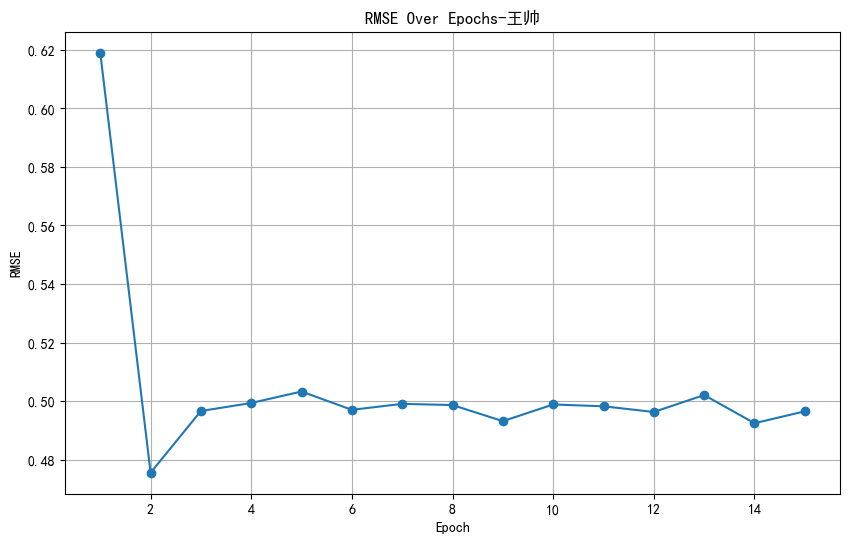

In [21]:
# 下面开始实际训练 RBM（受限玻尔兹曼机）

# 当训练 RBM 时，不会在每个观测后更新 RBM 模型。会在一批观测后更新 RBM 模型。
# 这里，我将定义批量大小。这是我处理一定数量的观测然后更新模型的观测数，这是一个可调参数，可能影响调整模型所需的时间以及整体模型性能。

batch_size = 150

# 选择训练的轮数
num_epochs = 15



# 初始化一个列表来存储每个 epoch 的 RMSE 值
epochs = []
rmse_values = []



for epoch in range(1, num_epochs + 1):
    # 需要一个损失函数来衡量错误；
    # 损失可以是均方误差、简单差值和绝对差值。
    # 这里将使用简单差值，它计算预测值和真实值的绝对值之间的差。使用 train_loss 变量来跟踪损失
    # 需要稍后对 train_loss 变量进行归一化，因此需要一个计数器来跟踪已经过去的训练周期数
    # 需要计数器是一个浮点数，所以将其初始化为0.

    train_loss = 0
    counter = 0.

    # 现在进行 RBM 的实际训练
    # 首先，需要获取的用户批次
    # 将使用一个 for 循环来控制的批次
    # 对于每个用户在范围 0:num_users - batch_size，以 batch_size 为增量

    for user_id in range(0, num_users - batch_size, batch_size):
        # 获取输入和目标
        # 使用 'vk' 变量作为输入批次
        # vk = 从 user_id 到 user_id + batch_size 的所有用户

        vk = training_set_tensor_binary[user_id:user_id + batch_size]

        # 目标是用户的原始评分
        # 使用变量 'v0' 作为目标。
        # v0 将包含此批次中用户的所有原始用户评分，并且不会更改。
        # 目前，v0 和 vk 是相同的。重要的是要注意 vk 在训练 RBM 时将被更新，而 v0 将保持不变。

        v0 = training_set_tensor_binary[user_id:user_id + batch_size]

        # 需要初始概率 'ph0'
        # 从 RBM 的 sample_h() 函数中获取 ph0 的值
        # sample_h() 函数返回 2 个值：p_v_given_h, torch.bernoulli(p_v_given_h)，只需要 p_v_given_h
        # 使用一个 Python 技巧只获取返回的第一个值
        # ph0,_ = ...
        # 逗号下划线 (,_) 是告诉 Python 只获取以下函数返回的第一个值
        # rbm.sample_h() 的输入是当前可见节点的值。
        # 因为还在迭代 0，可以使用 v0

        ph0,_ = rbm.sample_h(v0)

        # 现在需要另一个 for 循环来跟踪 Contranstive Divergence 的 k 步，使用 k=10 步。
        
        for k in range(10):
            # Gibbs 链是一系列从可见节点到隐藏节点的往返行程
            # 每次往返，更新可见节点 (vk) 的值和隐藏节点将被激活的概率 (phk)
            # 将使用这些 vk 和 phk 的值来训练RBM

            # Gibbs 链往返行程的第一部分是使用 rbm.sample_h() 获取隐藏节点的样本
            # 但是，与上面不同，只需要 rmb.sample_h() 函数返回的第二个值：torch.bernoulli(p_v_given_h)
            # 在变量名之前放置下划线逗号 (_,) 以获取函数返回的第二个值
            # 将使用变量 hk 作为迭代 k 时隐藏节点的值

            _,hk = rbm.sample_h(vk)

            # Gibbs 采样的第二步是从隐藏节点返回到可见节点
            # 返回的第二个步骤是将 vk 更新为当前隐藏节点的值

            _,vk = rbm.sample_v(hk)

            # 因为不想在有 -1 评分的地方更新 vk，所以要将任何负值重置回 -1
            # 对于 vk 中小于 1 的每个值，用原始评分列表 v0 中的相应值替换它，即vk 中的任何负值将被替换为 -1

            vk[v0 < 0] = v0[v0 < 0]

            # 这个过程将重复 k 次

        # 现在已经完成了 k 次的 Gibbs 采样，可以训练RBM
        # 有 v0, vk, 和 ph0... 但仍然需要 phk
        # 用 vk 代替 v0 的相同方式获取 phk

        phk,_ = rbm.sample_h(vk)

        # 得到了开始训练的所有变量

        rbm.train(v0, vk, ph0, phk)

        # 现在更新 train_loss
        # 误差是真实值 (v0) - 预测值 (vk)
        # 只需要查看对于有真实评分的观测，真实值和预测值之间的区别
        # 可以忽略任何有负值的观测（用户没有对那部电影进行评分的观测）
        # v0[v0 >= 0] - vk[v0 >= 0] 是说只在 v0 >= 0 的索引处取 v0 - vk... 对于原始值 v0 是 0 或 1 的索引，而不是 -1
        # 使用 torch.mean() 和 torch.abs() 来计算简单距离。

        # 计算RMSE
        squared_errors = torch.pow((v0[v0 >= 0] - vk[v0 >= 0]), 2)
        train_loss += torch.mean(squared_errors)
        #train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0]))

        # 增加跟踪已完成的训练周期总数的计数器

        counter += 1.
    # 归一化损失并计算RMSE
    normalized_loss = train_loss / counter
    rms_error = torch.sqrt(normalized_loss)
    

    
    epochs.append(epoch)
    rmse_values.append(rms_error.item())

    
    
    # 打印每个epoch的RMSE
    print('Epoch: ' + str(epoch) + ' RMSE: ' + str(rms_error.item()))

# 训练完成后，绘制 RMSE 随 epoch 变化的折线图
plt.figure(figsize=(10, 6))  # 设置图形的大小
plt.plot(epochs, rmse_values, marker='o')  # 绘制折线图，带圆点标记
plt.title('RMSE Over Epochs-王帅')  # 设置图表标题
plt.xlabel('Epoch')  # 设置 x 轴标签
plt.ylabel('RMSE')  # 设置 y 轴标签

# 设置中文字体，以解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.grid(True)  # 显示网格
plt.show()  # 显示图形

<font color="black" face="雅黑" size="5"><b>测试RBM</b></font>

In [22]:
# 现在在测试集上测试 RBM。
# 值得注意的是，没有轮次（epochs），这也去除了最外层的 for 循环。

# 需要一个损失函数来衡量错误；
# 这里将使用均方误差。将使用 train_loss 变量来跟踪损失
# 需要计数器是一个浮点数，所以将其初始化为 '0.'

# 使用测试损失而不是训练损失，因为使用的是测试集

test_loss = 0
counter = 0.

for user_id in range(num_users):
    
    # 获取输入和目标
    # 用 v 替换 vk，去掉批量大小
    # 这里仍然使用训练集作为输入来激活隐藏节点以获得输出，然后与 vt 进行比较
    v = training_set_tensor_binary[user_id:user_id + 1]

    # 目标是用户（在测试集中）的原始评分
    # 将用 vt 替换 v0。
    # 使用测试集而不是训练集

    vt = test_set_tensor_binary[user_id:user_id + 1]

    # 在测试中不需要 ph0

    # 不需要进行 10 步的 Gibbs 采样，一共只需要做一次

    # 只想测试 vt 的值是否存在（即不是 -1）

    if len(vt[vt >= 0]) > 0:
        
        # 第一步，根据训练数据 (v) 获取隐藏节点值的样本
        _,h = rbm.sample_h(v)
        # 第二步，使用隐藏节点中的值来预测可见节点的值
        _,v = rbm.sample_v(h)

        # 现在需要更新测试损失
        # 误差是真实值 (vt) 减去预测值 (v)
        # 只需要查看对于有真实评分的观测，真实值和预测值之间的区别
        # 可以忽略任何有负值的观测（用户没有对那部电影进行评分的观测）
        # vt[vt >= 0] - v[vt >= 0] 是说只在 vt >= 0 的索引处取 vt - v... 对于原始值 vt 是 0 或 1 的索引，而不是 -1
        # 使用 torch.mean() 和 torch.abs() 来计算简单距离。
        
        
        
        # 更新测试损失
        # 计算平方误差
        squared_errors = torch.pow((vt[vt >= 0] - v[vt >= 0]), 2)

        # 更新测试损失为平方误差的平均值
        test_loss += torch.mean(squared_errors)
        
        # 增加跟踪已完成的总训练周期数的计数器
        counter += 1.

# 在每个 epoch 结束时，打印一些信息
# 使用 str(num) 将数字值转换为字符串以便连接，通过将 test_loss 除以训练周期计数器来归一化损失

# 计算并打印测试集上的RMSE
normalized_loss = test_loss / counter if counter > 0 else 0
rms_error = torch.sqrt(normalized_loss)
print('测试集上的RMSE: ' + str(rms_error.item()))

测试集上的RMSE: 0.49293452501296997


<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于lightGCN的电影推荐算法实现--李华楠</b>
    </font>
</p>

In [1]:
pip install torch==1.12.1+cpu torchvision==0.13.1+cpu torchaudio==0.12.1 -f https://download.pytorch.org/whl/cpu/torch_stable.html

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


!pip install -q torch==1.9.0

In [2]:
import torch
torch.__version__

'1.12.1+cpu'

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

读取数据

In [4]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("C:/Users/Yan/Desktop/Big-homework/ml-100k/u.data",sep="\t",names=columns_name)
# df['rating'] = df['rating'].apply(lambda x: 0 if x <= 2 else x)
print(len(df))
display(df.head(5))

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
df = df[df['rating']>=3]
print(len(df))

82520


In [6]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [7]:
train, test = train_test_split(df.values, test_size=0.1, random_state = 16)
train = pd.DataFrame(train, columns = df.columns)
test = pd.DataFrame(test, columns = df.columns)

In [8]:
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  74268
Test Size :  8252


标记编码用户和项目id

In [9]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)

In [10]:
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
print(len(test))

943 1562
8240


In [11]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)

In [12]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1562


"latent_dim" 是用户/项目嵌入的长度。
n_layers 是所期望的将初始用户/项目嵌入在图中传播的次数

In [13]:
latent_dim = 64
n_layers = 3  

In [14]:
def convert_to_sparse_tensor(dok_mtrx):
    
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor


在推荐系统中，评估推荐质量的常用指标有：

Recall@K：在前K个推荐项中，与用户实际喜欢的物品匹配的数量占用户喜欢的物品总数的比例。这个指标关注的是推荐列表中相关物品的覆盖率。

Precision@K：在前K个推荐项中，与用户实际喜欢的物品匹配的数量占推荐列表中物品总数的比例。这个指标关注的是推荐列表中相关物品的比例。

NDCG@K（Normalized Discounted Cumulative Gain@K）：归一化的折扣累积增益，考虑了排名顺序的推荐质量指标。它不仅考虑了推荐列表中相关物品的数量，还考虑了这些物品在推荐列表中的排名位置。

MAP@K（Mean Average Precision@K）：平均精度均值，是Precision@K的期望值，通常用来衡量整个测试集上推荐系统的平均性能

In [15]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
 
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean() 

LightGCN模型
get_A_tilda函数用于获取A_tilda，它将与初始用户/物品嵌入（E0）相乘，以在propagate_through_layers函数中的不同层（n_layers = 3）创建嵌入。
forward函数用于查找用户/物品的初始（E0）和最终嵌入。

In [16]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        
        # Below Code is toconvert the dok_matrix to sparse tensor.
        
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor
    
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [17]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)

In [18]:
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([2505, 64])


### **BPR Loss**

In [19]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
        
    return loss, reg_loss

Data Loader - 数据加载器 - 抽取用户，并为每个用户抽取1个正面物品（用户在训练数据中与之互动过的物品）和1个负面物品（用户尚未与之互动的物品）。

In [20]:
def data_loader(data, batch_size, n_usr, n_itm):
  
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
  
    indices = [x for x in range(n_usr)]
    
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
  
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
  
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [21]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

In [22]:
EPOCHS = 60
BATCH_SIZE = 1024 
DECAY = 0.0001
K = 10

### **Training Loop**

In [23]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = [] 

for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)
  
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
  
    best_ndcg = -1
  
    train_start_time = time.time()
    lightGCN.train()
    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():
    
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    if test_topK_recall > best_ndcg:
        best_ndcg = test_topK_recall
      
        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')
     

    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)  

  0%|          | 0/60 [00:00<?, ?it/s]

In [24]:
epoch_list = [(i+1) for i in range(EPOCHS)]

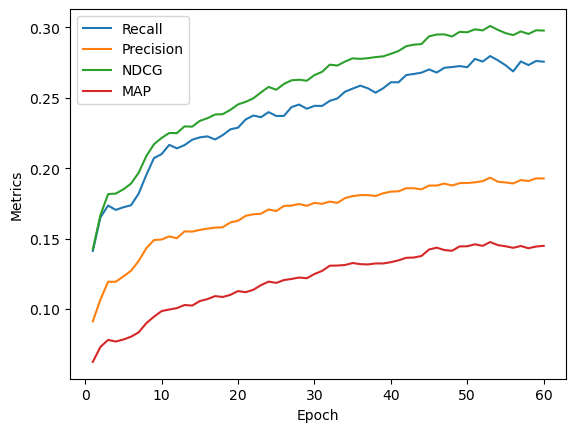

In [25]:
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

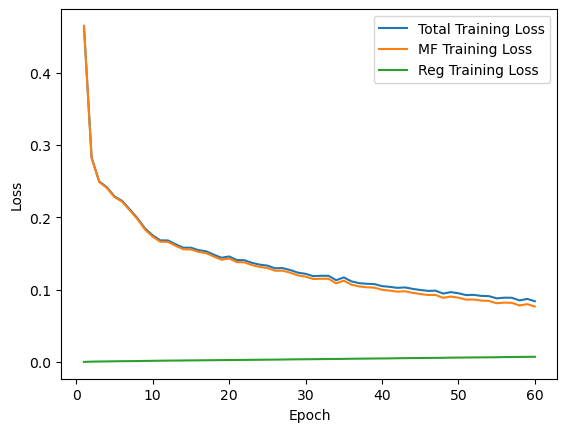

In [26]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [27]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Averge time taken to train an epoch ->  14.88  seconds
Averge time taken to eval an epoch ->  0.41  seconds


In [28]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.2756
Last Epoch's Test Data Precision ->  0.1927
Last Epoch's Test Data NDCG ->  0.2977
Last Epoch's Test Data MAP ->  0.1449
Last Epoch's Train Data Loss ->  0.0841


In [29]:
best_ndcg

0.27555894330967434

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于AutoEncoder的电影推荐算法实现--陶怡汐 </b>
    </font>
</p>

<font color="black" face="雅黑" size="3"><b>说明</b></font>
<font color="black" face="宋体" size="2">
   
   这段程序展示了使用深度学习中的自编码器来处理推荐系统任务。   <br> 
   自编码器是一种无监督学习的神经网络，它可以学习到输入数据的有效表示，常用于特征降维、去噪和数据重建等任务。      <br> 
   在推荐系统中，自编码器可以用来学习用户和物品的低维表示，进而提高推荐的相关性和准确性。        <br> 
   整个程序的目的是使用自编码器来学习用户和电影的表示，并通过这些表示来进行更准确的评分预测，从而提高推荐系统的性能。       <br> 
   程序的输出包括：      <br> 
   1、训练过程中的损失       <br> 
   2、测试损失       <br> 
   3、特定用户-电影对的预测评分    <br> 
   
</font>

<font color="black" face="雅黑" size="5"><b>导入库</b></font>

In [1]:
# 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt

<font color="black" face="雅黑" size="5"><b>读入数据集文件</b></font>

<font color="black" face="雅黑" size="2"><b>读入电影相关信息</b></font>

<font color="black" face="宋体" size="2">
读入csv文件

</font>

In [2]:

#该数据文件中的分隔符/分隔符是一个双冒号"::"
#这个数据文件中没有列名
# engine = python是为了加快这个过程
# encoding = latin-1是因为在一些电影标题中有一些特殊字符无法正确导入。

movies = pd.read_csv(
    'D:\\machine_learning\\archive\\ml-100k\\u.item', 
    sep = '|', 
    header = None, 
    engine = 'python', 
    encoding = 'latin-1',
  
)

<font color="black" face="宋体" size="2">
    此处电影类型有：
    |未知|动作|冒险|动画|儿童|喜剧|犯罪|纪录片|剧情|奇幻|黑色电影|恐怖|音乐剧|悬疑|爱情|科幻|惊悚|战争|西部片

</font>

<font color="black" face="宋体" size="2">
    第一列是movieID <br>
    第二列是电影标题(带年份)  <br>
    第三列是电影发行时间<br>
    第五列是电影现有资源<br>
    最后19个字段是类型，1表示电影是那种类型，0表示不是;电影可以在同时使用几种类型<br>
</font>

In [3]:
movies

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font color="black" face="雅黑" size="2"><b>读入用户相关信息</b></font>

In [4]:
#该数据文件中的分隔符/分隔符是一个双冒号"::"
#这个数据文件中没有列名
# engine = python是为了加快这个过程
# encoding = latin-1是因为在一些电影标题中有一些特殊字符无法正确导入。

users = pd.read_csv(
    'D:\\machine_learning\\archive\\ml-100k\\u.user', 
    sep = '|', 
    header = None, 
    engine = 'python', 
    encoding = 'latin-1',
    names=['user-Id','age','gender','occupation','Postcode']
)

<font color="black" face="宋体" size="2">
    第一列是userID  <br>
    第二列是用户年龄  <br>
    第三列是用户性别(M或F)  <br>
    第四列是用户的职业  <br>
    第五列是用户的邮政编码  <br>
</font>

In [5]:
users

,user-Id,age,gender,occupation,Postcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


<font color="black" face="雅黑" size="2"><b>读入评分相关信息</b></font>


In [6]:
#该数据文件中的分隔符/分隔符是一个双冒号"::"
#这个数据文件中没有列名
# engine = python是为了加快这个过程
# encoding = latin-1是因为在一些电影标题中有一些特殊字符无法正确导入。

ratings = pd.read_csv(
    'D:\\machine_learning\\archive\\ml-100k\\u.data', 
    sep = '\t', 
    header = None, 
    engine = 'python', 
    encoding = 'latin-1',
    names=['user-Id','movie-Id','rating','timestamp']
)

<font color="black" face="宋体" size="2">
    第一列是userID  <br>
    第二列是movieID  <br>
    第三列是评分(1-5);Q是差评，5是好评  <br>
    第四列时间戳(此处不需要)  <br>
   
</font>

In [7]:
ratings

,user-Id,movie-Id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


<font color="black" face="雅黑" size="5"><b>准备训练集和测试集</b></font>



In [8]:
#来自u1的训练集。基本数据文件
#此数据文件使用TAB分隔符
# 80%的数据集

training_set = pd.read_csv(
    'D:\\machine_learning\\archive\\ml-100k\\u1.base', 
    delimiter = '\t'
)

# test set from u1测试数据文件
#此数据文件使用TAB分隔符
#数据集的20%

test_set = pd.read_csv(
    'D:\\machine_learning\\archive\\ml-100k\\u1.test',
        delimiter = '\t'
)

<font color="black" face="宋体" size="2">
    第一列是userID  <br>
    第二列是movieID  <br>
    第三列是评级  <br>
    第四列时间戳(此处不需要)  <br>
   </font>

In [9]:
print(training_set)

         1   1.1  5  874965758
0        1     2  3  876893171
1        1     3  4  878542960
2        1     4  3  876893119
3        1     5  3  889751712
4        1     7  4  875071561
...    ...   ... ..        ...
79994  943  1067  2  875501756
79995  943  1074  4  888640250
79996  943  1188  3  888640250
79997  943  1228  3  888640275
79998  943  1330  3  888692465

[79999 rows x 4 columns]


<font color="black" face="宋体" size="2">
    第一列是userID  <br>
    第二列是movieID  <br>
    第三列是评级 <br>
    第四列时间戳(此处不需要)  <br>
   
</font>

In [10]:
print(test_set)

         1     6  5  887431973
0        1    10  3  875693118
1        1    12  5  878542960
2        1    14  5  874965706
3        1    17  3  875073198
4        1    20  4  887431883
...    ...   ... ..        ...
19994  458   648  4  886395899
19995  458  1101  4  886397931
19996  459   934  3  879563639
19997  460    10  3  882912371
19998  462   682  5  886365231

[19999 rows x 4 columns]


<font color="black" face="雅黑" size="5"><b>将pandas数据框转换为numpy数组</b></font>


<font color="black" face="宋体" size="2">
   处理使用数据，转换为numpy数组方便之后使用
</font>

In [11]:
#将数据帧转换为整数数组
training_set = np.array(training_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [12]:
print(training_set)

[[        1         2         3 876893171]
 [        1         3         4 878542960]
 [        1         4         3 876893119]
 ...
 [      943      1188         3 888640250]
 [      943      1228         3 888640275]
 [      943      1330         3 888692465]]


In [13]:
print(test_set)

[[        1        10         3 875693118]
 [        1        12         5 878542960]
 [        1        14         5 874965706]
 ...
 [      459       934         3 879563639]
 [      460        10         3 882912371]
 [      462       682         5 886365231]]



<font color="black" face="雅黑" size="5"><b>获取用户和电影的数量</b></font>


<font color="black" face="宋体" size="2">
    首先，得到训练集中的最大userID(索引0)和测试集中的最大userID，
    求两者之间的最大值，
    将其转换为整数
    
    movieID (index 1)执行同样操作

</font>

In [14]:
num_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
num_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

<font color="black" face="宋体" size="2">
    分别得到user-id max和movie-id max
        

</font>

In [15]:
print(num_users)
print(num_movies)

943
1682


<font color="black" face="雅黑" size="5"><b>将数据转换为用户为行，电影为列的数组
</b></font>


<font color="black" face="宋体" size="2">
    创建一个列表的列表 <br>
    同时创建一个用户列表和他们对每部电影的评分  <br>
    如果没有用户/电影对的评分，我们将使用0作为评分。   <br>
    使用函数，将函数应用于测试集和训练集   <br>
#
</font>

In [16]:

def convert(data):
   # 初始化并清空列表。作为用户及其评级列表的容器
    new_data = []
    
  #获取每个用户的评分
  #对1到number of users范围内的每个用户id进行分析
    for user_id in range(1, num_users + 1):
        
       #获取电影id和每个评级的评级
       # where“data[:0] == user_id”中的值，即“对于for循环中的当前用户，获取电影id和评分”
        
        movie_ids = data[:, 1][data[:,0] == user_id]
        user_ratings = data[:, 2][data[:,0] == user_id]
        
        #初始化一个0列表作为所有电影的评级，将0替换为适当的评级。
        all_movie_ratings = np.zeros(num_movies)
        
        #用用户的评分替换零评分
        # movie_ids是该用户评价的所有电影的列表
        # movie_ids从1开始，所以必须使用movie_ids - 1，索引从0开始
        all_movie_ratings[movie_ids - 1] = user_ratings
        
        #将当前用户的评分附加到“列表的列表”中
        new_data.append(list(all_movie_ratings))
    
    #返回"list of lists"
    return new_data

<font color="black" face="宋体" size="2">
    此处需注意顺序
    由于 # forch.FloatTensor()需要一个列表的列表，需进行转换

</font>

In [17]:
#转换训练集和测试集

training_set_converted = convert(training_set)
test_set_converted = convert(test_set)


<font color="black" face="雅黑" size="5"><b><font color="black" face="雅黑" size="5"><b>将数据转换成torch张量</b></font>
</b></font>


In [18]:
#使用torch库创建一个浮点数张量
training_set_tensor = torch.FloatTensor(training_set_converted)
test_set_tensor = torch.FloatTensor(test_set_converted)

In [19]:
print(training_set_tensor)

tensor([[0., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])


In [20]:
print(training_set_tensor)

tensor([[0., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])



<font color="black" face="雅黑" size="5"><b><font color="black" face="雅黑" size="5"><b>将评级转换为二进制评级1(喜欢)或0(不喜欢)
</b></font>
</b></font>

<font color="black" face="宋体" size="2">
   创建函数来重新格式化张量中的数据，以反映二进制评级1(喜欢)和0(不喜欢)


</font>

In [21]:

def binary_format(tensor):
    #将有意义的占位符0更改为-1

    tensor[tensor == 0] = -1

    #将评级值1和2替换为二进制值0。这就是说用户不喜欢那部电影

    tensor[tensor == 1] = 0
    tensor[tensor == 2] = 0

    #和再次用于额定值3,4,5，它们将被替换为二进制值1。这就是说用户确实喜欢那部电影。

    tensor[tensor >= 3] = 1
    
    return tensor

<font color="black" face="宋体" size="2">
    重新格式化训练集和测试集（此处-1为无意义的）


</font>


In [22]:
training_set_tensor_binary = binary_format(training_set_tensor)
test_set_tensor_binary = binary_format(test_set_tensor)

In [23]:
print(training_set_tensor_binary)


tensor([[-1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1.,  1., -1.,  ..., -1., -1., -1.]])


In [24]:
print(test_set_tensor_binary)


tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])




<font color="black" face="雅黑" size="5"><b><font color="black" face="雅黑" size="5"><b>创建神经网络的架构
</b></font>
</b></font>

<font color="black" face="宋体" size="2">
    创建一个堆叠式自动编码器  <br>
    将从nn继承构建SAE类。PyTorch库的nn模块中的模块类   <br>



</font>


In [25]:

class SAE(nn.Module):
    
    #注意：第一个是__init__()函数
    #方法必须有self参数
    #逗号空格'参数'是因为继承了nn。模块__init__()函数
    
    def __init__(self, ):
        # super(class, self).methodName
        #调用nn的__init__()方法
        
        super(SAE, self).__init__()
        
        #定义SAE的体系结构

        #第一层
        # nn.Linear()创建一个完全连接的图层
        #神经网络。线性(numberOfInputNodes numberOfHiddenNodes)
        #由于对于每一次观察，都有对每部电影的评分。对于numberOfInputNodes，使用电影的数量(num_movies)，
        #对于numberOfHiddenNodes，此处为20。（可修改）这是一个可以操作得到不同结果的数字。
        #ps：隐藏节点的数量是模型用来做决策的特征的数量。
        
        self.fullyConnectedLayer1 = nn.Linear(
            num_movies,
            20
        )
        
        #第二层
        #与第一个相同，除了numberOfInputNodes将等于前一层隐藏节点的数量
        #选择10作为这一层的隐藏节点数。
        # 
        
        self.fullyConnectedLayer2 = nn.Linear(
            20,
            10
        )

        #第三层
        #与第二个相同，除了numberOfInputNodes将等于…前一层隐藏节点的数量
     
        #这一层为第一个解码层，
        #所以它需要是前一层的镜像，以便开始返回到输出层
        #所以选择20，因为此为对称的模型结构。
        
        self.fullyConnectedLayer3 = nn.Linear(
            10,
            20
        )
        
        #第四层
        #与第三个相同，除了numberOfInputNodes将等于前一层隐藏节点的数量
        #因为在前一层中选择了20个隐藏节点，表示这一层的输入节点数。
        
        #这一层将是第二个解码层，
        #所以它需要是前一层的镜像，以便开始返回到输出层
        #这一层将连接到输出层，
        #因此，输出节点的数量需要等于原始输入节点的数量。
        #又名电影的数量。
        
        self.fullyConnectedLayer4 = nn.Linear(
            20,
            num_movies
        )
        
        #定义激活函数，决定一个节点是否会“触发”
        #自动编码器的两个主要选择是Sigmoid和Rectifier
        #经探究，使用Sigmoid激活函数得到了更好的结果
        
        self.activation = nn.Sigmoid()

#定义一个函数，通过模型向前提供数据。
# this将包括对输入进行编码，
#然后从隐藏层解码生成我们的输出层。
#使用的数据和函数将由对象本身应用。
# x是我们的输入向量。将对其进行两次编码，然后解码以创建输出向量
    
    def forward(self, x):
        #将x编码到第一个隐藏层
        #self.fullyConnectedLayer1()期望前一层的向量'x'
        #每个图层都是一样的
        #对这些值应用激活函数来获得给定层的节点值
        #新值赋值给'x'变量。
        
        x = self.activation(self.fullyConnectedLayer1(x))
        
        # encode x从第一个隐藏层到第二个隐藏层
        
        x = self.activation(self.fullyConnectedLayer2(x))
        
        # decode x从第二个隐藏层到第三个隐藏层
        
        x = self.activation(self.fullyConnectedLayer3(x))

        # decode x从第三隐藏层到第四隐藏层
        
        #分析：因为这是输入到输出层，不需要使用激活函数
        
        x = self.fullyConnectedLayer4(x)
        
        #返回预测评级向量'x'
        #这是输出层的值
        return x
    

<font color="black" face="宋体" size="2">
创建一个SAE类的对象

</font>


In [26]:

sae = SAE()

<font color="black" face="宋体" size="2">
创建损失函数的判据 <br>
损失函数将是mean_squarred_error损失函数  <br>
MSELoss()是PyTorch库的nn模块中的一个类  <br>
标准是该类的一个对象   <br>
</font>


In [27]:

criterion = nn.MSELoss()

#创建优化器，将使用它在损失计算后修改模型
#两个主要的选择是ADAM和RMSprop，都是基于梯度下降的优化器

#使用RMSprop(代表均方根传播)
# RMSprop()取自PyTorch库的optim模块
# RMSprop(参数，lr = learningRate, weight_decay = number)

#SAE类的parameters()方法继承自nn。模块类
# the learningRate是模型在学习过程中可以做出的改变的大小
#在一些epoch之后，weight_decay降低了学习率
#衰减的目的是从更高的学习率开始，以便快速地对模型进行更改，但是随着时间的推移，随着模型越来越接近收敛，学习率也会降低

optimizer = optim.RMSprop(
    sae.parameters(),
    lr = 0.01,
    weight_decay = 0.5
)



<font color="black" face="雅黑" size="5"><b><font color="black" face="雅黑" size="5"><b>训练SAE
</b></font>
</b></font>

<font color="black" face="宋体" size="2">
这段程序的逻辑是训练一个自编码器模型，并在每个epoch结束后记录训练损失和RMSE（均方根误差）值。<br>流程如下：<br>
    初始化：定义训练周期，初始化两个列表来保存每个epoch的训练损失和RMSE值。<br>
    训练循环：使用 for 循环遍历从1到 num_epochs 的每个epoch。在每个epoch开始时，初始化训练损失总MSE和有效用户数。<br>
    用户循环：对每个用户进行遍历，准备输入数据和目标,将输入数据增加一个维度以满足模型的输入要求。 <br>
    有效用户检查：通过检查用户是否有有效的评分（评分大于0），来确定用户是否为有效用户。<br>
    前向传播：如果用户有效，则执行模型的前向传播，获取预测输出 outputs。<br>
    损失计算：计算预测输出和目标之间的MSE损失和loss。<br>
    反向传播与优化：执行反向传播并使用优化器更新模型权重。<br>
    损失和MSE累加同时更新其他数据。<br>
    记录损失和RMSE数据。<br>
    输出信息数据。<br>
程序的目的是监控模型在训练过程中的性能，通过记录每个epoch的训练损失和RMSE来评估模型的改进情况。<br>
</font>

In [28]:
#定义epoch的个数
num_epochs = 200

# 初始化两个列表来保存每个epoch的损失 average RMSE
loss_values = []
rmse_values = []

#使用for循环遍历epoch
for epoch in range(1, num_epochs + 1):
    # train_loss将继续收集训练指标
    train_loss = 0
    train_total_mse = 0
    # num_valid_users将跟踪评级至少为1的用户数量。一些用户的评分为0。
    #初始化为浮点数'0 '。
    #因为稍后将使用其来执行与其他浮点数的计算
    num_valid_users = 0.
    
    #使用for循环遍历观察值，通过user_id
    #“对于每个用户…”
    
    for user_id in range(num_users):
        #该模型将期望输入向量有一个额外的维度，对应于批大小
        
        #在此例中我们没有使用批量，但是我们仍然需要额外的维度
        # Variable(tensorName).unsqueeze(0)将为给定张量添加一个“空”的额外维度
        inputs = Variable(training_set_tensor_binary[user_id]).unsqueeze(0)
    
        #对于自动编码器，目标和输入是一样的，但是因为我们要修改输入向量，
        #target不会被更改
        targets = inputs.clone()
        
        #使用if语句，为了节省内存和提高性能
        
        # '如果当前user_id的所有评级之和大于0'即"如果这个用户有任何评级"
        #则为没有评级的“无效用户”
        
        if torch.sum(targets.data > 0) > 0:   #前向传播
            #获得预测评级的输出。
            #堆叠自动编码器模型的输出。
            #把输入输入到模型中，结果是什么?
            outputs = sae.forward(inputs)
            
            #设定目标。require_grad = False，（不需要计算目标梯度）
       
            targets.require_grad = False
            
            #将所有未分级电影的输出设置为= 0
            #对于每个输出(电影评分预测)，
            #如果原始电影评分为0，则将输出设置为0。
            #主要是为了加快培训过程
        
            outputs[targets == 0] = 0
            
            #计算损失
          
            #损失函数是预测输出与原始目标的均方误差
            
            loss = criterion(outputs, targets)
            
            #期望得到电影的平均评分（但并非所有电影都被评分）
            
            #有评分的电影的比例
            # total number of movies /被评级的电影数量
            #使用torch.sum(target. sum)Data > 0)来计算评分的个数
            # 计算平均校正因子
            
            mean_corrector = num_movies/float(torch.sum(targets.data > 0) + 1e-10)
            
            #用损失函数反向传播
            # loss.backward()函数告诉模型权重将被更新的方向
            loss.backward()
            
            #更新train_loss变量来帮助跟踪训练进度
            #该用户的平均损失=…的平方根
            #该用户的总损失* mean_corrector
            train_loss += np.sqrt(loss.item() * mean_corrector)
                 
            # 累加MSE
            train_total_mse += loss.item()

            #增加有效用户数
            num_valid_users += 1
            
            #使用优化器来更新权重
            #优化器决定更新大小
            optimizer.step()
       
            # end if statement
        # end user for loop
    
    average_loss = train_loss / num_valid_users
    print('Epoch: ' + str(epoch) + ' Loss: ' + str(average_loss))
    
    # 将当前epoch的损失保存到列表中
    loss_values.append(average_loss)
    # loss_values现在包含了所有epoch的损失值
    
    # 计算平均MSE
    train_average_mse = train_total_mse / num_valid_users if num_valid_users > 0 else 0
    # 计算平均RMSE
    train_average_rmse = np.sqrt(train_average_mse)
    # 打印平均RMSE
    print('Epoch: ' + str(epoch) +'average RMSE: ' + str(train_average_rmse))
    # 将当前epoch的损失保存到列表中
    rmse_values.append(train_average_rmse)
    # loss_values现在包含了所有epoch的损失值

    #结束epoch for循环

Epoch: 1 Loss: 2.247114012718885
Epoch: 1average RMSE: 0.4156179240469721
Epoch: 2 Loss: 2.100501235171888
Epoch: 2average RMSE: 0.39030114608957006
Epoch: 3 Loss: 2.073992789364142
Epoch: 3average RMSE: 0.3875688083793322
Epoch: 4 Loss: 2.052047539947331
Epoch: 4average RMSE: 0.3852479404491302
Epoch: 5 Loss: 2.0393201120720197
Epoch: 5average RMSE: 0.3842783641610553
Epoch: 6 Loss: 2.0337871205015725
Epoch: 6average RMSE: 0.3836433266166689
Epoch: 7 Loss: 2.0291832335834785
Epoch: 7average RMSE: 0.38325932598694806
Epoch: 8 Loss: 2.025971469024899
Epoch: 8average RMSE: 0.3828274510559626
Epoch: 9 Loss: 2.02258898162588
Epoch: 9average RMSE: 0.38256068345117566
Epoch: 10 Loss: 2.0196879530716028
Epoch: 10average RMSE: 0.38203229704507696
Epoch: 11 Loss: 2.0146962421002987
Epoch: 11average RMSE: 0.38175714833769275
Epoch: 12 Loss: 2.0102178411540974
Epoch: 12average RMSE: 0.38067240216345916
Epoch: 13 Loss: 2.0019119952140154
Epoch: 13average RMSE: 0.38007045492863867
Epoch: 14 Loss: 1

<font color="black" face="宋体" size="2">
对结果进行可视化
</font>

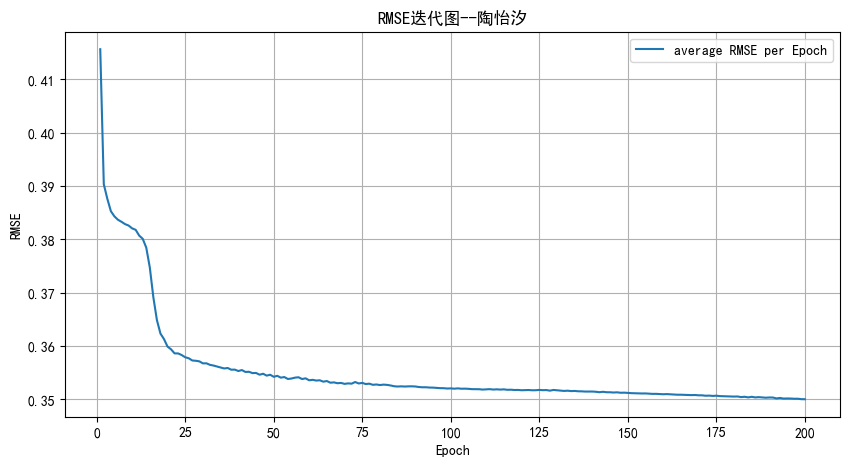

In [29]:
losses = rmse_values  # 假设有200个epoch

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 将epoch数转换为一个与损失值相同长度的列表
epochs = np.arange(1, 201)

# 使用matplotlib绘制折线图
plt.figure(figsize=(10, 5))  # 设置图像大小
plt.plot(epochs, losses, label='average RMSE per Epoch')  # 绘制折线图
plt.title('RMSE迭代图--陶怡汐')  # 添加标题
plt.xlabel('Epoch')  # 添加x轴标签
plt.ylabel('RMSE')  # 添加y轴标签
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格
plt.show()  # 显示图像

<center> <font color="black" face="雅黑" size="2"><b>图1-1RMSE与迭代次数关系图——陶怡汐</b></font> </center>

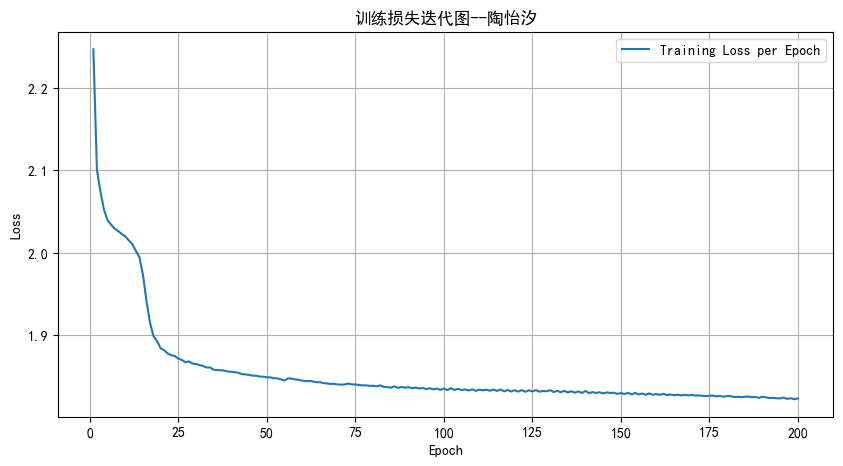

In [31]:

losses = loss_values  # 假设有200个epoch

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 将epoch数转换为一个与损失值相同长度的列表
epochs = np.arange(1, 201)

# 使用matplotlib绘制折线图
plt.figure(figsize=(10, 5))  # 设置图像大小
plt.plot(epochs, losses, label='Training Loss per Epoch')  # 绘制折线图
plt.title('训练损失迭代图--陶怡汐')  # 添加标题
plt.xlabel('Epoch')  # 添加x轴标签
plt.ylabel('Loss')  # 添加y轴标签
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格
plt.show()  # 显示图像

<center> <font color="black" face="雅黑" size="2"><b>图1-2损失值与迭代次数关系图——陶怡汐</b></font> </center>

<font color="black" face="雅黑" size="5"><b><font color="black" face="雅黑" size="5"><b>测试SAE
</b></font>
</b></font>

<font color="black" face="宋体" size="2">
测试训练出的模型
</font>

In [32]:
# 初始化总的MSE和有效用户计数
total_mse = 0
num_valid_users = 0
test_loss = 0

# 对每个用户进行遍历
for user_id in range(num_users):
    # 定义输入和目标
    inputs = Variable(training_set_tensor_binary[user_id]).unsqueeze(0)
    targets = Variable(test_set_tensor_binary[user_id]).unsqueeze(0)
    
    # 只检查至少有一个有效评分的用户
    if torch.sum(targets.data > 0) > 0:
        outputs = sae.forward(inputs)
        targets.require_grad  = False
        outputs[targets == 0] = 0
        # 计算MSE损失
        loss = criterion(outputs, targets)
        
        mean_corrector = num_movies/float(torch.sum(targets.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.item() * mean_corrector)

        # 累加MSE
        total_mse += loss.item()
        # 增加有效用户数
        num_valid_users += 1

# 计算平均MSE
average_mse = total_mse / num_valid_users if num_valid_users > 0 else 0

# 计算平均RMSE
average_rmse = np.sqrt(average_mse)

# 打印平均RMSE
print('average RMSE: ' + str(average_rmse))
print('Test Loss: ' + str(test_loss/num_valid_users))


average RMSE: 0.29761535801885625
Test Loss: 2.2583209733120038


<font color="black" face="雅黑" size="5"><b><font color="black" face="雅黑" size="5"><b>做一个预测
</b></font>
</b></font>

In [33]:
#预测用户0 - 9和电影0 - 9

# 创建一个10x10的矩阵，用于保存预测结果
predicted_ratings_matrix = np.zeros((10, 10))

for user_id in range(10):
    for movie_id in range(10):
        target_user_id = user_id
        target_movie_id = movie_id
        inputs = Variable(training_set_tensor_binary[target_user_id - 1]).unsqueeze(0)
        outputs = sae.forward(inputs)
        output_numpy = outputs.data.numpy()

        # 保存预测结果到矩阵中
        predicted_ratings_matrix[user_id, movie_id] = output_numpy[0, movie_id-1]
        
        print('User ID: ' + str(target_user_id))
        print('Movie ID: ' + str(target_movie_id))
        print('Predicted Rating: ' + str(output_numpy[0, target_movie_id - 1]))

# 打印或保存矩阵（在编写程序时用于检验数据是否保存完好）
#print(predicted_ratings_matrix)

User ID: 0
Movie ID: 0
Predicted Rating: -0.9670423
User ID: 0
Movie ID: 1
Predicted Rating: 0.368738
User ID: 0
Movie ID: 2
Predicted Rating: -0.44191715
User ID: 0
Movie ID: 3
Predicted Rating: -0.8523421
User ID: 0
Movie ID: 4
Predicted Rating: -0.20674372
User ID: 0
Movie ID: 5
Predicted Rating: -0.77795017
User ID: 0
Movie ID: 6
Predicted Rating: -0.9697501
User ID: 0
Movie ID: 7
Predicted Rating: 0.026716545
User ID: 0
Movie ID: 8
Predicted Rating: -0.17180687
User ID: 0
Movie ID: 9
Predicted Rating: -0.26277047
User ID: 1
Movie ID: 0
Predicted Rating: -0.955711
User ID: 1
Movie ID: 1
Predicted Rating: 0.11403823
User ID: 1
Movie ID: 2
Predicted Rating: -0.65865624
User ID: 1
Movie ID: 3
Predicted Rating: -0.91353154
User ID: 1
Movie ID: 4
Predicted Rating: -0.49939513
User ID: 1
Movie ID: 5
Predicted Rating: -0.83266234
User ID: 1
Movie ID: 6
Predicted Rating: -0.9646488
User ID: 1
Movie ID: 7
Predicted Rating: -0.24556555
User ID: 1
Movie ID: 8
Predicted Rating: -0.39246038
Use


<font color="black" face="雅黑" size="2"><b>通过热力图可视化预测结果</b></font>

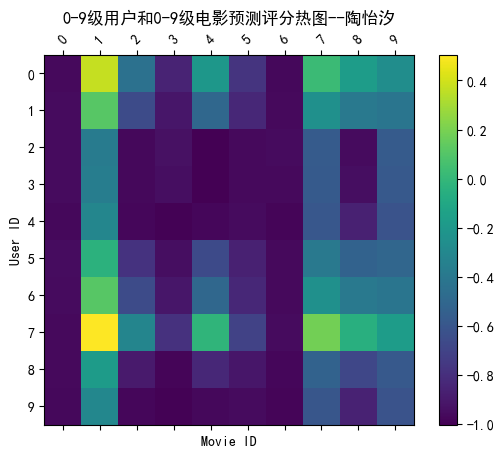

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设output_numpy是从你的程序中获取的预测评分的numpy数组
# 它应该是一个10x10的矩阵，其中[i, j]表示用户i对电影j的预测评分
# 这里我们用随机数来模拟这个数组
output_numpy = predicted_ratings_matrix   # 用随机数代替实际的预测评分

# 创建一个图形和轴对象
fig, ax = plt.subplots()
# 绘制热力图
cax = ax.matshow(output_numpy, cmap='viridis')
# 添加颜色条
fig.colorbar(cax)
# 设置标题和轴标签
ax.set_title('0-9级用户和0-9级电影预测评分热图--陶怡汐')
ax.set_xlabel('Movie ID')
ax.set_ylabel('User ID')

# 设置轴刻度，以显示用户ID和电影ID
ax.set_xticks(np.arange(output_numpy.shape[1]))
ax.set_yticks(np.arange(output_numpy.shape[0]))
ax.set_xticklabels(range(10), rotation=45)
ax.set_yticklabels(range(10))

# 显示图形
plt.show()

<center> <font color="black" face="雅黑" size="2"><b>图1-3预测结果热力图——陶怡汐</b></font> </center>

<p style="text-align: center;">
    <font color="black" face="雅黑" size="6">
        <b>基于神经协同过滤的电影推荐算法实现--严沁</b>
    </font>
</p>

NCF的工作方式是它接受一个输入，然后将其通过GMF算法和MLP算法，然后它将两者*连接*（“组合”）成一个最终结果。
首先分别独立训练两个部分GMF和MLP，然后将它们组合成上面可视化的组合架构，最后训练组合架构。这样做的部分好处将是更快的训练时间和由此而来的收敛时间.
所以在NCF中，首先准备数据，然后将使用PyTorch的内置方法训练一个SVD算法，然后继续训练MLP（神经网络），将像训练普通模型一样训练它。最后，将定义组合模型的结构，输入在前两个步骤中训练的两个模型，并在新定义的结构中同时训练这两个模型。

## 导入数据集

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 假设 df 已经被加载
df_copy = df.copy()

# 收集用户的索引
user_indices = []
for user_id in df['user_id'].unique():
    user_index = df_copy[df_copy['user_id'] == user_id].index[0]
    user_indices.append(user_index)

# 收集之前用户选择未覆盖的物品的索引
item_indices = []
for item_id in df['item_id'].unique():
    if not df_copy.loc[df_copy['item_id'] == item_id].index.intersection(user_indices).any():
        item_index = df_copy[df_copy['item_id'] == item_id].index[0]
        item_indices.append(item_index)

# 合并索引并删除可能的重复项
combined_indices = list(set(user_indices + item_indices))

# 提取训练数据的行
train_data_initial = df_copy.loc[combined_indices]

# 从 df_copy 中删除这些行
df_copy = df_copy.drop(index=combined_indices)

# 对剩余数据进行 75/25 的划分
training_remaining, test_data = train_test_split(df_copy, test_size=0.25, random_state=42)

# 将 training_remaining 与最初提取的训练数据合并
train_data = pd.concat([train_data_initial, training_remaining]).reset_index(drop=True)

# 输出最终划分的大小
print(f"训练数据大小: {train_data.shape}")
print(f"测试数据大小: {test_data.shape}")

训练数据大小: (75539, 4)
测试数据大小: (24461, 4)


In [4]:
num_factors = 180
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
print("number of unique users:", num_users)
print("number of unique items:", num_items)

number of unique users: 943
number of unique items: 1682


In [5]:
train_data['user_id'].max()

943

In [6]:
train_data['item_id'].max()

1682

In [7]:
pip install torch==1.12.1+cpu torchvision==0.13.1+cpu torchaudio==0.12.1 -f https://download.pytorch.org/whl/cpu/torch_stable.html

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# 假设 df 已经被加载，且 train_data 和 test_data 已按照所示创建
# df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
# train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

class MovieLensDataset(Dataset):
    def __init__(self, user_ids, item_ids, ratings):
        self.user_ids = user_ids
        self.item_ids = item_ids
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.ratings[idx]

# 准备训练数据集
train_dataset = MovieLensDataset(
    user_ids=torch.tensor(train_data['user_id'].values, dtype=torch.long),
    item_ids=torch.tensor(train_data['item_id'].values, dtype=torch.long),
    ratings=torch.tensor(train_data['rating'].values, dtype=torch.float)
)

# 准备测试数据集
test_dataset = MovieLensDataset(
    user_ids=torch.tensor(test_data['user_id'].values, dtype=torch.long),
    item_ids=torch.tensor(test_data['item_id'].values, dtype=torch.long),
    ratings=torch.tensor(test_data['rating'].values, dtype=torch.float)
)

# 创建训练和测试的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## 定义 NCF 架构

在开始训练两个模型之前，先定义组合结构。

In [9]:
import torch
import torch.nn as nn

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, mlp_layers):
        super(NCF, self).__init__()
        # GMF 嵌入层
        self.embedding_user_gmf = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.embedding_item_gmf = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        
        # MLP 嵌入层
        self.embedding_user_mlp = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        
        # MLP 层
        self.mlp = nn.Sequential()
        for in_size, out_size in zip(mlp_layers[:-1], mlp_layers[1:]):
            self.mlp.add_module('mlp_layer_{}'.format(in_size), nn.Linear(in_size, out_size))
            self.mlp.add_module('relu_{}'.format(in_size), nn.ReLU())
        
        # 最终预测层
        self.predict_layer = nn.Linear(embedding_size + mlp_layers[-1], 1)  # 根据 GMF 和 MLP 最后一层的输出调整大小
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        # GMF 部分
        user_embedding_gmf = self.embedding_user_gmf(user_indices)
        item_embedding_gmf = self.embedding_item_gmf(item_indices)
        gmf_output = user_embedding_gmf * item_embedding_gmf
        
        # MLP 部分
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        mlp_input = torch.cat((user_embedding_mlp, item_embedding_mlp), -1)
        mlp_output = self.mlp(mlp_input)
        
        # 组合 GMF 和 MLP 输出
        combined_features = torch.cat((gmf_output, mlp_output), -1)
        
        # 最终预测
        predictions = self.predict_layer(combined_features)
        return self.sigmoid(predictions)


理解NCF模型中的嵌入
--------------------------------------

神经协同过滤（NCF）在其广义矩阵分解（GMF）和多层感知器（MLP）组件中使用单独的嵌入来捕获广泛的用户-物品交互模式。以下是嵌入在NCF模型中的作用和重要性的概述：

### 嵌入的作用

* **GMF嵌入**：旨在捕获线性交互，专注于以线性方式直接贡献的潜在因子。
* **MLP嵌入**：旨在发现复杂和非线性的交互，允许模型学习适合通过深度神经网络层捕获非线性模式的不同潜在因子集。

### 单独嵌入的好处

* **灵活性**：单独的嵌入增强了模型的灵活性，允许为非线性交互学习定制用户和物品的表示。
* **并行学习路径**：模型同时学习线性（GMF）和非线性（MLP）交互，使模型能够捕获更广泛的模式。
* **更丰富的表示**：在不同上下文（线性与非线性）下保持不同的表示，当组合时提供了用户-物品交互的更全面视图。

### MLP结构和嵌入集成

1. **嵌入层**：将稀疏的用户和物品ID转换为密集的、连续的向量，捕获基本特征。
2. **连接**：用户和物品嵌入被连接以形成统一的表示，作为MLP的输入。
3. **神经网络处理**：连接的向量通过MLP层传递，通过多层神经元和非线性激活函数学习复杂交互。
4. **输出和模型融合**：MLP的输出与GMF的输出（如果存在）结合以进行最终预测，利用线性和非线性的洞察力。

### 实际意义

GMF嵌入捕获了电影的总体受欢迎程度，而MLP嵌入则辨别了细微的偏好，如流派或导演风格。这种双路径方法允许NCF模型通过有效整合不同类型的信息，提供高度准确和个性化的推荐。
总结来说，NCF模型中的双嵌入策略促进了一种全面的学习机制，允许在线性和非线性维度上细致地捕获用户-物品交互，显著提高了推荐质量。

### 理解`mlp_layers`

在这种情况下，`mlp_layers`是一个整数列表，其中每个整数指定模型MLP部分中每一层的神经元（单元）数量。`mlp_layers`的结构直接决定了神经网络的架构，包括它有多少层以及每层的大小。

例如，如果`mlp_layers = [64, 32, 16]`，这表示模型的MLP部分将有三层（不包括输入层）：

- 第一层将有64个神经元。
- 第二层将有32个神经元。
- 第三层将有16个神经元。

### 构建MLP层

循环遍历`mlp_layers`中的连续大小对，以构建MLP的每一层：

```python
for in_size, out_size in zip(mlp_layers[:-1], mlp_layers[1:]):
    self.mlp.add_module('mlp_layer_{}'.format(in_size), nn.Linear(in_size, out_size))
    self.mlp.add_module('relu_{}'.format(in_size), nn.ReLU())

最后解释MLP输出层：

### 1. **输入嵌入：**
- MLP组件接收特定用户和特定物品（电影）的嵌入向量作为输入。
- 这些嵌入是密集的、低维的表示，从数据中学习得到，旨在捕捉用户和电影的独特特征。

### 2. **组合嵌入：**
- 用户和物品嵌入被组合，通常是通过连接，形成一个单一的输入向量。这个向量作为嵌入空间中用户-物品交互的综合表示。

### 3. **通过MLP处理：**
- 这个组合向量然后通过MLP的几个层进行处理。每一层由一个线性变换（一个全连接层）和非线性激活函数（例如ReLU）组成。MLP能够捕捉输入特征之间复杂和非线性的关系。
- MLP的深度（层数）和宽度（每层的单元数）可以变化，旨在有效地模拟用户-物品交互的复杂性。

### 4. **输出预测：**
- 通过MLP层后，最终输出通过最终预测层进行转换，将处理后的信息的维度降低到一个单一的标量值。
- 这个标量值代表用户观看（或积极评价）所讨论电影的可能性的原始预测分数。

### 5. **应用Sigmoid函数：**
- 对标量值应用sigmoid激活函数，将其映射到0和1之间的概率分数。这个分数代表模型对预测用户将积极与电影互动（例如观看它、喜欢它或高度评价它）的信心。
- 分数越接近1，表示正面互动的可能性越高；相反，分数越接近0，表示可能性越低。

### 总结：
总结来说，NCF模型的MLP部分接受用户和物品嵌入作为输入，输出一个单一值，代表正面互动（如观看电影）的可能性。这个输出可以用来对电影进行排名推荐，分数越高表示推荐越强。MLP（以及整个NCF模型）的美妙之处在于其能够通过神经网络层学习并模拟用户复杂而微妙的偏好以及物品的属性，超越了传统矩阵分解技术的能力。

## 训练 GMF

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [11]:
import os
import pickle

class TrainingEpisode:
    def __init__(self, name):
        self.name = name
        self.mse_values = []  # 均方误差值列表
        self.gradient_magnitudes = []  # 梯度大小列表
        self.P_all_epochs = []  # 所有周期的 P 值列表
        self.Q_all_epochs = []  # 所有周期的 Q 值列表
        self.differences = []  # 差异列表

    def update(self, P, Q, mse, gradient_magnitude, difference):
        self.P_all_epochs.append(P.copy())  # 添加 P 值副本到列表
        self.Q_all_epochs.append(Q.copy())  # 添加 Q 值副本到列表
        self.mse_values.append(mse)  # 添加均方误差到列表
        self.gradient_magnitudes.append(gradient_magnitude)  # 添加梯度大小到列表
        self.differences.append(difference)  # 添加差异到列表

    def last_epoch(self):
        # 返回训练周期的数量
        return len(self.mse_values)

    def save(self, path='./'):
        # 如果目录不存在，则创建目录
        os.makedirs(path, exist_ok=True)
        filepath = os.path.join(path, f"{self.name}.pkl")
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)
        # print(f"TrainingEpisode '{self.name}' 保存到 {filepath}")

    @staticmethod
    def load(name, path='./'):
        filepath = os.path.join(path, f"{name}.pkl")
        if os.path.exists(filepath):
            with open(filepath, 'rb') as file:
                episode = pickle.load(file)
            # print(f"TrainingEpisode '{name}' 从 {filepath} 加载")
            return episode
        else:
            print(f"文件 {filepath} 不存在。")
            return None

In [12]:
import numpy as np

class LearningRateScheduler:
    def __init__(self, initial_lr=0.01, min_lr=0.001, decay=0.5, epochs_drop=10):
        self.initial_lr = initial_lr  # 初始学习率
        self.min_lr = min_lr  # 最小学习率
        self.decay = decay  # 衰减率
        self.epochs_drop = epochs_drop  # 学习率下降的周期数
        self.lr = initial_lr  # 当前学习率

    def get_lr(self, epoch):
        """计算给定周期的学习率。"""
        # 计算新的学习率
        new_lr = self.initial_lr * (self.decay ** np.floor((1 + epoch) / self.epochs_drop))
        # 确保学习率不会低于指定的最小值
        self.lr = max(new_lr, self.min_lr)
        return self.lr

    def reset(self):
        """重置学习率到初始值。"""
        self.lr = self.initial_lr

In [13]:
import numpy as np

def calculate_mse(train_data, P, Q):
    """
    计算预测的均方误差（MSE）。
    
    参数：
    - train_data: 包含实际用户-物品评分的训练数据集。
    - P: 用户潜在因子矩阵。
    - Q: 物品潜在因子矩阵。
    
    返回值：
    - 预测的均方误差（MSE）。
    """
    mse = 0.0
    for index, row in train_data.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        # 将 user_id 和 item_id 转换为索引
        user_idx = user_id - 1  # 假设 user_id 从 1 开始
        item_idx = item_id - 1  # 假设 item_id 从 1 开始
        # 预测评分
        predicted_rating = np.dot(P[user_idx], Q[item_idx])
        # 累积平方误差
        mse += (actual_rating - predicted_rating) ** 2
    # 计算均值
    mse /= len(train_data)
    return mse

In [14]:
def train_model_with_episode(train_data, P, Q, epochs, episode, lr_scheduler, lambda_reg, track_index=0, auto_save = True, auto_save_every_n = 100):
    '''
    参数：
- train_data: 训练数据集。
- P: 用户潜在因子的初始矩阵。
- Q: 物品潜在因子的初始矩阵。
- learning_rate: 更新时的学习率。
- epochs: 训练模型的迭代次数。
- episode: 用于跟踪训练指标的TrainingEpisode实例。
- track_index: 在训练集中跟踪梯度的用户-物品对的索引。

返回：
- 最终训练好的P和Q矩阵。
    '''
    for epoch in range(episode.last_epoch(), epochs):
        learning_rate = lr_scheduler.get_lr(epoch)
        gradient_magnitude=[]
        for index, row in train_data.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            user_idx = user_id - 1
            item_idx = item_id - 1
            
            # 计算预测值和误差
            pred_rating = np.dot(P[user_idx], Q[item_idx])
            error = actual_rating - pred_rating
            
            # 计算梯度
            P_grad = -2 * error * Q[item_idx] + 2 * lambda_reg * P[user_idx]
            Q_grad = -2 * error * P[user_idx] + 2 * lambda_reg * Q[item_idx]
            
            # 更新P和Q
            P[user_idx] -= learning_rate * P_grad
            Q[item_idx] -= learning_rate * Q_grad
            
            # 存储跟踪索引的梯度幅度
            gradient_magnitude.append(np.linalg.norm(P_grad) + np.linalg.norm(Q_grad))
            
        # 计算均方误差和与前一个周期的差异
        mse = calculate_mse(train_data, P, Q)
        difference = episode.mse_values[-1] - mse if episode.mse_values else 0
        episode.update(P, Q, mse, gradient_magnitude, difference)
        
        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse}, Difference: {difference}, Learning Rate: {learning_rate}")
        if(epoch % auto_save_every_n==0):
            if(auto_save):
                episode.save("auto_saves")

    return P, Q


In [15]:
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
print("number of unique users:", num_users)
print("number of unique items:", num_items)

number of unique users: 943
number of unique items: 1682


In [16]:
import numpy as np

def predict(user_id, item_id, P, Q):
    """
    使用 P 和 Q 的点积预测用户对物品的评分。
    """
    # 将 user_id 和 item_id 转换为索引
    user_idx = user_id - 1  # 如果 user_id/item_id 从 1 开始，则调整索引
    item_idx = item_id - 1
    
    # 计算用户和物品因子的点积以得到预测评分
    rating_pred = np.dot(P[user_idx, :], Q[item_idx, :])
    return rating_pred

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def evaluate_model(dataset, P, Q):
    """
    评估模型在给定数据集上的性能。
    """
    predictions = []
    actuals = []
    
    for index, row in dataset.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        predicted_rating = predict(user_id, item_id, P, Q)  # 假设 predict 函数已定义
        predictions.append(predicted_rating)
        actuals.append(actual_rating)
    
    # 计算均方根误差（RMSE）和平均绝对误差（MAE）
    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae

In [18]:
num_factors = 180

# 初始化潜在因子矩阵
cur_start_P = np.random.normal(0, 0.1, (num_users, num_factors))
cur_start_Q = np.random.normal(0, 0.1, (num_items, num_factors))

# 创建一个新的训练周期来跟踪这次运行
cur_episode = TrainingEpisode(f'SVD for NCF')
lr_scheduler = LearningRateScheduler(initial_lr=0.03, min_lr=0.0005, decay=0.99, epochs_drop=1)

lambda_reg = 0.1

# 使用当前 lambda 值训练模型
SVD_P, SVD_Q = train_model_with_episode(train_data, cur_start_P, cur_start_Q, epochs=100, episode=cur_episode, lr_scheduler=lr_scheduler, lambda_reg=lambda_reg, auto_save=True)

cur_episode.save()

Epoch 1/100, MSE: 0.8804766243330585, Difference: 0, Learning Rate: 0.029699999999999997
Epoch 2/100, MSE: 0.7339995209229851, Difference: 0.14647710341007336, Learning Rate: 0.029403
Epoch 3/100, MSE: 0.6524756218418434, Difference: 0.08152389908114177, Learning Rate: 0.029108969999999998
Epoch 4/100, MSE: 0.5951310434509878, Difference: 0.057344578390855605, Learning Rate: 0.028817880299999998
Epoch 5/100, MSE: 0.553739006987815, Difference: 0.0413920364631728, Learning Rate: 0.028529701496999998
Epoch 6/100, MSE: 0.5237331486210764, Difference: 0.030005858366738525, Learning Rate: 0.02824440448203
Epoch 7/100, MSE: 0.5017484287503295, Difference: 0.021984719870746905, Learning Rate: 0.027961960437209697
Epoch 8/100, MSE: 0.48535025552440175, Difference: 0.016398173225927792, Learning Rate: 0.0276823408328376
Epoch 9/100, MSE: 0.47284877114500307, Difference: 0.012501484379398686, Learning Rate: 0.027405517424509224
Epoch 10/100, MSE: 0.4630941933517185, Difference: 0.009754577793284

Epoch 77/100, MSE: 0.3676634735251427, Difference: 0.0004934199345156265, Learning Rate: 0.013836659022542863
Epoch 78/100, MSE: 0.3671784669978104, Difference: 0.000485006527332299, Learning Rate: 0.013698292432317434
Epoch 79/100, MSE: 0.3667017135878704, Difference: 0.0004767534099400228, Learning Rate: 0.01356130950799426
Epoch 80/100, MSE: 0.3662330571282083, Difference: 0.0004686564596620979, Learning Rate: 0.013425696412914318
Epoch 81/100, MSE: 0.36577234538954667, Difference: 0.0004607117386616344, Learning Rate: 0.013291439448785174
Epoch 82/100, MSE: 0.3653194299095721, Difference: 0.0004529154799745583, Learning Rate: 0.013158525054297323
Epoch 83/100, MSE: 0.3648741658347469, Difference: 0.00044526407482520236, Learning Rate: 0.013026939803754349
Epoch 84/100, MSE: 0.364436411773571, Difference: 0.0004377540611759101, Learning Rate: 0.012896670405716805
Epoch 85/100, MSE: 0.36400602966032564, Difference: 0.00043038211324536446, Learning Rate: 0.012767703701659637
Epoch 86/

In [19]:
# 模型评估
train_rmse, train_mae = evaluate_model(train_data, SVD_P, SVD_Q)
test_rmse, test_mae = evaluate_model(test_data, SVD_P, SVD_Q)

print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, MAE: {test_mae}")

Training Data - RMSE: 0.5986233824467588, MAE: 0.47096883193731776
Test Data - RMSE: 0.938359015034908, MAE: 0.7448408420329666


RMSE: 0.922，效果够好

NCF模型结构

In [20]:
import torch
import torch.nn as nn

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, mlp_layers):
        super(NCF, self).__init__()
        # GMF 嵌入
        self.embedding_user_gmf = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.embedding_item_gmf = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        
        # MLP 嵌入
        self.embedding_user_mlp = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        
        # MLP 层
        self.mlp = nn.Sequential()
        for in_size, out_size in zip(mlp_layers[:-1], mlp_layers[1:]):
            self.mlp.add_module('mlp_layer_{}'.format(in_size), nn.Linear(in_size, out_size))
            self.mlp.add_module('relu_{}'.format(in_size), nn.ReLU())
        
        # 最后的预测层
        self.predict_layer = nn.Linear(embedding_size + mlp_layers[-1], 1)  # Adjust size according to GMF and last MLP layer output
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        # GMF 部分
        user_embedding_gmf = self.embedding_user_gmf(user_indices)
        item_embedding_gmf = self.embedding_item_gmf(item_indices)
        gmf_output = user_embedding_gmf * item_embedding_gmf
        
        # MLP 部分
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        mlp_input = torch.cat((user_embedding_mlp, item_embedding_mlp), -1)
        mlp_output = self.mlp(mlp_input)
        
        # GMF 和 MLP 输出
        combined_features = torch.cat((gmf_output, mlp_output), -1)
        
        # 最终预测
        predictions = self.predict_layer(combined_features)
        return self.sigmoid(predictions)


In [21]:
ncf_model = NCF(num_users, num_items, embedding_size=num_factors, mlp_layers=[128, 64, 32])

转换为 PyTorch 张量

In [22]:
user_embeddings_tensor = torch.from_numpy(SVD_P).float()
item_embeddings_tensor = torch.from_numpy(SVD_Q).float()

将张量复制到 NCF 模型的嵌入中

In [23]:
#假设 ncf_model 是 NCF 类的一个实例
ncf_model.embedding_user_gmf.weight.data.copy_(user_embeddings_tensor)
ncf_model.embedding_item_gmf.weight.data.copy_(item_embeddings_tensor)


tensor([[-0.1116,  0.2312, -0.2071,  ..., -0.0832, -0.2586,  0.2851],
        [-0.0334,  0.3274, -0.1815,  ..., -0.0348,  0.0118,  0.2679],
        [ 0.2791,  0.1337, -0.3279,  ..., -0.0990, -0.2310,  0.0191],
        ...,
        [-0.0383, -0.0602,  0.0441,  ..., -0.0521, -0.0898, -0.0146],
        [-0.1325,  0.2908, -0.1190,  ...,  0.1397, -0.1592,  0.2698],
        [-0.0425,  0.1394, -0.2655,  ..., -0.0911, -0.0854,  0.2256]])

## 训练多层感知器MLP

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, mlp_layers):
        super(MLP, self).__init__()

        # MLP 嵌入
        self.embedding_user_mlp = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        
        # MLP 层
        self.mlp = nn.Sequential()
        for in_size, out_size in zip(mlp_layers[:-1], mlp_layers[1:]):
            self.mlp.add_module('mlp_layer_{}'.format(in_size), nn.Linear(in_size, out_size))
            self.mlp.add_module('relu_{}'.format(in_size), nn.ReLU())
        
        # 预测层
        self.predict_layer = nn.Linear(mlp_layers[-1], 1)  # Adjust size according to GMF and last MLP layer output
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        # 查询用户的嵌入向量和物品的嵌入向量
        user_embedding = self.embedding_user_mlp(user_indices)
        item_embedding = self.embedding_item_mlp(item_indices)
        
        # 将用户嵌入向量和物品嵌入向量进行拼接
        mlp_input = torch.cat((user_embedding, item_embedding), dim=-1)
        
        # 通过多层感知机（MLP）层
        mlp_output = self.mlp(mlp_input)
        
        # 通过最终的预测层
        logits = self.predict_layer(mlp_output)
        
        # 应用sigmoid函数将对数几率（logits）转换为概率
        prediction = torch.sigmoid(logits)
        
        return prediction

定义一些参数

In [25]:
num_factors = 180
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
print("number of unique users:", num_users)
print("number of unique items:", num_items)

number of unique users: 943
number of unique items: 1682


 MLP 嵌入大小与 SVD 嵌入的大小相同，因此使用随机的 SVD 初始化

In [26]:
cur_start_P = np.random.normal(0, 0.1, (num_users, num_factors))
embedding_size = cur_start_P.shape[1]  # Assuming SVD_P has shape [num_users, num_factors]

初始化模型

In [27]:
model = MLP(num_users=num_users, num_items=num_items, embedding_size=embedding_size, mlp_layers = [2 * embedding_size, 128, 64, 32])

最佳做法是第一层的大小是嵌入层的两倍，然后接下来的层大小应该逐渐减小。这就是为什么层初始化选择为 [2 * embedding_size, 128, 64, 32]

In [28]:
train_loader

In [29]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

将模型切换为使用可用的 GPU（如果存在）进行工作

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
model.to(device)  # Move your model to the specified device

MLP(
  (embedding_user_mlp): Embedding(943, 180)
  (embedding_item_mlp): Embedding(1682, 180)
  (mlp): Sequential(
    (mlp_layer_360): Linear(in_features=360, out_features=128, bias=True)
    (relu_360): ReLU()
    (mlp_layer_128): Linear(in_features=128, out_features=64, bias=True)
    (relu_128): ReLU()
    (mlp_layer_64): Linear(in_features=64, out_features=32, bias=True)
    (relu_64): ReLU()
  )
  (predict_layer): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [31]:
device

'cpu'

训练MLP

In [32]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
# 损失函数和优化器
criterion = nn.BCELoss()
mse_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# optimizer = optim.Adam(model.parameters(), lr=0.01)  # 初始学习率为0.01，根据您的设置

# 定义学习率调度器
scheduler = ExponentialLR(optimizer, gamma=0.99)  #gamma 是衰减率
losses = []
rmse = []
for epoch in range(100):
    model.train()  
    epoch_loss = 0
    mse_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids = user_ids.to(device) -1  # 假设设备是 'cuda' 或 'cpu'
        item_ids = item_ids.to(device) -1
        ratings = ratings.to(device).float().view(-1, 1)  # 确保 BCELoss 的形状和类型正确
        ratings = (ratings - 1) / 4
        optimizer.zero_grad()   # 清零梯度
        predictions = model(user_ids, item_ids)  # 前向传播
        loss = criterion(predictions, ratings)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        
        epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)

        batch_loss = mse_criterion(predictions, ratings)  # 使用 nn.MSELoss
        mse_loss += batch_loss.item()
        # 更新学习率
        #scheduler.step()
    avg_mse = mse_loss / len(test_loader)
    avg_rmse = torch.sqrt(torch.tensor(avg_mse))
    rmse.append(avg_rmse)
    losses.append(epoch_loss / len(train_loader))

    print(f"Epoch {epoch}: Loss = {epoch_loss / len(train_loader)}, avg Rmse: {avg_rmse}")


Epoch 0: Loss = 0.6215043754593746, avg Rmse: 0.43970996141433716
Epoch 1: Loss = 0.6052087011772234, avg Rmse: 0.4134763479232788
Epoch 2: Loss = 0.5996569846127484, avg Rmse: 0.4051690697669983
Epoch 3: Loss = 0.5954802662536904, avg Rmse: 0.3984456956386566
Epoch 4: Loss = 0.5914293976651656, avg Rmse: 0.391940712928772
Epoch 5: Loss = 0.5853684129747184, avg Rmse: 0.382098913192749
Epoch 6: Loss = 0.5807392220642116, avg Rmse: 0.37400761246681213
Epoch 7: Loss = 0.5724341760616045, avg Rmse: 0.3599655032157898
Epoch 8: Loss = 0.5642934437539127, avg Rmse: 0.34669944643974304
Epoch 9: Loss = 0.5564650009210045, avg Rmse: 0.33277246356010437
Epoch 10: Loss = 0.5488698405993951, avg Rmse: 0.3182612359523773
Epoch 11: Loss = 0.5421980778510506, avg Rmse: 0.3060304522514343
Epoch 12: Loss = 0.5345028317659288, avg Rmse: 0.2904067933559418
Epoch 13: Loss = 0.5271235049979107, avg Rmse: 0.2768877148628235
Epoch 14: Loss = 0.5206177421921009, avg Rmse: 0.26427555084228516
Epoch 15: Loss = 

In [33]:
def evaluate_model_MLP(model, loader):
    criterion = nn.BCELoss()
    mse_criterion = nn.MSELoss()
    model.eval()  # 将模型设置为评估模式
    return_loss = 0
    mse_loss = 0
    with torch.no_grad():  # 禁用梯度计算
        for user_ids, item_ids, ratings in loader:
            user_ids = user_ids.to(device) - 1
            item_ids = item_ids.to(device) - 1
            ratings = ratings.to(device).float().view(-1, 1)
            ratings = (ratings - 1) / 4
            
            predictions = model(user_ids, item_ids)
            loss = criterion(predictions, ratings)
            return_loss += loss.item()

            # 使用 nn.MSELoss
            batch_loss = mse_criterion(predictions, ratings)
            mse_loss += batch_loss.item()
    return_loss = return_loss / len(test_loader)
    avg_mse = mse_loss / len(test_loader)
    avg_rmse = torch.sqrt(torch.tensor(avg_mse))
    return return_loss, avg_rmse, avg_mse

In [34]:
# 模型评估
train_loss, train_rmse, train_mae = evaluate_model_MLP(model, train_loader)
test_loss, test_rmse, test_mae = evaluate_model_MLP(model, test_loader)

print(f"Training Data - RMSE: {train_rmse}, Loss: {train_loss},  MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, Loss: {test_loss},  MAE: {test_mae}")

Training Data - RMSE: 0.1052558496594429, Loss: 1.410661741780738,  MAE: 0.01107879314076854
Test Data - RMSE: 0.2863854169845581, Loss: 1.192501666645209,  MAE: 0.08201660766887169


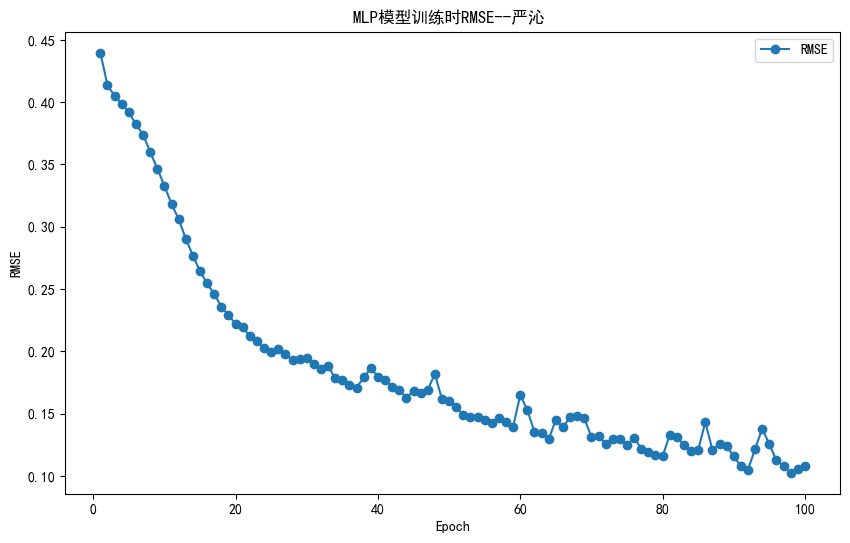

In [35]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设 'rmse' 是每个时期（epoch）的 RMSE 值列表
epochs = range(1, len(rmse) + 1)  # 生成一系列时期的列表

plt.figure(figsize=(10, 6)) # 可选：根据需要调整图形的大小
plt.plot(epochs, rmse, label='RMSE', marker='o', linestyle='-')  # 绘制 RMSE 随各时期变化的图表
plt.title('MLP模型训练时RMSE--严沁 ') # 为图表添加标题
plt.xlabel('Epoch')  # 为 x 轴添加标签
plt.ylabel('RMSE')  # 为 y 轴添加标签
plt.legend()  # 添加图例以指示线条代表的含义
# plt.xticks(epochs)  # 确保每个时期都有一个刻度
plt.show()  # 显示图表


这些结果看起来太好以至于难以置信，所以我猜我在计算误差时可能出错了，也许矩阵不同的原因不同于SVD。

In [36]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# 损失函数和优化器
criterion = nn.BCELoss()
mse_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率调度器
scheduler = ExponentialLR(optimizer, gamma=0.99)  # gamma 是衰减率
losses = []
rmse = []
# 训练循环
for epoch in range(100):
    model.train()  # 将模型设置为训练模式
    epoch_loss = 0
    mse_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids = user_ids.to(device) - 1  # 假设设备是 'cuda' 或 'cpu'
        item_ids = item_ids.to(device) - 1
        ratings = ratings.to(device).float().view(-1, 1)  # 确保 BCELoss 的形状和类型正确
        ratings = (ratings - 1) / 4
        
        optimizer.zero_grad()  # 清零梯度
        predictions = model(user_ids, item_ids)  # 前向传播
        loss = criterion(predictions, ratings)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        
        epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)

        batch_loss = mse_criterion(predictions, ratings)  # 使用 nn.MSELoss
        mse_loss += batch_loss.item()
    
    # 更新学习率
    scheduler.step()
        
    avg_mse = mse_loss / len(test_loader)
    avg_rmse = torch.sqrt(torch.tensor(avg_mse))
    rmse.append(avg_rmse)
    losses.append(epoch_loss / len(train_loader))

    print(f"Epoch {epoch}: Loss = {epoch_loss / len(train_loader)}, avg Rmse: {avg_rmse}")

Epoch 0: Loss = 0.459175150539424, avg Rmse: 0.11473137140274048
Epoch 1: Loss = 0.4568165894094351, avg Rmse: 0.10899654775857925
Epoch 2: Loss = 0.45627046628175555, avg Rmse: 0.11057344824075699
Epoch 3: Loss = 0.45942712001301145, avg Rmse: 0.11699846386909485
Epoch 4: Loss = 0.4575602539085053, avg Rmse: 0.11166590452194214
Epoch 5: Loss = 0.45826121117617635, avg Rmse: 0.11541485041379929
Epoch 6: Loss = 0.4652760517154191, avg Rmse: 0.1259436309337616
Epoch 7: Loss = 0.45798864477389567, avg Rmse: 0.11212395876646042
Epoch 8: Loss = 0.45639757016623345, avg Rmse: 0.1059660017490387
Epoch 9: Loss = 0.45409071948882695, avg Rmse: 0.09532729536294937
Epoch 10: Loss = 0.45587041198804573, avg Rmse: 0.09308107942342758
Epoch 11: Loss = 0.45532068620259697, avg Rmse: 0.100533127784729
Epoch 12: Loss = 0.4541261329038723, avg Rmse: 0.09724748879671097
Epoch 13: Loss = 0.4730550332649334, avg Rmse: 0.12901946902275085
Epoch 14: Loss = 0.46074187805926475, avg Rmse: 0.11328259110450745
E

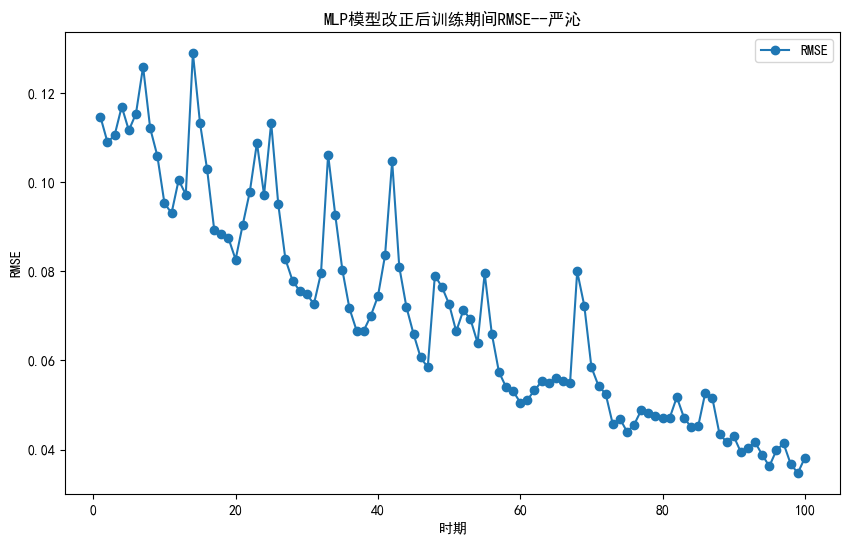

In [37]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设 'rmse' 是每个时期的 RMSE 值列表
epochs = range(1, len(rmse) + 1)  # 生成一系列时期的列表

plt.figure(figsize=(10, 6))  # 可选：根据需要调整图形的大小
plt.plot(epochs, rmse, label='RMSE', marker='o', linestyle='-')  # 绘制 RMSE 随各时期变化的图表
plt.title('MLP模型改正后训练期间RMSE--严沁')  # 为图表添加标题
plt.xlabel('时期')  # 为 x 轴添加标签
plt.ylabel('RMSE')  # 为 y 轴添加标签
plt.legend()  # 添加图例以指示线条代表的含义
# plt.xticks(epochs)  # 确保每个时期都有一个刻度
plt.show()  # 显示图表

In [38]:
#模型评估
train_loss, train_rmse, train_mae = evaluate_model_MLP(model, train_loader)
test_loss, test_rmse, test_mae = evaluate_model_MLP(model, test_loader)

print(f"Training Data - RMSE: {train_rmse}, Loss: {train_loss},  MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, Loss: {test_loss},  MAE: {test_mae}")

Training Data - RMSE: 0.05436958745121956, Loss: 1.3795858165249228,  MAE: 0.002956051778407224
Test Data - RMSE: 0.29139405488967896, Loss: 2.1401478399833045,  MAE: 0.08491049559476475


保存模型

In [39]:
torch.save(model, 'mlp_model_entire.pth')

In [40]:
model = torch.load('mlp_model_entire.pth')

In [41]:
#模型评估
train_loss, train_rmse, train_mae = evaluate_model_MLP(model, train_loader)
test_loss, test_rmse, test_mae = evaluate_model_MLP(model, test_loader)

print(f"Training Data - RMSE: {train_rmse}, Loss: {train_loss},  MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, Loss: {test_loss},  MAE: {test_mae}")

Training Data - RMSE: 0.05436825379729271, Loss: 1.3806415116414428,  MAE: 0.0029559069056025087
Test Data - RMSE: 0.29139405488967896, Loss: 2.1401478399833045,  MAE: 0.08491049559476475


## 将矩阵分解（SVD）和多层感知器（NN）结合到我们的组合NCF模型中

首先，再次定义模型，尽管在开始时以及在 SVD 步骤中已经这样做了（为了保持一致性）

In [42]:
import torch
import torch.nn as nn

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, mlp_layers):
        super(NCF, self).__init__()
        # 广义矩阵分解（GMF）嵌入
        self.embedding_user_gmf = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.embedding_item_gmf = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        
        # 多层感知机（MLP）嵌入
        self.embedding_user_mlp = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        
        # 多层感知机（MLP）层
        self.mlp = nn.Sequential()
        for in_size, out_size in zip(mlp_layers[:-1], mlp_layers[1:]):
            self.mlp.add_module('mlp_layer_{}'.format(in_size), nn.Linear(in_size, out_size))
            self.mlp.add_module('relu_{}'.format(in_size), nn.ReLU())
        
        # 最终预测层
        self.predict_layer = nn.Linear(embedding_size + mlp_layers[-1], 1)  # 根据 GMF 和最后的 MLP 层输出调整大小
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, user_indices, item_indices):
        # GMF 部分
        user_embedding_gmf = self.embedding_user_gmf(user_indices)
        item_embedding_gmf = self.embedding_item_gmf(item_indices)
        gmf_output = user_embedding_gmf * item_embedding_gmf
        
        # MLP 部分
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        mlp_input = torch.cat((user_embedding_mlp, item_embedding_mlp), -1)
        mlp_output = self.mlp(mlp_input)
        
        # 组合 GMF 和 MLP 输出
        combined_features = torch.cat((gmf_output, mlp_output), -1)
        
        # 最终预测
        predictions = self.predict_layer(combined_features)
        return self.sigmoid(predictions)

重新初始化

In [43]:
ncf_model = NCF(num_users=num_users, num_items=num_items, embedding_size=embedding_size, mlp_layers=[2 * embedding_size, 128, 64, 32])

复制 SVD 的值（在 SVD 步骤的最后已经这样做了，但由于为了保持一致性重新定义了模型，所以需要再次执行此操作）

加载保存的 SVD 结果

In [44]:
loaded_episode = TrainingEpisode.load('SVD for NCF')
SVD_P = loaded_episode.P_all_epochs[-1]
SVD_Q = loaded_episode.Q_all_epochs[-1]

In [45]:
# 模型评估
train_rmse, train_mae = evaluate_model(train_data, SVD_P, SVD_Q)
test_rmse, test_mae = evaluate_model(test_data, SVD_P, SVD_Q)

print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, MAE: {test_mae}")

Training Data - RMSE: 0.5986233824467588, MAE: 0.47096883193731776
Test Data - RMSE: 0.938359015034908, MAE: 0.7448408420329666


In [46]:
user_embeddings_tensor = torch.from_numpy(SVD_P).float()
item_embeddings_tensor = torch.from_numpy(SVD_Q).float()

In [47]:
# 假设 ncf_model 是 NCF 类的一个实例
ncf_model.embedding_user_gmf.weight.data.copy_(user_embeddings_tensor)
ncf_model.embedding_item_gmf.weight.data.copy_(item_embeddings_tensor)

tensor([[-0.1116,  0.2312, -0.2071,  ..., -0.0832, -0.2586,  0.2851],
        [-0.0334,  0.3274, -0.1815,  ..., -0.0348,  0.0118,  0.2679],
        [ 0.2791,  0.1337, -0.3279,  ..., -0.0990, -0.2310,  0.0191],
        ...,
        [-0.0383, -0.0602,  0.0441,  ..., -0.0521, -0.0898, -0.0146],
        [-0.1325,  0.2908, -0.1190,  ...,  0.1397, -0.1592,  0.2698],
        [-0.0425,  0.1394, -0.2655,  ..., -0.0911, -0.0854,  0.2256]])

接下来将训练好的 MLP 参数复制到组合 NCF 模型中

首先，重新加载模型，以防笔记本内存中清除了上一次的值

In [48]:
model = torch.load('mlp_model_entire.pth')

In [49]:
# 假设 'model' 是你训练好的 MLP 模型，而 'ncf_model' 是你新初始化的 NCF 模型

# 转移 MLP 嵌入
ncf_model.embedding_user_mlp.weight.data = model.embedding_user_mlp.weight.data.clone()
ncf_model.embedding_item_mlp.weight.data = model.embedding_item_mlp.weight.data.clone()

# 转移 MLP 层
for (ncf_layer, mlp_layer) in zip(ncf_model.mlp, model.mlp):
    if isinstance(ncf_layer, nn.Linear) and isinstance(mlp_layer, nn.Linear):
        # 从 MLP 复制权重和偏置到 NCF
        ncf_layer.weight.data = mlp_layer.weight.data.clone()
        ncf_layer.bias.data = mlp_layer.bias.data.clone()

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
ncf_model.to(device) 

NCF(
  (embedding_user_gmf): Embedding(943, 180)
  (embedding_item_gmf): Embedding(1682, 180)
  (embedding_user_mlp): Embedding(943, 180)
  (embedding_item_mlp): Embedding(1682, 180)
  (mlp): Sequential(
    (mlp_layer_360): Linear(in_features=360, out_features=128, bias=True)
    (relu_360): ReLU()
    (mlp_layer_128): Linear(in_features=128, out_features=64, bias=True)
    (relu_128): ReLU()
    (mlp_layer_64): Linear(in_features=64, out_features=32, bias=True)
    (relu_64): ReLU()
  )
  (predict_layer): Linear(in_features=212, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

现在已经成功地将单独训练的参数转移到了 NCF 模型中，先对其进行评估，看看它的表现如何

In [51]:
# 模型评估
train_loss, train_rmse, train_mae = evaluate_model_MLP(ncf_model, train_loader)
test_loss, test_rmse, test_mae = evaluate_model_MLP(ncf_model, test_loader)

print(f"Training Data - RMSE: {train_rmse}, Loss: {train_loss},  MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, Loss: {test_loss},  MAE: {test_mae}")

Training Data - RMSE: 0.4282054603099823, Loss: 2.1801828114936748,  MAE: 0.18335991248022765
Test Data - RMSE: 0.3445952832698822, Loss: 2.7295126877725124,  MAE: 0.11874590759786467


In [52]:
torch.save(ncf_model, 'ncf transfer init w no aditional training.pth')

上述结果明显比仅使用 MLP 模型得到的结果要差。同时，测试数据的表现比训练数据要好得多。但我认为从这个结果中并没有太多可以借鉴的，因为将两种不同的模型组合在一起，而没有一起训练它们，所以这可能很多都是随机噪声或类似的东西。

最终训练组合模型，尝试获得更好的结果

### 训练NCF混合模型 

In [53]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# 损失函数和优化器
criterion = nn.BCELoss()
mse_criterion = nn.MSELoss()
optimizer = optim.Adam(ncf_model.parameters(), lr=0.005)

# 定义学习率调度器
scheduler = ExponentialLR(optimizer, gamma=0.99)  # gamma 是衰减率
losses = []
tracked_rmse = []
# 训练循环
for epoch in range(100):
    ncf_model.train()  # 将模型设置为训练模式
    epoch_loss = 0
    mse_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids = user_ids.to(device) - 1  # 假设设备是 'cuda' 或 'cpu'
        item_ids = item_ids.to(device) - 1
        ratings = ratings.to(device).float().view(-1, 1)  # 确保 BCELoss 的形状和类型正确
        ratings = (ratings - 1) / 4
        
        optimizer.zero_grad()  # 清零梯度
        predictions = ncf_model(user_ids, item_ids)  # 前向传播
        loss = criterion(predictions, ratings)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        
        epoch_loss += loss.item()
        

        batch_loss = mse_criterion(predictions, ratings)  # 使用 nn.MSELoss
        mse_loss += batch_loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    # 更新学习率
    scheduler.step()
        
    avg_mse = mse_loss / len(test_loader)
    avg_rmse = torch.sqrt(torch.tensor(avg_mse))
    tracked_rmse.append(avg_rmse)
    losses.append(epoch_loss / len(train_loader))

    print(f"Epoch {epoch}: Loss = {epoch_loss / len(train_loader)}, avg Rmse: {avg_rmse}")

Epoch 0: Loss = 0.45838665660168676, avg Rmse: 0.10810596495866776
Epoch 1: Loss = 0.4483038391414526, avg Rmse: 0.05521367862820625
Epoch 2: Loss = 0.4472998638410826, avg Rmse: 0.048966892063617706
Epoch 3: Loss = 0.44727731767941165, avg Rmse: 0.050011780112981796
Epoch 4: Loss = 0.4476720377601482, avg Rmse: 0.04931502789258957
Epoch 5: Loss = 0.44683984032756574, avg Rmse: 0.044620331376791
Epoch 6: Loss = 0.44827040294940407, avg Rmse: 0.056042712181806564
Epoch 7: Loss = 0.44734198267798164, avg Rmse: 0.05130380392074585
Epoch 8: Loss = 0.44705057959701566, avg Rmse: 0.0495937317609787
Epoch 9: Loss = 0.4473246857523918, avg Rmse: 0.049903932958841324
Epoch 10: Loss = 0.4473126950497563, avg Rmse: 0.048885952681303024
Epoch 11: Loss = 0.446885044107566, avg Rmse: 0.048833008855581284
Epoch 12: Loss = 0.44783966686274557, avg Rmse: 0.05172149837017059
Epoch 13: Loss = 0.44741367901096474, avg Rmse: 0.0485859178006649
Epoch 14: Loss = 0.4472720493134615, avg Rmse: 0.05054565146565

In [54]:
#模型评估
train_loss, train_rmse, train_mae = evaluate_model_MLP(ncf_model, train_loader)
test_loss, test_rmse, test_mae = evaluate_model_MLP(ncf_model, test_loader)

print(f"Training Data - RMSE: {train_rmse}, Loss: {train_loss},  MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, Loss: {test_loss},  MAE: {test_mae}")

Training Data - RMSE: 0.021830536425113678, Loss: 1.3727301638573408,  MAE: 0.00047657235321215313
Test Data - RMSE: 0.2748258709907532, Loss: 2.2620041432480016,  MAE: 0.07552925528337558


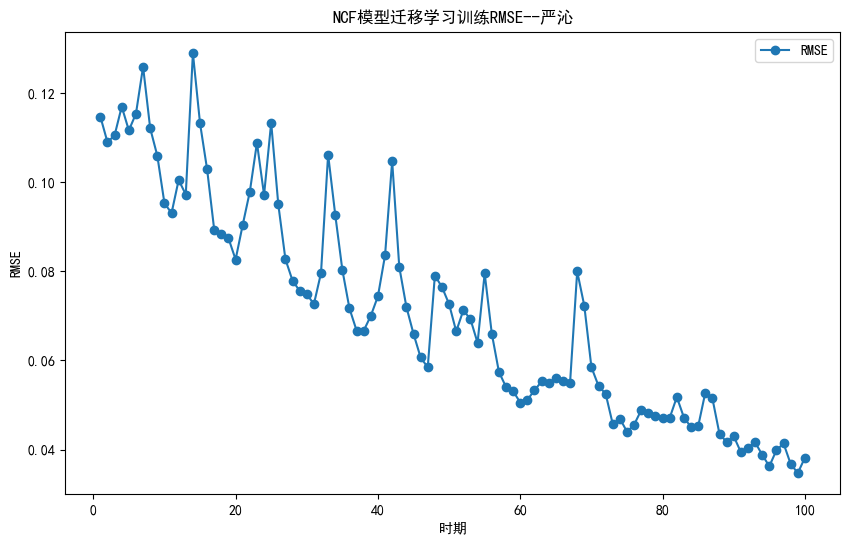

In [55]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设 'rmse' 是每个时期的 RMSE 值列表
epochs = range(1, len(rmse) + 1)  # 生成一系列时期的列表

plt.figure(figsize=(10, 6))  # 可选：根据需要调整图形的大小
plt.plot(epochs, rmse, label='RMSE', marker='o', linestyle='-')  # 绘制 RMSE 随各时期变化的图表
plt.title('NCF模型迁移学习训练RMSE--严沁')  # 为图表添加标题
plt.xlabel('时期')  # 为 x 轴添加标签
plt.ylabel('RMSE')  # 为 y 轴添加标签
plt.legend()  # 添加图例以指示线条代表的含义
# plt.xticks(epochs)  # 确保每个时期都有一个刻度
plt.show()  # 显示图表

In [56]:
torch.save(ncf_model, 'NCF model.pth')

### 比较迁移学习与从头开始训练

我们首先分别训练了 GMF 部分和 MLP 部分，然后将它们结合起来训练组合的 NCF 模型，这个过程被称为迁移学习（或者说是一种迁移学习）。我们从“随机初始化”开始训练我们的 NCF 模型，并看看迁移学习的作用有多大。

重新定义模型

In [57]:
ncf_model_from_scratch = NCF(num_users=num_users, num_items=num_items, embedding_size=embedding_size, mlp_layers=[2 * embedding_size, 128, 64, 32])

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
ncf_model_from_scratch.to(device)  # Move your model to the specified device

NCF(
  (embedding_user_gmf): Embedding(943, 180)
  (embedding_item_gmf): Embedding(1682, 180)
  (embedding_user_mlp): Embedding(943, 180)
  (embedding_item_mlp): Embedding(1682, 180)
  (mlp): Sequential(
    (mlp_layer_360): Linear(in_features=360, out_features=128, bias=True)
    (relu_360): ReLU()
    (mlp_layer_128): Linear(in_features=128, out_features=64, bias=True)
    (relu_128): ReLU()
    (mlp_layer_64): Linear(in_features=64, out_features=32, bias=True)
    (relu_64): ReLU()
  )
  (predict_layer): Linear(in_features=212, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

从头开始训练最后一个模型，而不是使用预训练的 GMF 和 MLP。

In [59]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# 损失函数和优化器
criterion = nn.BCELoss()
mse_criterion = nn.MSELoss()
optimizer = optim.Adam(ncf_model_from_scratch.parameters(), lr=0.01)

# 定义学习率调度器
scheduler = ExponentialLR(optimizer, gamma=0.99)  # gamma 是衰减率
losses = []
tracked_rmse = []
# 训练循环
for epoch in range(100):
    ncf_model_from_scratch.train()  # 将模型设置为训练模式
    epoch_loss = 0
    mse_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids = user_ids.to(device) - 1  # 假设设备是 'cuda' 或 'cpu'
        item_ids = item_ids.to(device) - 1
        ratings = ratings.to(device).float().view(-1, 1)  # 确保 BCELoss 的形状和类型正确
        ratings = (ratings - 1) / 4
        
        optimizer.zero_grad()  # 清零梯度
        predictions = ncf_model_from_scratch(user_ids, item_ids)  # 前向传播
        loss = criterion(predictions, ratings)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        
        epoch_loss += loss.item()
        # batch_loss = mse_criterion(predictions, ratings)  # 使用 nn.MSELoss
        mse_loss += batch_loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    # 更新学习率
    scheduler.step()
        
    avg_mse = mse_loss / len(test_loader)
    avg_rmse = torch.sqrt(torch.tensor(avg_mse))
    tracked_rmse.append(avg_mse)
    losses.append(epoch_loss / len(train_loader))

    print(f"Epoch {epoch}: Loss = {epoch_loss / len(train_loader)}, avg Rmse: {avg_rmse}")

Epoch 0: Loss = 0.6273801503954707, avg Rmse: 0.014961079694330692
Epoch 1: Loss = 0.6063120663166046, avg Rmse: 0.014961079694330692
Epoch 2: Loss = 0.5892649371479008, avg Rmse: 0.014961079694330692
Epoch 3: Loss = 0.5519962040959178, avg Rmse: 0.014961079694330692
Epoch 4: Loss = 0.5113147071285827, avg Rmse: 0.014961079694330692
Epoch 5: Loss = 0.4870940766020401, avg Rmse: 0.014961079694330692
Epoch 6: Loss = 0.47584998809002543, avg Rmse: 0.014961079694330692
Epoch 7: Loss = 0.47066389739110664, avg Rmse: 0.014961079694330692
Epoch 8: Loss = 0.46798585023026207, avg Rmse: 0.014961079694330692
Epoch 9: Loss = 0.4646832835231278, avg Rmse: 0.014961079694330692
Epoch 10: Loss = 0.46331633556936236, avg Rmse: 0.014961079694330692
Epoch 11: Loss = 0.4627332096365658, avg Rmse: 0.014961079694330692
Epoch 12: Loss = 0.461084008619592, avg Rmse: 0.014961079694330692
Epoch 13: Loss = 0.4601705159891296, avg Rmse: 0.014961079694330692
Epoch 14: Loss = 0.45929157361388206, avg Rmse: 0.01496

In [60]:
# 模型评估
train_loss, train_rmse, train_mae = evaluate_model_MLP(ncf_model_from_scratch, train_loader)
test_loss, test_rmse, test_mae = evaluate_model_MLP(ncf_model_from_scratch, test_loader)

print(f"Training Data - RMSE: {train_rmse}, Loss: {train_loss},  MAE: {train_mae}")
print(f"Test Data - RMSE: {test_rmse}, Loss: {test_loss},  MAE: {test_mae}")

Training Data - RMSE: 0.05229350924491882, Loss: 1.3763194683318336,  MAE: 0.002734611039462228
Test Data - RMSE: 0.3055092990398407, Loss: 0.7625533416867256,  MAE: 0.09333593662207325


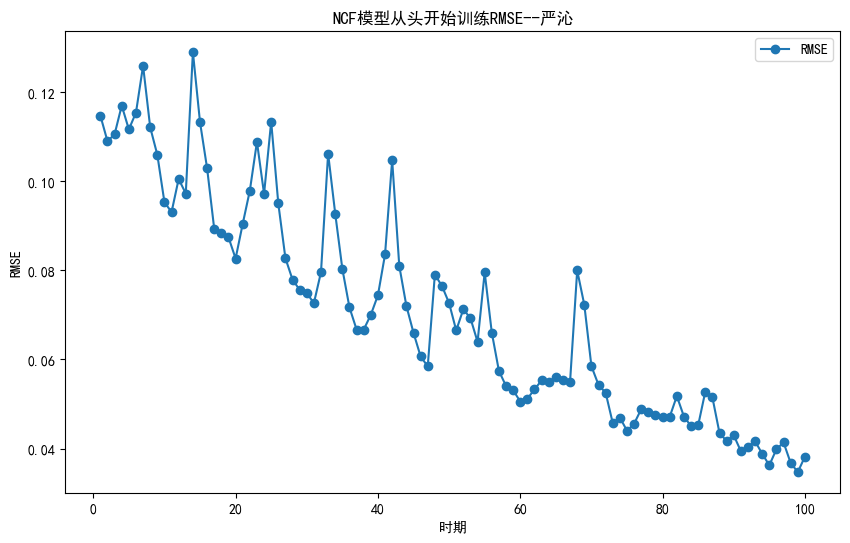

In [61]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置matplotlib支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种常见的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 假设 'rmse' 是每个时期的 RMSE 值列表
epochs = range(1, len(rmse) + 1)  # 生成一系列时期的列表，假设 'rmse' 已经定义

plt.figure(figsize=(10, 6))  # 可选：根据需要调整图形的大小
plt.plot(epochs, rmse, label='RMSE', marker='o', linestyle='-')  # 绘制 RMSE 随各时期变化的图表
plt.title('NCF模型从头开始训练RMSE--严沁')  # 为图表添加标题
plt.xlabel('时期')  # 为 x 轴添加标签
plt.ylabel('RMSE')  # 为 y 轴添加标签
plt.legend()  # 添加图例以指示线条代表的含义
# plt.xticks(epochs)  # 确保每个时期都有一个刻度
plt.show()  # 显示图表

## 预测

在一些预测示例上测试之前的最佳模型

In [62]:
model = torch.load('NCF model.pth')

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
model.to(device)  # Move your model to the specified device

NCF(
  (embedding_user_gmf): Embedding(943, 180)
  (embedding_item_gmf): Embedding(1682, 180)
  (embedding_user_mlp): Embedding(943, 180)
  (embedding_item_mlp): Embedding(1682, 180)
  (mlp): Sequential(
    (mlp_layer_360): Linear(in_features=360, out_features=128, bias=True)
    (relu_360): ReLU()
    (mlp_layer_128): Linear(in_features=128, out_features=64, bias=True)
    (relu_128): ReLU()
    (mlp_layer_64): Linear(in_features=64, out_features=32, bias=True)
    (relu_64): ReLU()
  )
  (predict_layer): Linear(in_features=212, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [64]:
train_data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
75534,42,925,4,881106113
75535,781,324,4,879633862
75536,389,386,3,880089302
75537,64,516,5,889737376


In [65]:
def predict_single_rating(model, data_row, device):
    # 确保模型处于评估模式
    model.eval()
    
    # 从数据行中提取用户ID和物品ID
    user_id = torch.tensor([data_row['user_id']]).to(device) - 1  # 调整为基于零的索引
    item_id = torch.tensor([data_row['item_id']]).to(device) - 1  # 调整为基于零的索引
    
    # 执行预测
    with torch.no_grad():
        prediction = model(user_id, item_id)
        
    # 假设输出已缩放到评分，如有必要调整比例
    predicted_rating = prediction.item() * 4 + 1  # 缩放回 1-5 的范围
    return predicted_rating  # 确保返回预测评分

In [66]:
import torch
import numpy as np

def calculate_rmse(model, data, device, n):
    """
    计算模型预测的均方根误差（RMSE）。

    参数:
    - model: 已加载的 PyTorch 模型。
    - data: 包含训练数据的 pandas DataFrame。
    - device: 模型运行的设备（如 'cpu' 或 'cuda'）。
    - n: 用于计算 RMSE 的数据行数。

    返回:
    - rmse: 计算得到的 RMSE 值。
    """
    actual_ratings = []
    predicted_ratings = []

    for i in range(n):
        data_row = data.iloc[i]
        user_id = torch.tensor([data_row['user_id']]).to(device) - 1
        item_id = torch.tensor([data_row['item_id']]).to(device) - 1
        with torch.no_grad():
            prediction = model(user_id, item_id)
            predicted_rating = prediction.item() * 4 + 1
            actual_ratings.append(data_row['rating'])
            predicted_ratings.append(predicted_rating)

    # 计算 RMSE
    squared_errors = [(np.array([actual]) - np.array([predicted]))**2 for actual, predicted in zip(actual_ratings, predicted_ratings)]
    rmse = np.sqrt(sum(squared_errors) / n)

    return rmse

RMSE: [0.02661532]
[3, 3, 1, 2, 1, 4, 2, 5, 3, 3]
[2.9586799144744873, 2.939094066619873, 1.0, 1.9905795454978943, 1.00030165744829, 4.029615163803101, 1.9902053475379944, 4.999999046325684, 2.9929330348968506, 2.9764394760131836]


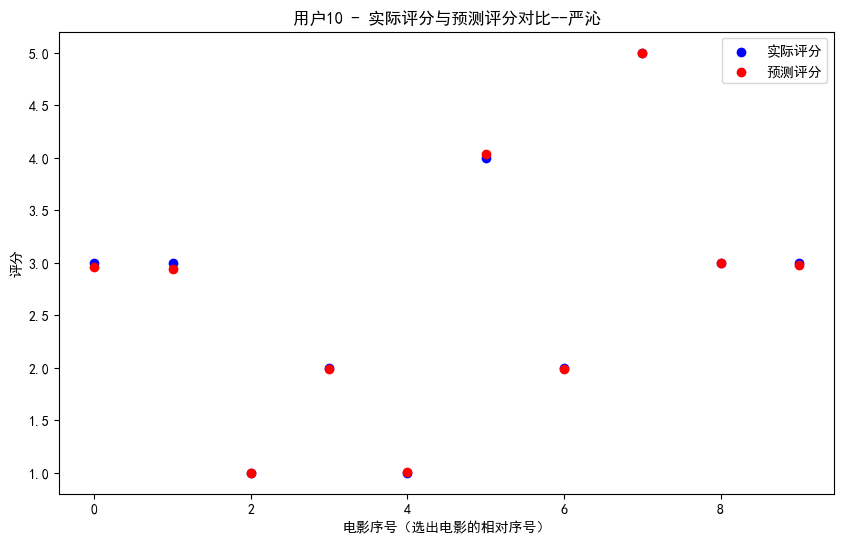

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 'train_data' 是一个包含你的训练数据的 pandas DataFrame
# 假设 'model' 是你的训练好的模型
# 假设 'device' 是你的设备（CPU或GPU）

n = 10  # 选择数据集中的前n个数据点进行预测和绘图
actual_ratings = []  # 用于存储实际评分的列表
predicted_ratings = []  # 用于存储预测评分的列表

for i in range(n):
    data_row = train_data.iloc[i]  # 选择第i行数据进行预测
    # 执行预测并获取预测评分
    predicted_rating = predict_single_rating(model, data_row, device)
    # 将实际评分和预测评分添加到列表中
    actual_ratings.append(data_row['rating'])
    if predicted_rating is not None:  # 确保预测评分不是None
        predicted_ratings.append(predicted_rating)
    else:
        print(f"Warning: Predicted rating for data row {i} is None.")

# 调用 calculate_rmse 函数并传入所需的参数
rmse_value = calculate_rmse(model, train_data, device, n)

# 打印 RMSE 值
print("RMSE:", rmse_value)
print(actual_ratings)
print(predicted_ratings)
# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_ratings)), actual_ratings, color='blue', label='实际评分')  # 绘制真实评分
plt.scatter(range(len(predicted_ratings)), predicted_ratings, color='red', label='预测评分')  # 绘制预测评分

plt.title('用户{} - 实际评分与预测评分对比--严沁'.format(n))
plt.xlabel('电影序号（选出电影的相对序号）')
plt.ylabel('评分')
plt.legend()
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.show()

RMSE: [0.03124568]
[3, 3, 1, 2, 1, 4, 2, 5, 3, 3, 2, 5, 5, 3, 3, 3, 5, 2, 4, 2]
[2.9586799144744873, 2.939094066619873, 1.0, 1.9905795454978943, 1.00030165744829, 4.029615163803101, 1.9902053475379944, 4.999999046325684, 2.9929330348968506, 2.9764394760131836, 2.051571488380432, 5.0, 4.999999523162842, 3.030431032180786, 3.00567889213562, 2.997535467147827, 5.0, 1.978863775730133, 4.091349124908447, 2.0051674842834473]


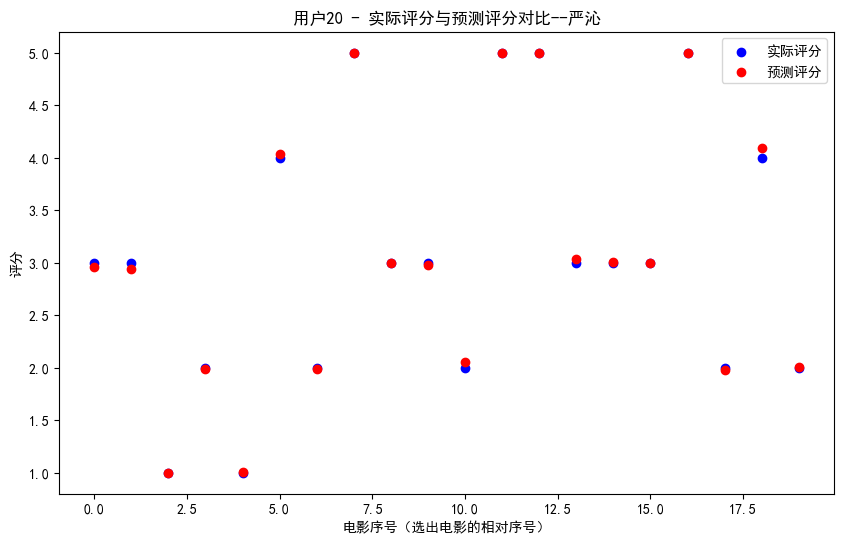

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 'train_data' 是一个包含你的训练数据的 pandas DataFrame
# 假设 'model' 是你的训练好的模型
# 假设 'device' 是你的设备（CPU或GPU）

n = 20  # 选择数据集中的前n个数据点进行预测和绘图
actual_ratings = []  # 用于存储实际评分的列表
predicted_ratings = []  # 用于存储预测评分的列表

for i in range(n):
    data_row = train_data.iloc[i]  # 选择第i行数据进行预测
    # 执行预测并获取预测评分
    predicted_rating = predict_single_rating(model, data_row, device)
    # 将实际评分和预测评分添加到列表中
    actual_ratings.append(data_row['rating'])
    if predicted_rating is not None:  # 确保预测评分不是None
        predicted_ratings.append(predicted_rating)
    else:
        print(f"Warning: Predicted rating for data row {i} is None.")

# 调用 calculate_rmse 函数并传入所需的参数
rmse_value = calculate_rmse(model, train_data, device, n)

# 打印 RMSE 值
print("RMSE:", rmse_value)
print(actual_ratings)
print(predicted_ratings)
# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_ratings)), actual_ratings, color='blue', label='实际评分')  # 绘制真实评分
plt.scatter(range(len(predicted_ratings)), predicted_ratings, color='red', label='预测评分')  # 绘制预测评分

plt.title('用户{} - 实际评分与预测评分对比--严沁'.format(n))
plt.xlabel('电影序号（选出电影的相对序号）')
plt.ylabel('评分')
plt.legend()
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.show()